In [1]:
# env: rapids_singlecell

import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import warnings

import scvi
scvi.settings.seed = 1 
random_seed = 42
np.random.seed(random_seed)

from scipy.sparse import csr_array
from skimage import morphology, transform

from tifffile import imwrite
from tifffile import imread

import os
os.chdir('/laune_zfs/scratch/peter/f_active/paper_23/') # laune
# os.chdir('/home/ubuntu/projects/paper_23') # aws


/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_key

In [62]:
adata_DA

AnnData object with n_obs × n_vars = 6378 × 14494
    obs: 'area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'x', 'y', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n', 'keep', 'x_orig', 'y_orig', 'cell_type', 'SN_VTA', 'CA1_CA3'
    uns: 'sample_name_colors', 'log1p', 'SN_VTA'
    obsm: 'spatial'
    layers: 'counts'

In [2]:
adata_gst = sc.read_h5ad('input/04_cluster/adata_SEDR_post_mclust.h5ad')
d_gst = adata_gst.obs['SEDR_20'].to_dict()

adata_nongst = sc.read_h5ad('input/04_cluster/adata_nongst.h5ad')
# for i in range(20, 31):
#     adata_nongst.obs['SEDR_' + str(i)] = '1000'
d_nongst = adata_nongst.obs['cell_type'].to_dict()

adata = ad.concat([adata_gst, adata_nongst])
adata.obs['cell_type'] = 'unknown'
adata.obs['cell_type'].update(d_nongst)
adata.obs['cell_type'].update(d_gst)

adata_full = sc.read_h5ad('input/03_rotation/adata_rotated_cleaned.h5ad')
adata_full = adata_full[adata.obs_names, :].copy()
adata_full.obs['cell_type'] = 'unknown'
adata_full.obs['cell_type'].update(adata.obs['cell_type'].to_dict())
adata = adata_full

del adata_gst
del adata_nongst

adata

AnnData object with n_obs × n_vars = 389396 × 14494
    obs: 'area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'x', 'y', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n', 'keep', 'x_orig', 'y_orig', 'cell_type'
    uns: 'sample_name_colors'
    obsm: 'spatial'
    layers: 'counts'

In [4]:
from tqdm import tqdm

def plot_all_spatial(k, adata):

    adata.obs['domain'] = adata.obs[k]
    adata.obs['domain'] = adata.obs[k].astype('str')
    # domains = sorted(adata.obs['domain'].astype('int').unique())
    
    clusters = list(adata.obs['domain'].unique())
    domains = list(range(0, len(clusters)))
    
    fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(30, 25))

    row = 0
    for dom in tqdm(domains):
        # print('Domain: ' + str(dom))
        if dom % 5 == 0:
            col = 4
        else:
            col = (dom % 5) - 1

        # print('Row: ' + str(row))
        # print('Column: ' + str(col))
        # for col, section in enumerate(adata.obs.sample_name.unique()):

        sc.pl.spatial(adata, 
                     spot_size=25, 
                      size = 5,
                      groups = clusters[dom],
                     color = 'domain', 
                      palette = ['black' for x in clusters],
                     ax=axs[row, col], 
                      title = clusters[dom],
                     show=False)
        plt.suptitle(k, y = 1.05)

        if dom % 5 == 0:
            row += 1

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    adata_temp = adata[adata.obs['sample_name'] == 'YOUNG_WT_3', :].copy()
    plot_all_spatial('cell_type', adata_temp)

In [5]:
adata.obs.loc[adata.obs['cell_type'] == '8', 'cell_type'] = 'meninges'

In [6]:
adata.obs.loc[adata.obs['cell_type'] == '20', 'cell_type'] = 'DG'

In [7]:
adata.obs.loc[adata.obs['cell_type'] == '11', 'cell_type'] = 'DG'

In [8]:
adata.obs.loc[adata.obs['cell_type'] == '19', 'cell_type'] = 'thalamus'

In [9]:
adata.obs.loc[adata.obs['cell_type'] == '18', 'cell_type'] = 'dopaminergic'

In [10]:
adata.obs.loc[adata.obs['cell_type'] == '9', 'cell_type'] = 'CA1_CA3'

In [19]:
adata_remaining = adata[adata.obs['cell_type'].isin([str(i) for i in range(20)]), :].copy()

In [11]:
sc.pp.normalize_total(adata_remaining, target_sum=1e4)
sc.pp.log1p(adata_remaining)

In [12]:
sc.tl.rank_genes_groups(adata_remaining, groupby='cell_type', method='wilcoxon')

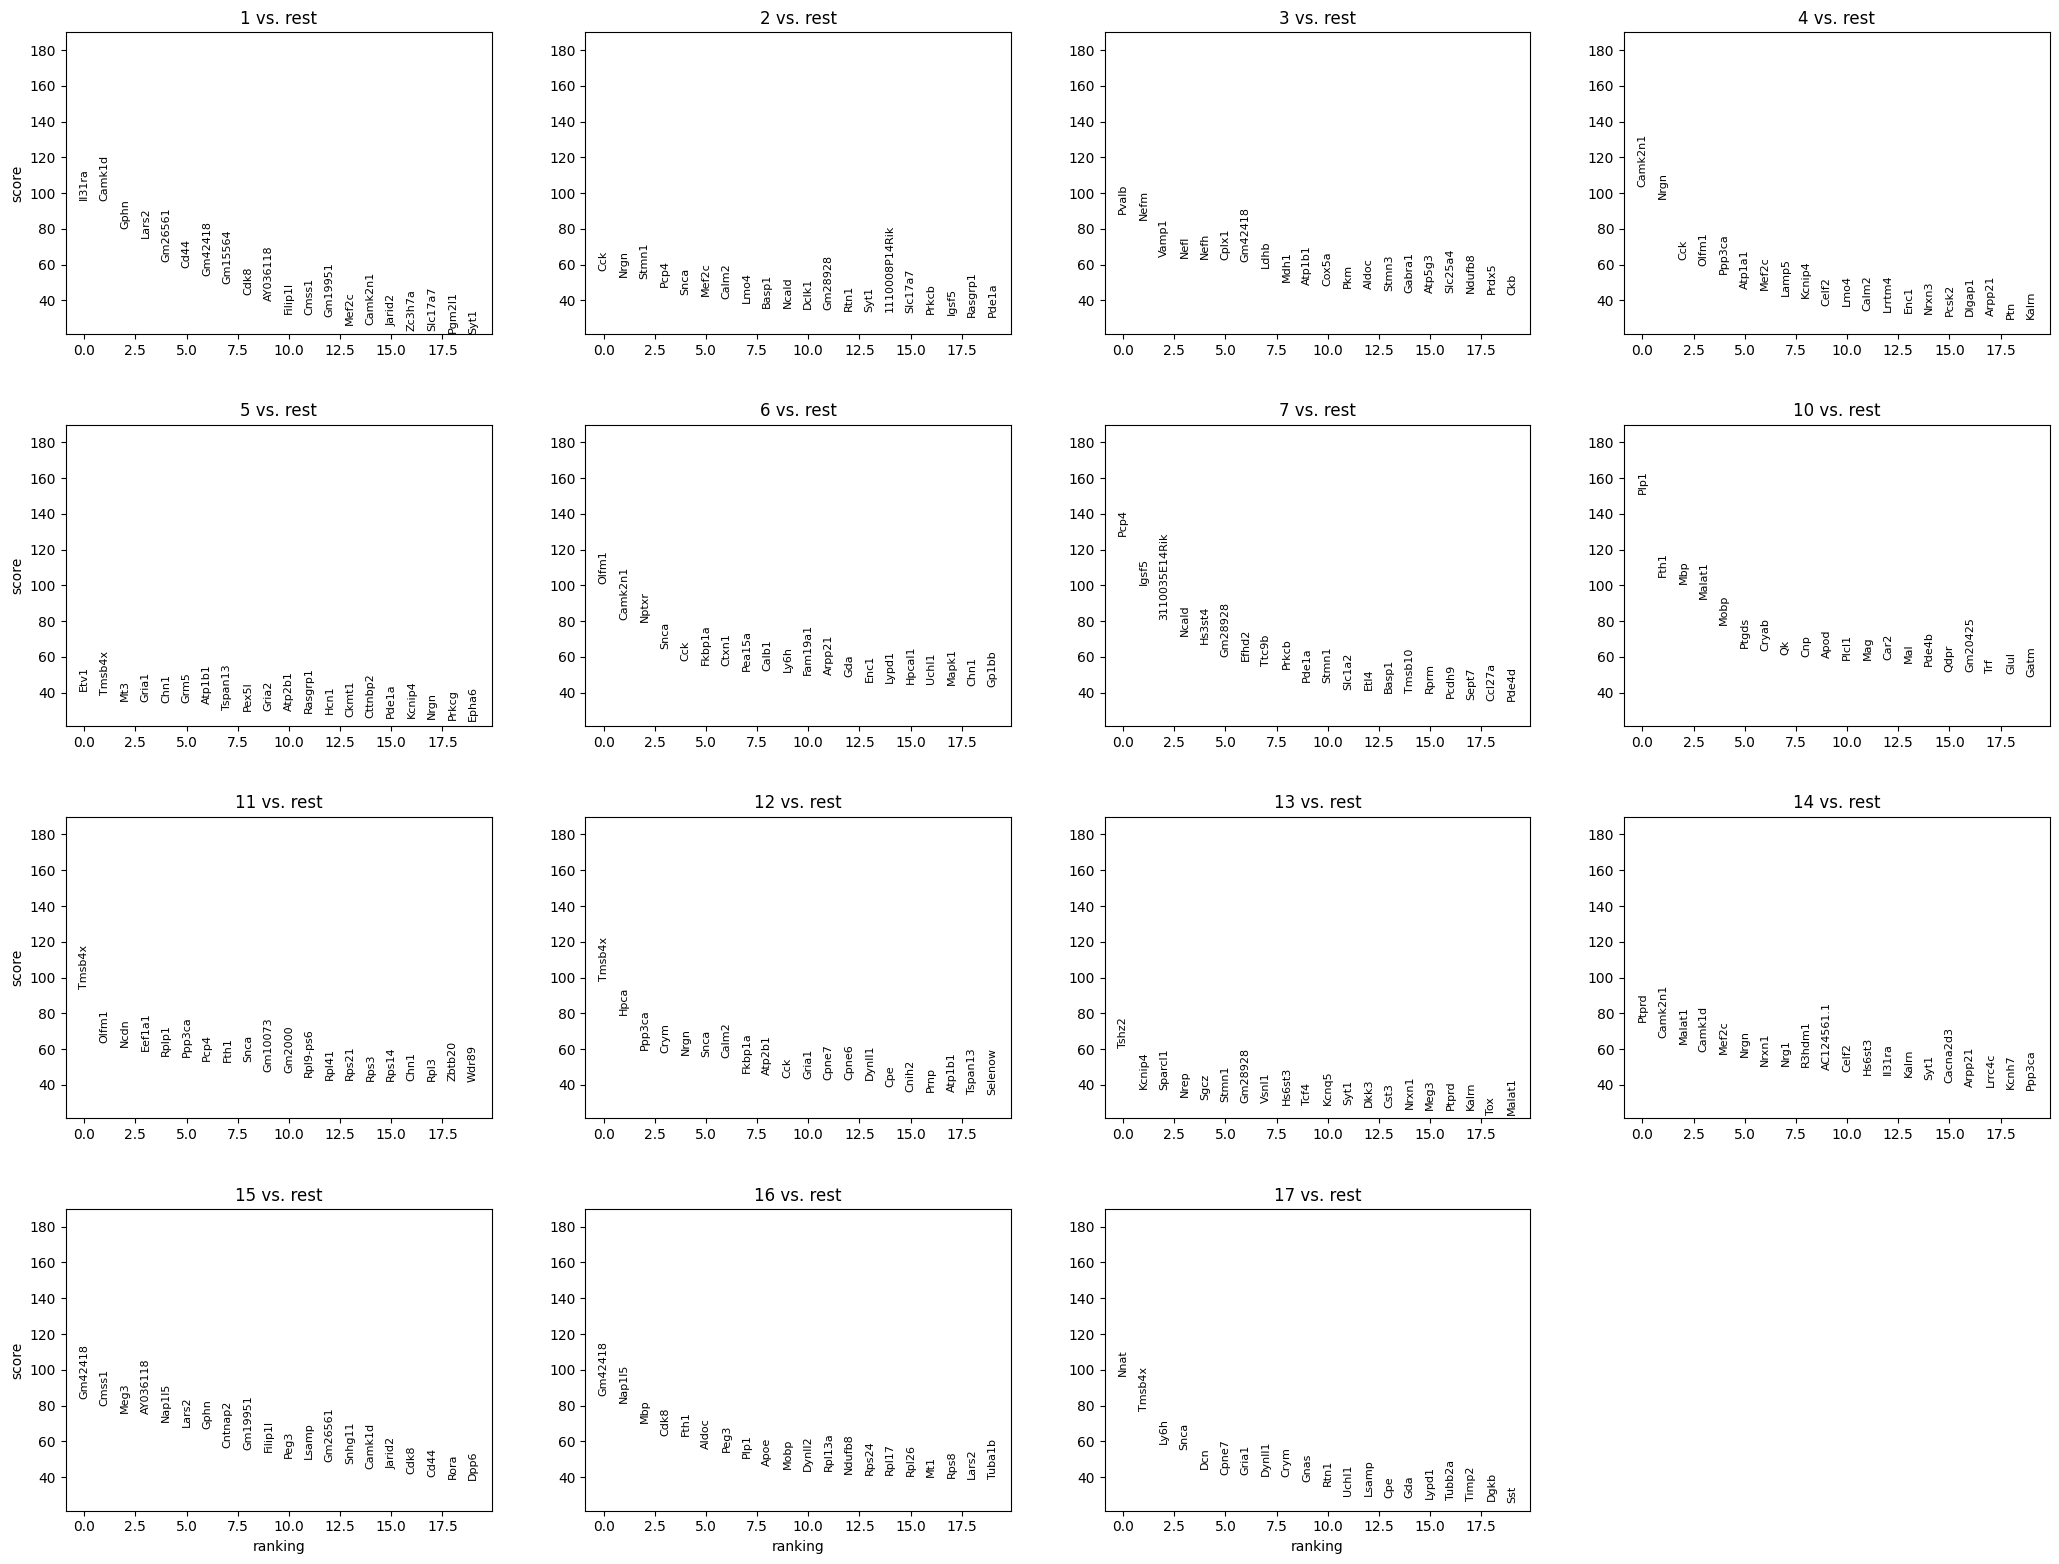

In [13]:
sc.pl.rank_genes_groups(adata_remaining)

/home/peter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


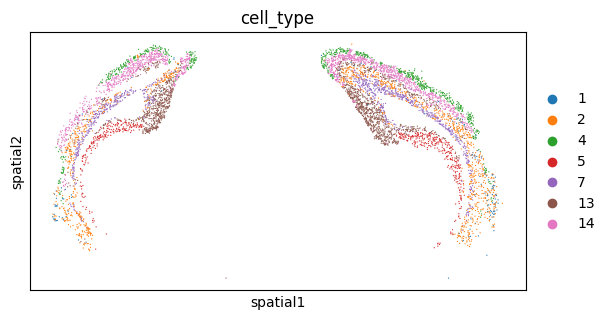

/home/peter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


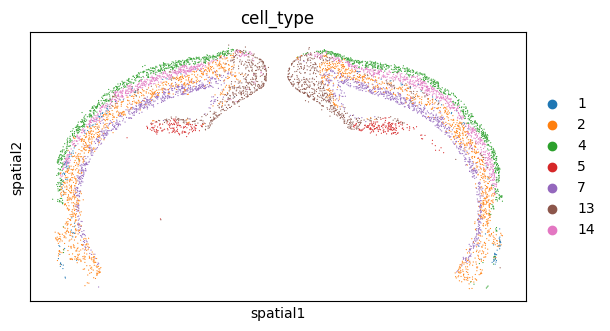

/home/peter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


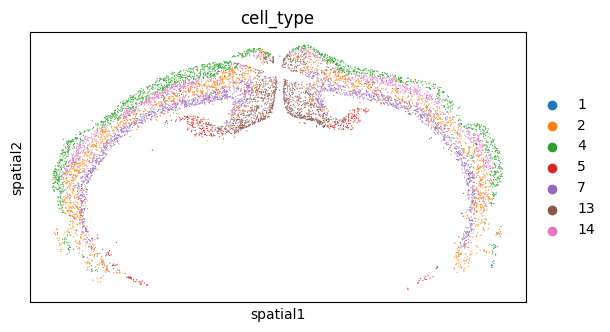

/home/peter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


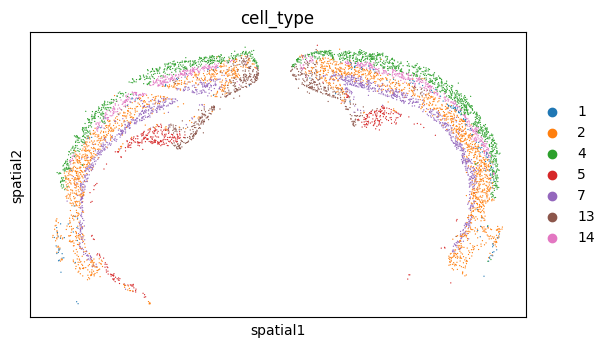

In [36]:
x = ['1', '2', '4', '5', '7', '13', '14']

for k in adata_remaining.obs['sample_name'].unique():
    if '1' in k:
        sc.pl.spatial(adata_remaining[(adata_remaining.obs['sample_name'] == k) & (adata_remaining.obs['cell_type'].isin(x)), :], color = 'cell_type', spot_size = 50)

In [11]:
adata.obs.loc[adata.obs['cell_type'] == '4', 'cell_type'] = 'L1'
adata.obs.loc[adata.obs['cell_type'] == '14', 'cell_type'] = 'L2/3'
adata.obs.loc[adata.obs['cell_type'] == '1', 'cell_type'] = 'L4'
adata.obs.loc[adata.obs['cell_type'] == '2', 'cell_type'] = 'L5'
adata.obs.loc[adata.obs['cell_type'] == '7', 'cell_type'] = 'L6'
adata.obs.loc[adata.obs['cell_type'] == '5', 'cell_type'] = 'subiculumDorsal'
adata.obs.loc[adata.obs['cell_type'] == '13', 'cell_type'] = 'retrosplenial'

In [38]:
adata_remaining = adata[adata.obs['cell_type'].isin([str(i) for i in range(20)]), :].copy()

In [40]:
sc.pp.normalize_total(adata_remaining, target_sum=1e4)
sc.pp.log1p(adata_remaining)

In [41]:
sc.tl.rank_genes_groups(adata_remaining, groupby='cell_type', method='wilcoxon')

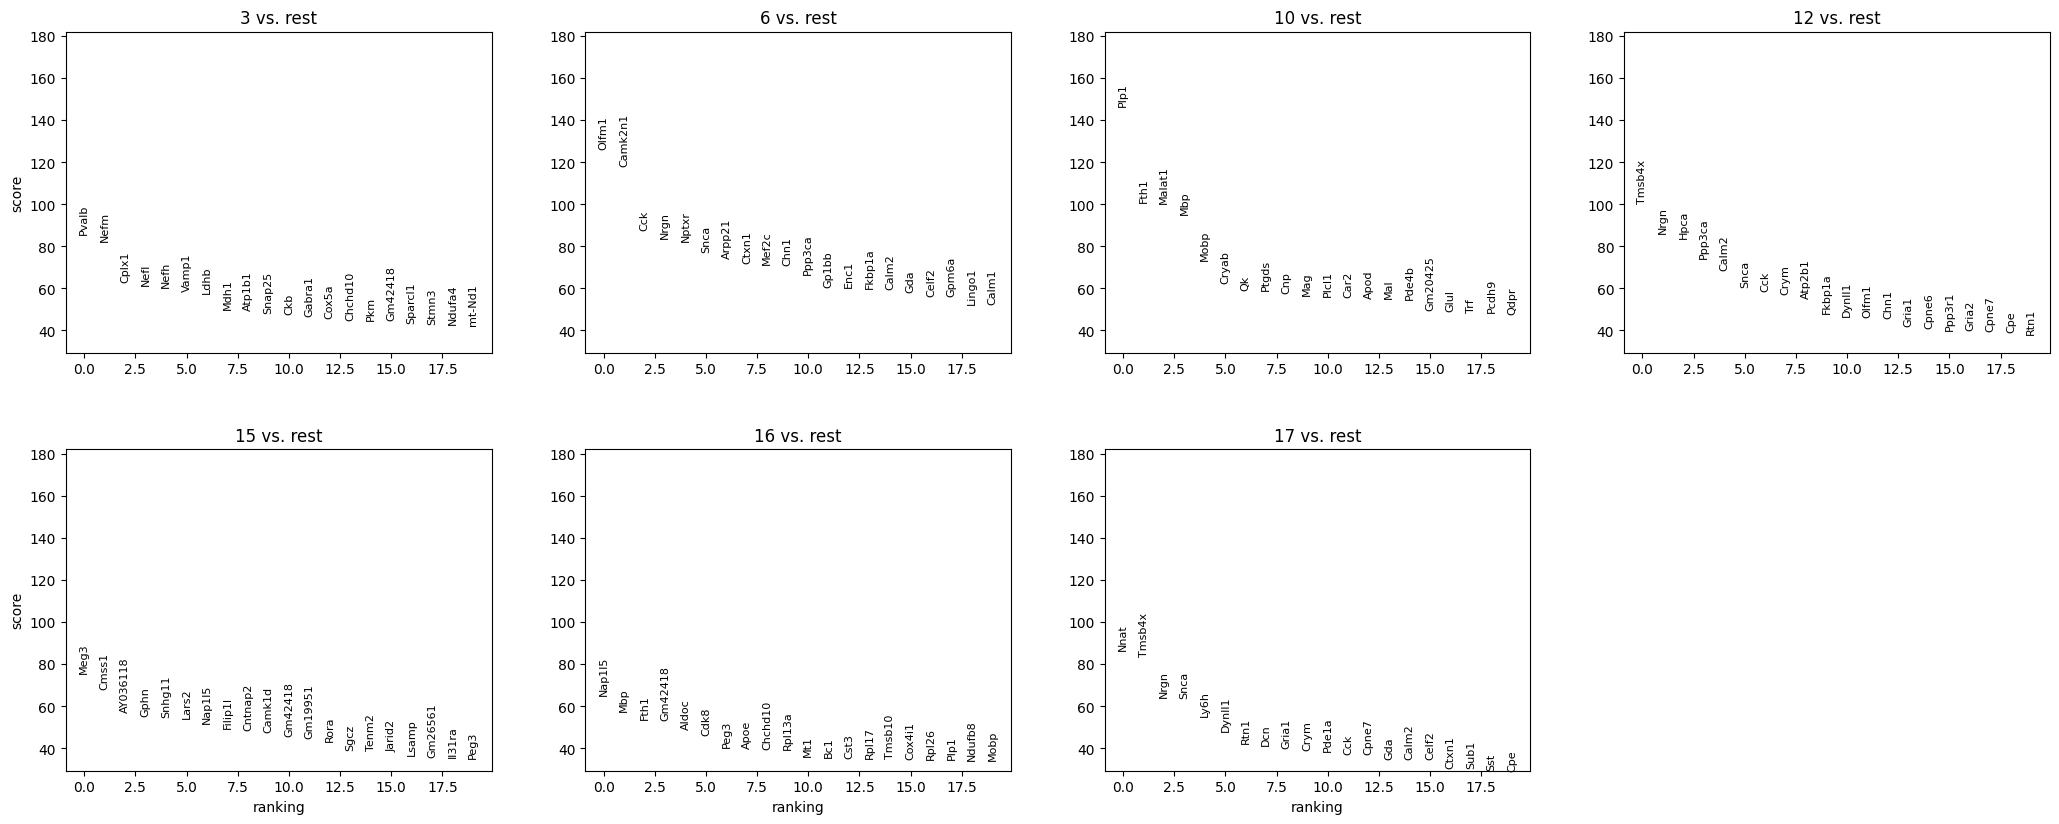

In [42]:
sc.pl.rank_genes_groups(adata_remaining)

/home/peter/.local/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


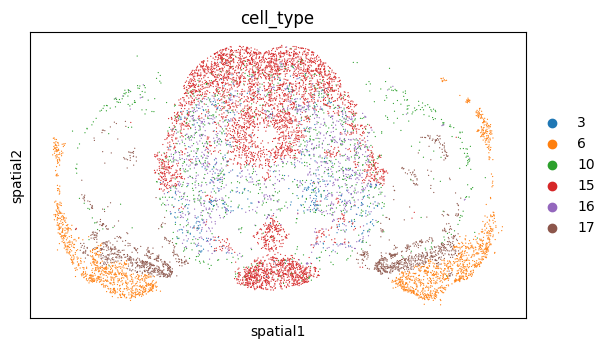

/home/peter/.local/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


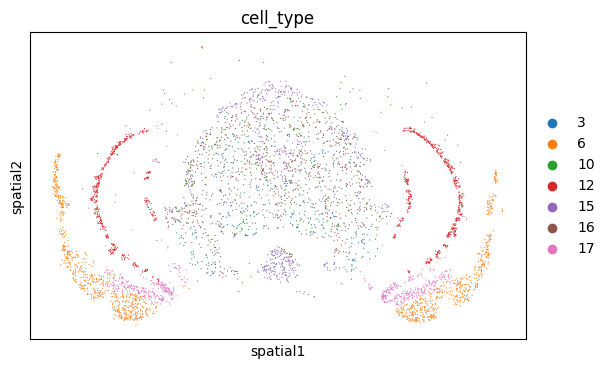

/home/peter/.local/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


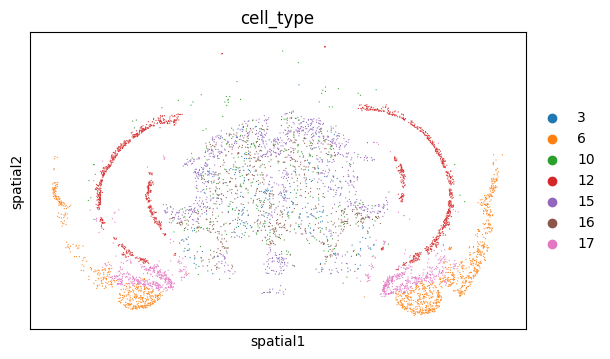

/home/peter/.local/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


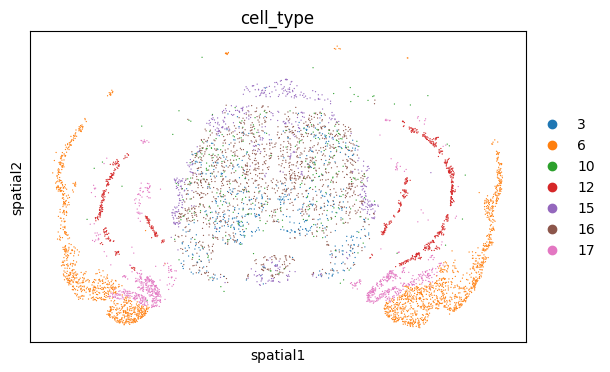

In [43]:
for k in adata_remaining.obs['sample_name'].unique():
    if '1' in k:
        sc.pl.spatial(adata_remaining[adata_remaining.obs['sample_name'] == k, :], color = 'cell_type', spot_size = 50)

In [12]:
adata.obs.loc[adata.obs['cell_type'] == '3', 'cell_type'] = 'midbrainInterneurons'
adata.obs.loc[adata.obs['cell_type'] == '6', 'cell_type'] = 'amygdalaPostpiriformEntorhinal'
adata.obs.loc[adata.obs['cell_type'] == '10', 'cell_type'] = 'oligo_2'
adata.obs.loc[adata.obs['cell_type'] == '15', 'cell_type'] = 'midbrainExcitatory'
adata.obs.loc[adata.obs['cell_type'] == '16', 'cell_type'] = 'midbrainGlia'
adata.obs.loc[adata.obs['cell_type'] == '17', 'cell_type'] = 'subiculumVentral'
adata.obs.loc[adata.obs['cell_type'] == '12', 'cell_type'] = 'CA1_CA3'


In [50]:
adata.obs.groupby('cell_type').size()

cell_type
CA1_CA3                                         33102
DG                                              16159
L1                                              20143
L2/3                                            18164
L4                                               4051
L5                                              32049
L6                                              22004
amygdalaPostpiriformEntorhinal                  24809
astrocytes_diffuse_type0                        15493
astrocytes_diffuse_type1                        12027
astrocytes_unknown                                131
cortexCA3_group1_hbb                              445
corticalInterneurons_adarb2                     10780
corticalInterneurons_sst_pvalb                   9828
corticalInterneurons_sst_sst                     9601
dopaminergic                                     6378
meninges                                         4962
midbrainCapsule_midbrainCapsule_OPC              3091
midbrainCapsule_mi

# Separate SN and VTA

In [15]:
d_adata = {}

for count, x in enumerate(adata.obs['sample_name'].unique()):
    d_adata[x] = adata[adata.obs['sample_name'] == x,].copy()
    
d_adata_DA = {}

adata_DA = adata[adata.obs['cell_type'] == 'dopaminergic', :].copy()

for count, x in enumerate(adata_DA.obs['sample_name'].unique()):
    d_adata_DA[x] = adata_DA[adata_DA.obs['sample_name'] == x,].copy()


In [ ]:
for k,v in d_adata_DA.items():
    print(k)
    coords = v.obsm['spatial']
    row = coords[:, 0]
    col = coords[:, 1]
    data = np.arange(1, v.shape[0]+1)
    arr = csr_array((data, (row, col)), shape=(d_adata[k].obsm['spatial'][:,0].max(), d_adata[k].obsm['spatial'][:,1].max())).toarray()
    arr_bin = arr > 0
    arr_bin_dilated = morphology.binary_dilation(arr_bin, footprint=np.ones((20,20)))

    imwrite('input/05_annotation/' + k + '_DA_binary.tif', arr_bin_dilated)

OLD_OVX_1
OLD_OVX_2
OLD_OVX_3
OLD_OVX_4
OLD_OVX_5
OLD_WT_1
OLD_WT_2
OLD_WT_3
OLD_WT_4
OLD_WT_5


In [16]:
def img_to_SN_VTA(k):
    print(k)
    im = imread('input/05_annotation/DA_labelled/' + k + '_DA_binary_SN.tif')
    im = np.array(im)
    nz = im.nonzero()
    nz = list(zip(nz[0], nz[1]))
    SN_VTA = []
    for i in tqdm(d_adata_DA[k].obsm['spatial']):
        # print(tuple(i))
        tu = tuple(i)
        if tu in nz:
            SN_VTA.append('SN')
        else:
            SN_VTA.append('VTA')
    x = dict(zip(d_adata_DA[k].obs_names, SN_VTA))
    return(x)

from joblib import Parallel, delayed
cats = Parallel(n_jobs=len(d_adata_DA.keys()))(delayed(img_to_SN_VTA)(k) for k in d_adata_DA.keys())
SN_VTA = {k: v for d in cats for k, v in d.items()}

adata.obs['SN_VTA'] = 'NON_DA'
adata.obs['SN_VTA'].update(SN_VTA)
adata.obs['cell_type'].update(SN_VTA)

OLD_WT_4


  0%|          | 0/473 [00:00<?, ?it/s]0.11it/s]

YOUNG_OVX_2


  0%|          | 0/350 [00:00<?, ?it/s]3.69it/s]

OLD_WT_3


  0%|          | 0/441 [00:00<?, ?it/s].55it/s]]

OLD_OVX_1


  4%|▍         | 17/441 [00:00<00:20, 20.85it/s]

OLD_OVX_5


  0%|          | 0/396 [00:00<?, ?it/s].20it/s]]

OLD_OVX_4
YOUNG_WT_2


 19%|█▉        | 66/345 [00:05<01:41,  2.75it/s]

OLD_WT_5


  0%|          | 0/361 [00:00<?, ?it/s]3.75it/s]

OLD_OVX_3
YOUNG_WT_4


  3%|▎         | 8/251 [00:04<02:06,  1.91it/s]]

YOUNG_WT_3


  5%|▍         | 22/473 [00:09<05:12,  1.44it/s]

YOUNG_OVX_4


 24%|██▍       | 82/345 [00:12<01:37,  2.69it/s]

OLD_WT_1


 12%|█▏        | 55/441 [00:10<02:38,  2.44it/s]

YOUNG_WT_1


  2%|▏         | 9/478 [00:05<04:58,  1.57it/s]]

YOUNG_OVX_1


  3%|▎         | 13/478 [00:08<05:00,  1.55it/s]

OLD_WT_2


  1%|▏         | 5/350 [00:05<05:22,  1.07it/s]]

YOUNG_OVX_3


 10%|▉         | 32/331 [00:09<01:56,  2.58it/s]

OLD_OVX_2


100%|██████████| 514/514 [05:22<00:00,  1.59it/s]


In [59]:
adata.write_h5ad('input/05_annotation/adata_post_SN_VTA_labelling.h5ad')

In [17]:
d_adata_DA = {}

adata_DA = adata[adata.obs['SN_VTA'] != 'NON_DA', :].copy()

for count, x in enumerate(adata_DA.obs['sample_name'].unique()):
    d_adata_DA[x] = adata_DA[adata_DA.obs['sample_name'] == x,].copy()

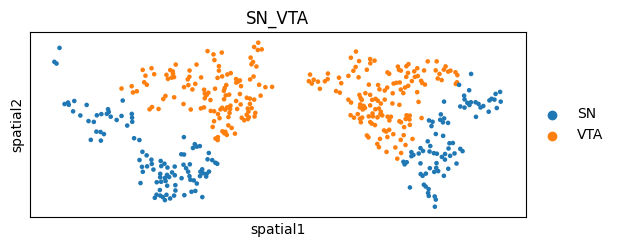

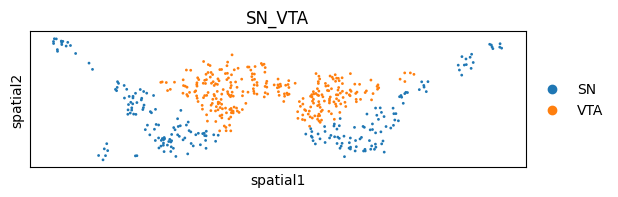

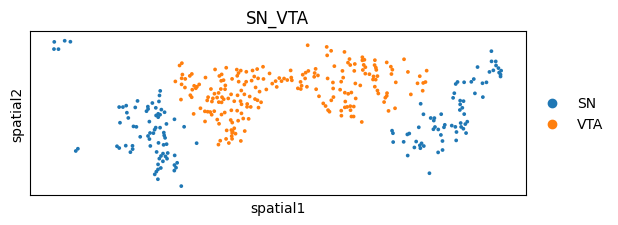

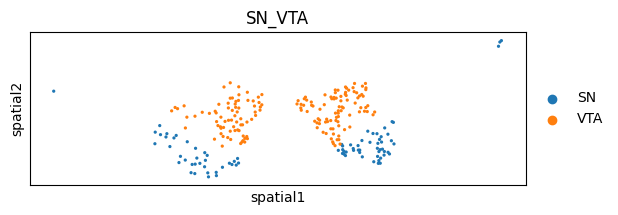

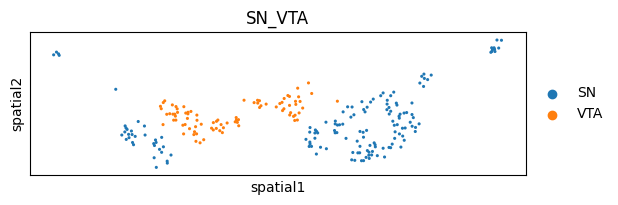

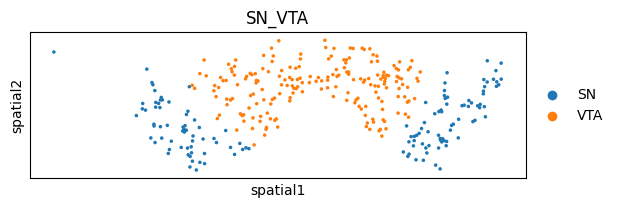

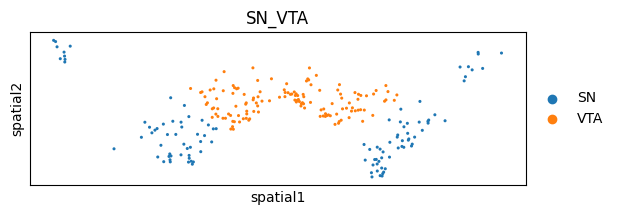

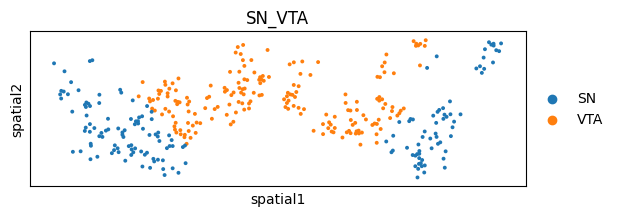

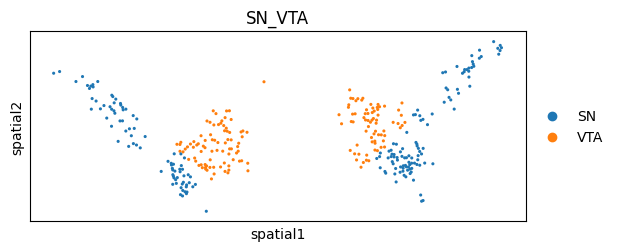

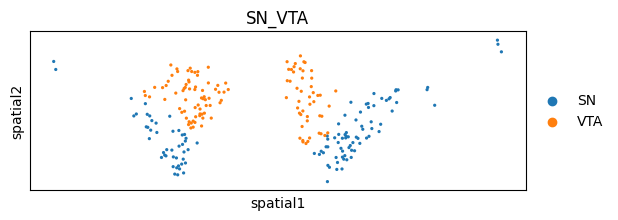

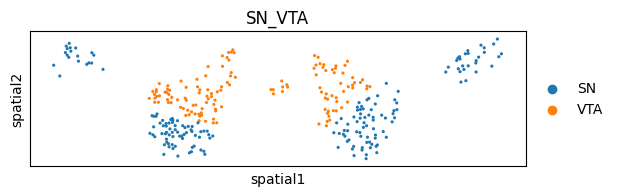

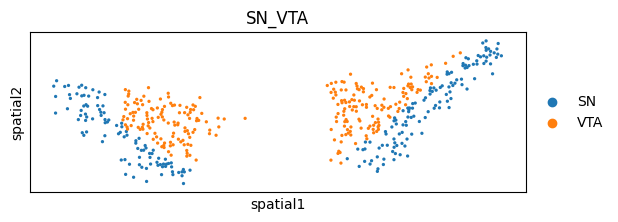

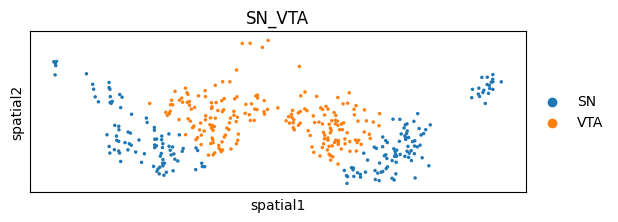

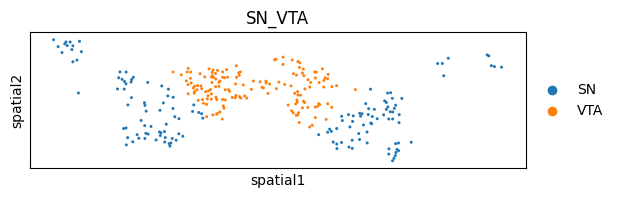

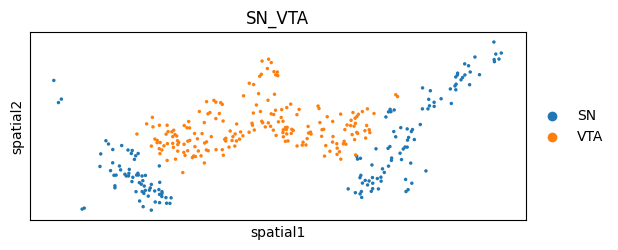

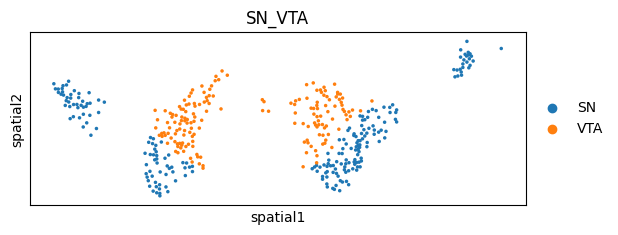

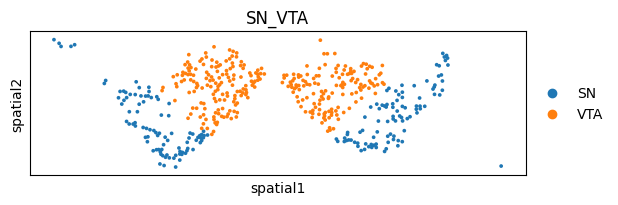

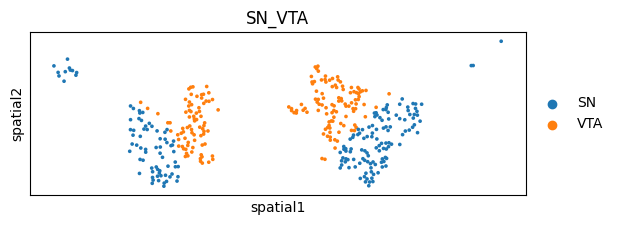

In [18]:
for k in d_adata_DA.keys():
    sc.pl.spatial(d_adata_DA[k], color = 'SN_VTA', spot_size = 50)

In [19]:
adata_DA.obs.groupby(['age', 'cell_type']).size()

age    cell_type
OLD    SN           1497
       VTA          1811
YOUNG  SN           1491
       VTA          1579
dtype: int64

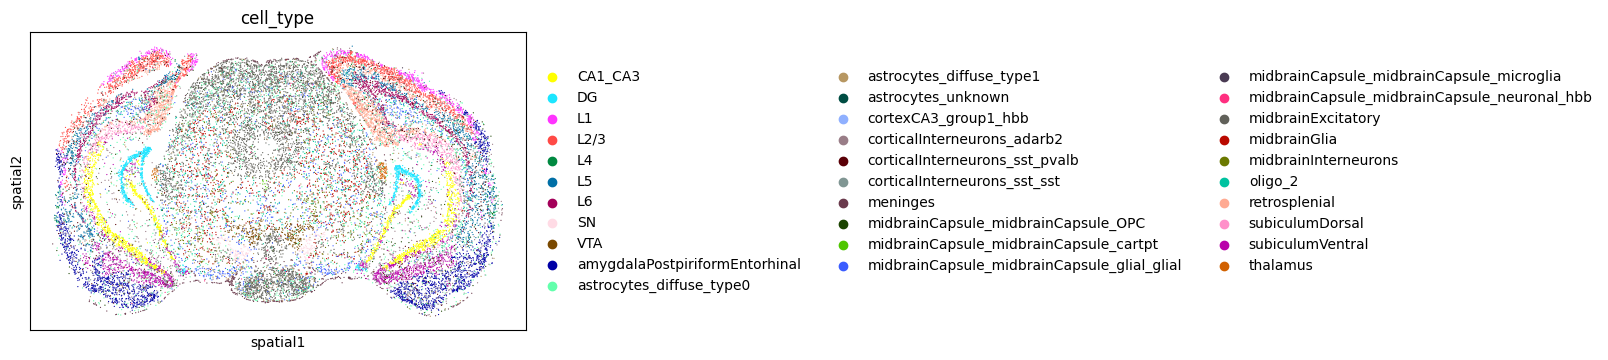

In [65]:
adata_temp = adata[adata.obs['sample_name'] == 'OLD_OVX_1', :].copy()
sc.pl.spatial(adata_temp, spot_size=50, color = 'cell_type')

In [99]:
del adata_temp

# Separate CA1 and CA3

In [ ]:
# adata = sc.read_h5ad('input/05_annotation/adata_post_SN_VTA_labelling.h5ad')

In [20]:
d_adata = {}

for count, x in enumerate(adata.obs['sample_name'].unique()):
    d_adata[x] = adata[adata.obs['sample_name'] == x,].copy()
    
d_adata_CA = {}

adata_CA = adata[adata.obs['cell_type'] == 'CA1_CA3', :].copy()

for count, x in enumerate(adata_DA.obs['sample_name'].unique()):
    d_adata_CA[x] = adata_CA[adata_CA.obs['sample_name'] == x,].copy()


In [77]:
os.makedirs('input/05_annotation/CA1_CA3_separation/')

for k,v in d_adata_CA.items():
    print(k)
    coords = v.obsm['spatial']
    row = coords[:, 0]
    col = coords[:, 1]
    data = np.arange(1, v.shape[0]+1)
    arr = csr_array((data, (row, col)), shape=(d_adata[k].obsm['spatial'][:,0].max(), d_adata[k].obsm['spatial'][:,1].max())).toarray()
    arr_bin = arr > 0
    arr_bin_dilated = morphology.binary_dilation(arr_bin, footprint=np.ones((20,20)))
    # arr_bin_dilated[0, 0] = True
    # arr_bin_dilated[arr_bin_dilated.shape[0], arr_bin_dilated.shape[1]] = True
    imwrite('input/05_annotation/CA1_CA3_separation/' + k + '_CA_binary.tif', arr_bin_dilated)

OLD_OVX_1
OLD_OVX_2
OLD_OVX_3
OLD_OVX_4
OLD_OVX_5
OLD_WT_1
OLD_WT_2
OLD_WT_3
OLD_WT_4
OLD_WT_5
YOUNG_OVX_1
YOUNG_OVX_2
YOUNG_OVX_3
YOUNG_OVX_4
YOUNG_WT_1
YOUNG_WT_2
YOUNG_WT_3
YOUNG_WT_4


In [21]:
def img_to_CA1_CA3(k):
    print(k)
    im = imread('input/05_annotation/CA1_CA3_separation/' + k + '_CA_binary_labelled.tif')
    im = np.array(im)

    val = [im[tuple(i)] for i in d_adata_CA[k].obsm['spatial']]
    val = ['CA3' if x == 255 else 'CA1' for x in val]
    
    x = dict(zip(d_adata_CA[k].obs_names, val))
    return(x)

from joblib import Parallel, delayed
cats = Parallel(n_jobs=18)(delayed(img_to_CA1_CA3)(k) for k in d_adata_CA.keys())
CA1_CA3 = {k: v for d in cats for k, v in d.items()}

adata.obs['CA1_CA3'] = 'NON_CA'
adata.obs['CA1_CA3'].update(CA1_CA3)
adata.obs['cell_type'] = adata.obs['cell_type'].astype('str')
adata.obs['cell_type'].update(CA1_CA3)

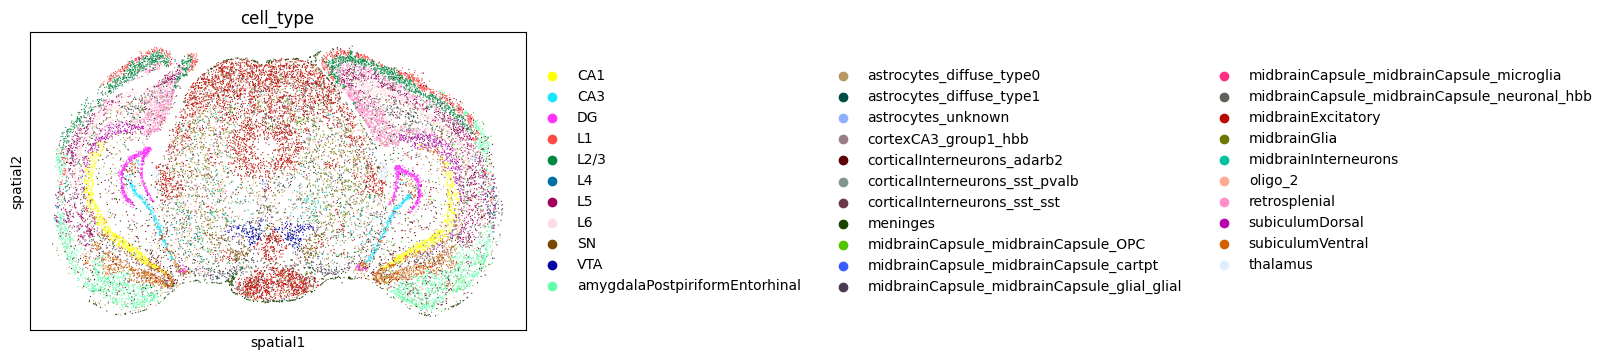

In [98]:
adata_temp = adata[adata.obs['sample_name'] == 'OLD_OVX_1', :].copy()
sc.pl.spatial(adata_temp, spot_size=50, color = 'cell_type')

In [99]:
del adata_temp

In [100]:
adata.obs.groupby('cell_type').size()

cell_type
CA1                                             24701
CA3                                              8401
DG                                              16159
L1                                              20143
L2/3                                            18164
L4                                               4051
L5                                              32049
L6                                              22004
SN                                               2988
VTA                                              3390
amygdalaPostpiriformEntorhinal                  24809
astrocytes_diffuse_type0                        15493
astrocytes_diffuse_type1                        12027
astrocytes_unknown                                131
cortexCA3_group1_hbb                              445
corticalInterneurons_adarb2                     10780
corticalInterneurons_sst_pvalb                   9828
corticalInterneurons_sst_sst                     9601
meninges          

# Remove unknown cell type(s)

In [22]:
adata = adata[adata.obs['cell_type'] != 'astrocytes_unknown', :].copy()

In [23]:
genes = ['Snap25', 'Plp1', 'Gpc5', 'Tyrobp', 'Mgp', 'Adarb2', 'Sst', 'Pvalb', 'Cartpt', 'Th', 'Gad1', 'Pdgfra', 'Hba-a1', 'Tshz2']
cts = pd.DataFrame(adata[:, genes].X.A, columns = genes, index=adata.obs_names).join(adata.obs)
cts.groupby('cell_type')[genes].mean()

Snap25       Plp1      Gpc5  \
cell_type                                                                     
CA1                                           2.711226   0.515769  0.188494   
CA3                                           4.116891   0.584097  0.084752   
DG                                            1.809270   0.342348  0.063865   
L1                                            2.708931   0.368366  0.074815   
L2/3                                          2.825644   0.607630  0.077296   
L4                                            3.706739   0.683041  0.203160   
L5                                            2.906237   0.938563  0.102874   
L6                                            2.879749   1.154699  0.059262   
SN                                            2.286479   2.669009  0.187082   
VTA                                           1.887316   2.901180  0.098230   
amygdalaPostpiriformEntorhinal                2.643960   0.382482  0.085896   
astrocytes_diffuse_type0                      0.767572   0.763635  2.791261   
astrocytes_diffuse_type1                      0.830548   3.266733  0.777251   
cortexCA3_group1_hbb                          3.274157   1.008989  0.060674   
corticalInterneurons_adarb2                   1.807885   0.641651  0.086178   
corticalInterneurons_sst_pvalb                2.614978   0.634208  0.072751   
corticalInterneurons_sst_sst                  2.268201   0.908030  0.082804   
meninges                                      0.445385   0.603386  0.187223   
midbrainCapsule_midbrainCapsule_OPC           0.749596   2.294727  0.953413   
midbrainCapsule_midbrainCapsule_cartpt        1.744898   1.887755  0.081633   
midbrainCapsule_midbrainCapsule_glial_glial   0.610717  14.584444  0.075049   
midbrainCapsule_midbrainCapsule_microglia     1.299675   2.397404  0.093040   
midbrainCapsule_midbrainCapsule_neuronal_hbb  2.160000   2.936774  0.256774   
midbrainExcitatory                            2.114903   1.159778  0.304866   
midbrainGlia                                  2.483702   2.000474  0.218835   
midbrainInterneurons                          4.718154   1.808096  0.197430   
oligo_2                                       0.756311   7.111877  0.049185   
retrosplenial                                 2.731236   1.214070  0.100322   
subiculumDorsal                               3.490896   1.197318  0.171348   
subiculumVentral                              2.051407   0.608718  0.127185   
thalamus                                      1.890236   1.989169  0.175396   

                                                Tyrobp       Mgp    Adarb2  \
cell_type                                                                    
CA1                                           0.065261  0.062427  0.054532   
CA3                                           0.070706  0.079871  0.067016   
DG                                            0.069249  0.054583  0.545888   
L1                                            0.051432  0.072581  0.074070   
L2/3                                          0.046576  0.054283  0.055439   
L4                                            0.065663  0.100963  0.063194   
L5                                            0.078442  0.107616  0.073356   
L6                                            0.072850  0.122705  0.047719   
SN                                            0.123159  0.097055  0.349732   
VTA                                           0.143953  0.107965  0.508260   
amygdalaPostpiriformEntorhinal                0.066468  0.094562  0.081059   
astrocytes_diffuse_type0                      0.047312  0.061705  0.057058   
astrocytes_diffuse_type1                      0.163133  0.087137  0.045814   
cortexCA3_group1_hbb                          0.125843  0.116854  0.076404   
corticalInterneurons_adarb2                   0.066234  0.082189  2.741187   
corticalInterneurons_sst_pvalb                0.072039  0.078348  0.070716   
corticalInterneurons_sst_sst        

In [138]:
# groups = ['astrocytes_diffuse_type0', 'astrocytes_diffuse_type1']
# groups = ['midbrainGlia', 'midbrainCapsule_midbrainCapsule_glial_glial']
groups = ['midbrainCapsule_midbrainCapsule_glial_glial', 'oligo_2']


adata_compare = adata[adata.obs['cell_type'].isin(groups), :].copy()
del adata_compare.uns['log1p']
adata_compare.X = adata_compare.layers['counts'].copy()
sc.pp.normalize_total(adata_compare, target_sum=1e4)
sc.pp.log1p(adata_compare)
sc.tl.rank_genes_groups(adata_compare, groupby='cell_type')
df = sc.get.rank_genes_groups_df(adata_compare, group = groups[0])
df

names     scores  logfoldchanges          pvals      pvals_adj
0          Trf  71.647675        2.418554   0.000000e+00   0.000000e+00
1      Gm20425  61.288139        2.119501   0.000000e+00   0.000000e+00
2         Apod  58.722923        1.986252   0.000000e+00   0.000000e+00
3         Fth1  56.565132        1.190989   0.000000e+00   0.000000e+00
4         Plp1  49.284897        1.027121   0.000000e+00   0.000000e+00
...        ...        ...             ...            ...            ...
14489    Lars2 -16.542681       -0.449962   4.137651e-61   4.135939e-59
14490    Plcl1 -17.422565       -0.750601   1.766973e-67   2.000820e-65
14491    Pde4b -17.680201       -0.753070   1.988322e-69   2.381714e-67
14492    Pex5l -18.727642       -0.795629   1.414113e-77   2.049615e-75
14493   Malat1 -32.332565       -0.730261  1.079139e-224  9.200609e-222

[14494 rows x 5 columns]

### Remove midbrainGlia and oligo_2 (neuronal)

In [24]:
adata = adata[adata.obs['cell_type'] != 'midbrainGlia', :].copy()

In [25]:
adata = adata[adata.obs['cell_type'] != 'oligo_2', :].copy()

### Test x against all else

In [152]:
del adata.uns['log1p']
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
x = 'DG'
sc.tl.rank_genes_groups(adata, groupby='cell_type', groups = [x], reference='rest')
df = sc.get.rank_genes_groups_df(adata, group = x)
df[:50]

names      scores  logfoldchanges  pvals  pvals_adj
0           Olfm1  106.572136        2.047065    0.0        0.0
1          Ppp3ca  100.921539        2.039052    0.0        0.0
2            Ncdn   88.138786        2.145891    0.0        0.0
3          Tmsb4x   78.684608        1.143144    0.0        0.0
4            Pcp4   75.437637        1.703959    0.0        0.0
5            Snca   68.829765        1.550654    0.0        0.0
6           Synpr   68.768799        2.880157    0.0        0.0
7            Rfx3   65.679535        2.837913    0.0        0.0
8          Zbtb20   63.612389        1.707899    0.0        0.0
9          Ppfia2   59.983414        2.127136    0.0        0.0
10          Igsf5   58.925278        1.691331    0.0        0.0
11          Ptk2b   56.634018        1.750417    0.0        0.0
12           Dgkh   54.310196        2.426282    0.0        0.0
13          Calb1   54.233807        1.858012    0.0        0.0
14         Camk2b   54.162731        1.576109    0.0        0.0
15          Rogdi   54.128693        1.773871    0.0        0.0
16          C1ql2   53.726009        4.245598    0.0        0.0
17         Ahcyl2   53.018181        2.230559    0.0        0.0
18        Rasl10a   52.497593        2.744732    0.0        0.0
19         Lrrtm4   52.407139        1.521174    0.0        0.0
20        Ppp1r1a   51.294170        1.718756    0.0        0.0
21          Prox1   50.715771        3.928367    0.0        0.0
22          Gria1   50.032791        1.344630    0.0        0.0
23         Stxbp6   49.998043        2.444396    0.0        0.0
24          Arpc2   49.731361        1.424560    0.0        0.0
25           Chn1   49.103367        1.189603    0.0        0.0
26  2010300C02Rik   48.661804        1.878494    0.0        0.0
27           Erc2   48.600086        1.393614    0.0        0.0
28         Eef1a1   47.038433        1.073929    0.0        0.0
29        Ccdc85a   47.013660        2.043352    0.0        0.0
30         Kcnip4   46.522457        1.204323    0.0        0.0
31          Glis3   46.390457        3.170507    0.0        0.0
32          Trpm3   45.897923        1.573582    0.0        0.0
33          Cplx2   45.442383        1.374890    0.0        0.0
34         Sema5a   45.186722        2.910735    0.0        0.0
35         Dock10   44.620354        2.452249    0.0        0.0
36         Map2k1   44.548279        1.533339    0.0        0.0
37          Limd2   44.540504        2.064084    0.0        0.0
38            Jun   44.527035        2.381106    0.0        0.0
39          Ctxn1   44.080112        1.183040    0.0        0.0
40          Epha7   43.824524        2.260537    0.0        0.0
41          Wipf3   43.760082        1.906826    0.0        0.0
42        Fam19a2   43.614105        1.720279    0.0        0.0
43          Maml2   42.970104        2.341367    0.0        0.0
44          Btbd9   42.968906        1.440357    0.0        0.0
45         Clstn2   42.826561        1.566704    0.0        0.0
46           Rpl3   42.615585        1.002373    0.0        0.0
47          Kctd4   42.457352        2.466365    0.0        0.0
48           Ryr2   41.880898        1.371362    0.0        0.0
49        Gm20754   41.822792        2.011664    0.0        0.0

In [26]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('str')
adata.obs.loc[adata.obs['cell_type'] == 'amygdalaPostpiriformEntorhinal', 'cell_type'] = 'AMYGDALA'
adata.obs.loc[adata.obs['cell_type'] == 'astrocytes_diffuse_type0', 'cell_type'] = 'ASTRO 1'
adata.obs.loc[adata.obs['cell_type'] == 'astrocytes_diffuse_type1', 'cell_type'] = 'ASTRO 2'
adata.obs.loc[adata.obs['cell_type'] == 'cortexCA3_group1_hbb', 'cell_type'] = 'CORTEX ERYTH'
adata.obs.loc[adata.obs['cell_type'] == 'corticalInterneurons_adarb2', 'cell_type'] = 'IN Adarb2+'
adata.obs.loc[adata.obs['cell_type'] == 'corticalInterneurons_sst_pvalb', 'cell_type'] = 'IN Pvalb+'
adata.obs.loc[adata.obs['cell_type'] == 'corticalInterneurons_sst_sst', 'cell_type'] = 'IN Sst+'
adata.obs.loc[adata.obs['cell_type'] == 'meninges', 'cell_type'] = 'MENINGES'
adata.obs.loc[adata.obs['cell_type'] == 'midbrainCapsule_midbrainCapsule_OPC', 'cell_type'] = 'OPC'
adata.obs.loc[adata.obs['cell_type'] == 'midbrainCapsule_midbrainCapsule_cartpt', 'cell_type'] = 'Cartpt+'
adata.obs.loc[adata.obs['cell_type'] == 'midbrainCapsule_midbrainCapsule_glial_glial', 'cell_type'] = 'OLIGO'
adata.obs.loc[adata.obs['cell_type'] == 'midbrainCapsule_midbrainCapsule_microglia', 'cell_type'] = 'MICROGLIA'
adata.obs.loc[adata.obs['cell_type'] == 'midbrainCapsule_midbrainCapsule_neuronal_hbb', 'cell_type'] = 'MB ERYTH'
adata.obs.loc[adata.obs['cell_type'] == 'midbrainExcitatory', 'cell_type'] = 'EX MB'
adata.obs.loc[adata.obs['cell_type'] == 'midbrainInterneurons', 'cell_type'] = 'IN MB'
adata.obs.loc[adata.obs['cell_type'] == 'retrosplenial', 'cell_type'] = 'CORTEX Tshz2+'
adata.obs.loc[adata.obs['cell_type'] == 'subiculumDorsal', 'cell_type'] = 'DORSAL SUBIC'
adata.obs.loc[adata.obs['cell_type'] == 'subiculumVentral', 'cell_type'] = 'VENTRAL SUBIC'
adata.obs.loc[adata.obs['cell_type'] == 'thalamus', 'cell_type'] = 'THALAMUS'
adata.obs.loc[adata.obs['cell_type'] == 'CA1', 'cell_type'] = 'EX CA1'
adata.obs.loc[adata.obs['cell_type'] == 'CA3', 'cell_type'] = 'EX CA3'
adata.obs.loc[adata.obs['cell_type'] == 'DG', 'cell_type'] = 'DG GRANULE'
adata.obs.loc[adata.obs['cell_type'] == 'L1', 'cell_type'] = 'EX L1'
adata.obs.loc[adata.obs['cell_type'] == 'L2/3', 'cell_type'] = 'EX L2/3'
adata.obs.loc[adata.obs['cell_type'] == 'L4', 'cell_type'] = 'EX L4'
adata.obs.loc[adata.obs['cell_type'] == 'L5', 'cell_type'] = 'EX L5'
adata.obs.loc[adata.obs['cell_type'] == 'L6', 'cell_type'] = 'EX L6'
adata.obs.loc[adata.obs['cell_type'] == 'SN', 'cell_type'] = 'DOPA SN'
adata.obs.loc[adata.obs['cell_type'] == 'VTA', 'cell_type'] = 'DOPA VTA'

In [157]:
adata.obs.groupby('cell_type').size()

cell_type
AMYGDALA         24809
ASTRO 1          15493
ASTRO 2          12027
CORTEX ERYTH       445
CORTEX Tshz2+    20185
Cartpt+            196
DG GRANULE       16159
DOPA SN           2988
DOPA VTA          3390
DORSAL SUBIC      7085
EX CA1           24701
EX CA3            8401
EX L1            20143
EX L2/3          18164
EX L4             4051
EX L5            32049
EX L6            22004
EX MB            32201
IN Adarb2+       10780
IN MB             7238
IN Pvalb+         9828
IN Sst+           9601
MB ERYTH           775
MENINGES          4962
MICROGLIA         2773
OLIGO            18308
OPC               3091
THALAMUS          6186
VENTRAL SUBIC    17274
dtype: int64

In [27]:
adata.obs.groupby('cell_type').size()

cell_type
AMYGDALA         24809
ASTRO 1          15493
ASTRO 2          12027
CORTEX ERYTH       445
CORTEX Tshz2+    20185
Cartpt+            196
DG GRANULE       16159
DOPA SN           2988
DOPA VTA          3390
DORSAL SUBIC      7085
EX CA1           24701
EX CA3            8401
EX L1            20143
EX L2/3          18164
EX L4             4051
EX L5            32049
EX L6            22004
EX MB            32201
IN Adarb2+       10780
IN MB             7238
IN Pvalb+         9828
IN Sst+           9601
MB ERYTH           775
MENINGES          4962
MICROGLIA         2773
OLIGO            18308
OPC               3091
THALAMUS          6186
VENTRAL SUBIC    17274
dtype: int64

OLD_OVX_1
YOUNG_WT_3
OLD_OVX_4
OLD_OVX_3
YOUNG_WT_4
YOUNG_OVX_4
OLD_OVX_2
OLD_OVX_5
OLD_WT_3
OLD_WT_2
YOUNG_WT_1
YOUNG_OVX_3
YOUNG_OVX_2
YOUNG_WT_2
YOUNG_OVX_1
OLD_WT_1
OLD_WT_4
OLD_WT_5


# Markers of each cell type

In [ ]:
del adata.uns['log1p']
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(adata, groupby = 'cell_type', key_added='markers')

In [160]:
df_l = {}

for c in adata.obs['cell_type'].unique():
    df_l[c] = sc.get.rank_genes_groups_df(adata, group=c, key='markers')

In [162]:
pd.concat(df_l)

names      scores  logfoldchanges  pvals  pvals_adj
EX L2/3 0        Ptprd   87.433884        2.299662    0.0        0.0
        1      Camk2n1   76.438751        1.624150    0.0        0.0
        2        Mef2c   70.230194        2.095777    0.0        0.0
        3         Nrg1   66.515442        2.012292    0.0        0.0
        4         Nrgn   64.502678        1.214421    0.0        0.0
...                ...         ...             ...    ...        ...
Cartpt+ 14489    Coq8a  -96.095787      -25.844593    0.0        0.0
        14490   Gpr155  -98.310097      -25.978228    0.0        0.0
        14491   Mgat5b -106.773972      -26.182327    0.0        0.0
        14492    Satb2 -111.072838      -26.425514    0.0        0.0
        14493     Sun1 -114.070015      -26.405727    0.0        0.0

[420326 rows x 5 columns]

In [348]:
df = pd.concat(df_l).reset_index().set_index('level_0').drop('level_1', axis = 1)
df.index.name = 'Cell Type'
df.to_csv('input/05_annotation/markers_per_cell_type.csv')

### Markers of DA neurons

In [355]:
adata.obs['DOPA'] = 'other'
adata.obs.loc[adata.obs['cell_type'].isin(['DOPA SN', 'DOPA VTA']), 'DOPA'] = 'DOPA'
adata.obs.groupby('DOPA').size()

DOPA
DOPA       6378
other    348929
dtype: int64

In [357]:
del adata.uns['log1p']
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(adata, groupby = 'DOPA', key_added='marker_DOPA')

In [359]:
df = sc.get.rank_genes_groups_df(adata, group='DOPA', key='marker_DOPA')
df.to_csv('input/05_annotation/da_markers.csv')

### Export obs

In [164]:
adata.obs.to_csv('input/05_annotation/spatial_all_cells.csv')

### Generate a UMAP for figure

In [28]:
adata.X = adata.layers['counts'].copy()

adata_plot = adata.copy()
    
sc.pp.highly_variable_genes(
    adata_plot,
    n_top_genes=5000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample_name",
    span = 1
)

scvi.model.SCVI.setup_anndata(adata_plot, 
                              layer="counts",
                              categorical_covariate_keys=['sample_name'],
                              continuous_covariate_keys=['n_genes_by_counts', 'area']
                             )
print('preparing SCVI model...')
model_scvi = scvi.model.SCVI(adata_plot)
model_scvi.train(early_stopping=True)

adata_plot.obsm["X_scVI"] = model_scvi.get_latent_representation()

sc.pp.neighbors(adata_plot, use_rep="X_scVI")

2023-11-10 11:48:05.924241: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-11-10 11:48:05.925092: E external/xla/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.104.12 does not match DSO version 535.129.3 -- cannot find working devices in this configuration


preparing SCVI model...


/home/peter/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/peter/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:651: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 23/23: 100%|███████████████████████████████████████████| 23/23 [28:23<00:00, 98.67s/it, v_num=1, train_loss_step=525, train_loss_epoch=503]

`Trainer.fit` stopped: `max_epochs=23` reached.


Epoch 23/23: 100%|███████████████████████████████████████████| 23/23 [28:23<00:00, 74.08s/it, v_num=1, train_loss_step=525, train_loss_epoch=503]


/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

In [29]:
sc.tl.umap(adata_plot, min_dist=0.1)


/home/peter/.local/lib/python3.10/site-packages/umap/spectral.py:348: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [63]:
df = pd.DataFrame(adata_plot.obsm['X_umap'], columns = ['UMAP 1', 'UMAP 2'], index=adata.obs_names)
df = df.join(adata.obs.loc[:, ['age', 'genotype', 'batch', 'sample_name']])
df.to_csv('input/05_annotation/umap_df.csv')

# Export annotated UMAP

In [173]:
adata.write_h5ad('input/05_annotation/adata_ANNOTATED.h5ad')

### Export counts for MAST DE testing in R

In [184]:
adata.X.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0]], dtype=uint16)

In [190]:
import scipy.io as sio
sio.mmwrite('input/05_annotation/counts/adata.mtx', adata.X.astype('int'))

# Export table of top markers per cell type

In [68]:
adata

AnnData object with n_obs × n_vars = 355307 × 14494
    obs: 'area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'x', 'y', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n', 'keep', 'x_orig', 'y_orig', 'cell_type', 'SN_VTA', 'CA1_CA3'
    uns: 'sample_name_colors'
    obsm: 'spatial'
    layers: 'counts'

### Export gene names for MAST DE testing in R

In [191]:
pd.DataFrame(adata.var_names).to_csv('input/05_annotation/counts/var_names.csv', index=False)

# Genotype Pseudobulk


In [41]:
import decoupler as dc

In [42]:
adata

AnnData object with n_obs × n_vars = 355307 × 14494
    obs: 'area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'x', 'y', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n', 'keep', 'x_orig', 'y_orig', 'cell_type', 'SN_VTA', 'CA1_CA3'
    uns: 'sample_name_colors'
    obsm: 'spatial'
    layers: 'counts'

In [43]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample_name',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pdata

AnnData object with n_obs × n_vars = 521 × 14494
    obs: 'outlier', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n', 'keep', 'cell_type', 'SN_VTA', 'CA1_CA3', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

### Export for distnance heatmap in R

In [51]:
pd.DataFrame(pdata.X, index=pdata.obs_names, columns = pdata.var_names).transpose().to_csv("input/05_annotation/pdata_counts.csv")

In [316]:
# adata_DA = adata[adata.obs['cell_type'].isin(['DOPA SN', 'DOPA VTA']), :].copy()
# adata_DA
# pp_pdata = pdata.copy()
# sc.pp.normalize_total(pp_pdata, target_sum=1e6)
# sc.pp.log1p(pp_pdata)
# sc.pp.scale(pp_pdata, max_value=10)
# sc.tl.pca(pp_pdata, n_comps=10)
# sc.pl.pca(pp_pdata, color=['age', 'cell_type'], ncols=2, show=True, size=300)


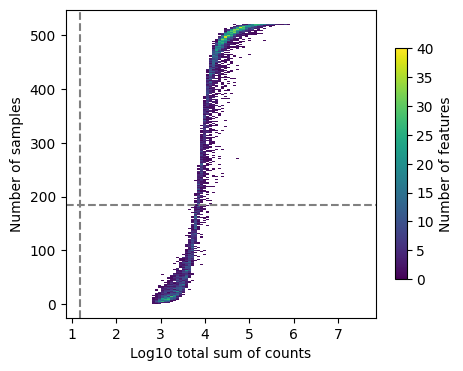

In [317]:
dc.plot_filter_by_expr(pdata, group='genotype', min_count=10, min_total_count=15)

In [318]:
# # Obtain genes that pass the thresholds
# genes = dc.filter_by_expr(pdata, group='genotype', min_count=10, min_total_count=15)
# # Filter by these genes
# pdata = pdata[:, genes].copy()
# pdata

In [319]:
d_res = {}

for ct in tqdm(pdata.obs['cell_type'].unique()):
    pdata_subset = pdata[pdata.obs['cell_type'] == ct, :].copy()
    # Obtain genes that pass the thresholds
    # genes = dc.filter_by_expr(pdata_subset, group='genotype', min_count=10, min_total_count=15)
    # Filter by these genes
    # pdata_subset = pdata_subset[:, genes].copy()
    # Build DESeq2 object
    dds = DeseqDataSet(
        adata=pdata_subset,
        # design_factors='age',
        # ref_level=['age', 'YOUNG'],
        design_factors='genotype',
        ref_level=['genotype', 'WT'],
        refit_cooks=True,
        n_cpus=16,
    )
    # Compute LFCs
    dds.deseq2()
    # Extract contrast between COVID-19 vs normal
    stat_res = DeseqStats(dds, contrast=["genotype", 'OVX', 'WT'], alpha = 0.1, 
                          independent_filter=True, n_cpus=16)
    # stat_res.lfc_shrink(coeff='age_OLD_vs_YOUNG')
    stat_res.summary()
    # Extract results
    d_res[ct] = stat_res.results_df

  0%|                                                                                                                      | 0/29 [00:00<?, ?it/s]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.48 seconds.

Fitting dispersion trend curve...
... done in 2.38 seconds.

Fitting MAP dispersions...
... done in 4.63 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   102.224525       -0.094621  0.155780 -0.607398  0.543587   
0610009O20Rik    30.453512       -0.223594  0.197919 -1.129726  0.258592   
0610010F05Rik    87.654083       -0.072244  0.159552 -0.452793  0.650697   
0610010K14Rik   118.362900        0.106712  0.153228  0.696427  0.486161   
0610012G03Rik   415.893188        0.016684  0.134586  0.123967  0.901341   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1386.483276       -0.105667  0.258636 -0.408554  0.682867   
mt-Nd3          126.544609       -0.093407  0.508706 -0.183617  0.854314   
mt-Nd4         3814.578613       -0.049051  0.356307 -0.137665  0.890505   
mt-Nd5          438.836792        0.004729  0.282143  0.016761  0.986627   
mt-Nd6          141.410919       -0.281100  0.278697 -1.008623  0.313155   

                   padj  
0610009B22Rik  0.999957  
0610009O20Rik  0.999957  
0610010F05Rik  0.999957  
0610010K14Rik  0.999957  
0610012G03Rik  0.999957  
...                 ...  
mt-Nd2         0.999957  
mt-Nd3         0.999957  
mt-Nd4         0.999957  
mt-Nd5         0.999957  
mt-Nd6         0.999957  

[14494 rows x 6 columns]

  3%|███▊                                                                                                          | 1/29 [00:19<09:07, 19.54s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.20 seconds.

Fitting dispersion trend curve...
... done in 2.25 seconds.

Fitting MAP dispersions...
... done in 4.35 seconds.

Fitting LFCs...
... done in 0.60 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.55 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    32.460312       -0.021990  0.214671 -0.102436  0.918411   
0610009O20Rik    13.478054       -0.243887  0.233038 -1.046558  0.295304   
0610010F05Rik    21.089787       -0.158864  0.143665 -1.105796  0.268815   
0610010K14Rik    28.051012       -0.005669  0.183227 -0.030940  0.975317   
0610012G03Rik    90.367645        0.202030  0.210781  0.958483  0.337819   
...                    ...             ...       ...       ...       ...   
mt-Nd2          421.596008       -0.056876  0.243318 -0.233753  0.815177   
mt-Nd3           34.380875       -0.624669  0.526533 -1.186380  0.235472   
mt-Nd4         1173.238525       -0.048382  0.375526 -0.128837  0.897487   
mt-Nd5          145.504242       -0.075088  0.275260 -0.272791  0.785014   
mt-Nd6           35.341522        0.111221  0.328836  0.338226  0.735193   

                   padj  
0610009B22Rik  0.999702  
0610009O20Rik  0.999702  
0610010F05Rik  0.999702  
0610010K14Rik  0.999702  
0610012G03Rik  0.999702  
...                 ...  
mt-Nd2         0.999702  
mt-Nd3         0.999702  
mt-Nd4         0.999702  
mt-Nd5         0.999702  
mt-Nd6         0.999702  

[14494 rows x 6 columns]

  7%|███████▌                                                                                                      | 2/29 [00:32<07:06, 15.80s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.01 seconds.

Fitting dispersion trend curve...
... done in 2.27 seconds.

Fitting MAP dispersions...
... done in 4.81 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 4 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.45 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    30.365631       -0.349739  0.205137 -1.704906  0.088212   
0610009O20Rik    10.553425       -0.149350  0.291207 -0.512865  0.608045   
0610010F05Rik    14.989175       -0.114601  0.315443 -0.363303  0.716378   
0610010K14Rik    35.943287       -0.179838  0.225857 -0.796247  0.425888   
0610012G03Rik    91.276695        0.090122  0.175330  0.514011  0.607244   
...                    ...             ...       ...       ...       ...   
mt-Nd2          460.568909       -0.075916  0.226495 -0.335175  0.737493   
mt-Nd3           35.022083       -0.221637  0.525288 -0.421934  0.673074   
mt-Nd4         1277.024170       -0.126260  0.349481 -0.361280  0.717890   
mt-Nd5          143.950943       -0.144134  0.243737 -0.591353  0.554284   
mt-Nd6           36.941483       -0.326399  0.329192 -0.991514  0.321435   

                   padj  
0610009B22Rik  0.999957  
0610009O20Rik  0.999957  
0610010F05Rik  0.999957  
0610010K14Rik  0.999957  
0610012G03Rik  0.999957  
...                 ...  
mt-Nd2         0.999957  
mt-Nd3         0.999957  
mt-Nd4         0.999957  
mt-Nd5         0.999957  
mt-Nd6         0.999957  

[14494 rows x 6 columns]

 10%|███████████▍                                                                                                  | 3/29 [00:45<06:15, 14.46s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.05 seconds.

Fitting dispersion trend curve...
... done in 2.54 seconds.

Fitting MAP dispersions...
... done in 2.31 seconds.

Fitting LFCs...
... done in 0.67 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 1.01 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   1.711369       -1.181939  0.544773 -2.169599  0.030037   
0610009O20Rik   0.338938        1.090821  1.683863  0.647808  0.517109   
0610010F05Rik   1.413391        0.024627  0.796885  0.030904  0.975346   
0610010K14Rik   2.747372        0.599486  0.524908  1.142077  0.253422   
0610012G03Rik   6.512804        0.252444  0.397241  0.635493  0.525107   
...                  ...             ...       ...       ...       ...   
mt-Nd2         28.849792       -0.070378  0.266931 -0.263658  0.792044   
mt-Nd3          2.280375        0.184632  0.753885  0.244907  0.806528   
mt-Nd4         70.546555       -0.090553  0.415023 -0.218188  0.827283   
mt-Nd5          7.548429        0.164655  0.472051  0.348807  0.727234   
mt-Nd6          2.345532        0.048600  0.628674  0.077305  0.938381   

                   padj  
0610009B22Rik  0.999762  
0610009O20Rik  0.999762  
0610010F05Rik  0.999762  
0610010K14Rik  0.999762  
0610012G03Rik  0.999762  
...                 ...  
mt-Nd2         0.999762  
mt-Nd3         0.999762  
mt-Nd4         0.999762  
mt-Nd5         0.999762  
mt-Nd6         0.999762  

[14494 rows x 6 columns]

 14%|███████████████▏                                                                                              | 4/29 [00:55<05:19, 12.79s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.52 seconds.

Fitting dispersion trend curve...
... done in 2.22 seconds.

Fitting MAP dispersions...
... done in 4.34 seconds.

Fitting LFCs...
... done in 0.53 seconds.

Refitting 2 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.45 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    61.172623       -0.078748  0.174871 -0.450319  0.652481   
0610009O20Rik    24.352829        0.138398  0.207405  0.667285  0.504590   
0610010F05Rik    70.190674        0.052922  0.127831  0.414003  0.678872   
0610010K14Rik    80.235611       -0.142359  0.176029 -0.808727  0.418672   
0610012G03Rik   234.014755        0.027743  0.129996  0.213417  0.831002   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1055.417480        0.022511  0.257750  0.087335  0.930405   
mt-Nd3           78.501434       -0.215908  0.553715 -0.389925  0.696592   
mt-Nd4         2801.211182        0.010268  0.378693  0.027115  0.978368   
mt-Nd5          338.372162       -0.001567  0.323588 -0.004844  0.996135   
mt-Nd6           84.362511       -0.194554  0.291668 -0.667040  0.504747   

                   padj  
0610009B22Rik  0.999691  
0610009O20Rik  0.999691  
0610010F05Rik  0.999691  
0610010K14Rik  0.999691  
0610012G03Rik  0.999691  
...                 ...  
mt-Nd2         0.999691  
mt-Nd3         0.999691  
mt-Nd4         0.999691  
mt-Nd5         0.999691  
mt-Nd6         0.999691  

[14494 rows x 6 columns]

 17%|██████████████████▉                                                                                           | 5/29 [01:08<05:07, 12.80s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.74 seconds.

Fitting dispersion trend curve...
... done in 2.99 seconds.

Fitting MAP dispersions...
... done in 1.86 seconds.

Fitting LFCs...
... done in 0.66 seconds.

Refitting 1 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   0.881884        0.533419  1.169303  0.456185  0.648257   
0610009O20Rik   0.301822       -0.526469  2.122552 -0.248036  0.804106   
0610010F05Rik   1.209067       -0.543718  1.002846 -0.542175  0.587698   
0610010K14Rik   0.709345       -2.326958  1.149992 -2.023457  0.043026   
0610012G03Rik   4.041072        0.019806  0.317692  0.062342  0.950291   
...                  ...             ...       ...       ...       ...   
mt-Nd2         15.187225       -0.245343  0.402169 -0.610049  0.541829   
mt-Nd3          1.094884       -0.457264  1.079751 -0.423490  0.671938   
mt-Nd4         34.266186       -0.355301  0.317872 -1.117751  0.263673   
mt-Nd5          3.874295       -0.168596  0.547567 -0.307901  0.758158   
mt-Nd6          0.738643       -0.253224  1.011107 -0.250442  0.802245   

                  padj  
0610009B22Rik  0.99969  
0610009O20Rik  0.99969  
0610010F05Rik  0.99969  
0610010K14Rik  0.99969  
0610012G03Rik  0.99969  
...                ...  
mt-Nd2         0.99969  
mt-Nd3         0.99969  
mt-Nd4         0.99969  
mt-Nd5         0.99969  
mt-Nd6         0.99969  

[14494 rows x 6 columns]

 21%|██████████████████████▊                                                                                       | 6/29 [01:18<04:30, 11.74s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.30 seconds.

Fitting dispersion trend curve...
... done in 2.15 seconds.

Fitting MAP dispersions...
... done in 4.31 seconds.

Fitting LFCs...
... done in 1.09 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
0610009B22Rik    67.200836       -0.112644  0.128270 -0.878180  0.379846   1.0
0610009O20Rik    21.801912       -0.126088  0.188671 -0.668297  0.503944   1.0
0610010F05Rik    44.738411        0.065975  0.239110  0.275918  0.782611   1.0
0610010K14Rik   103.788048        0.153398  0.182303  0.841447  0.400098   1.0
0610012G03Rik   267.681274        0.055662  0.176505  0.315353  0.752493   1.0
...                    ...             ...       ...       ...       ...   ...
mt-Nd2          596.679932       -0.025712  0.228277 -0.112634  0.910321   1.0
mt-Nd3           59.069416       -0.497584  0.481169 -1.034115  0.301083   1.0
mt-Nd4         1822.156250       -0.020659  0.325239 -0.063521  0.949352   1.0
mt-Nd5          196.704819        0.060386  0.262175  0.230326  0.817839   1.0
mt-Nd6           38.246616       -0.312127  0.308152 -1.012899  0.311108   1.0

[14494 rows x 6 columns]

 24%|██████████████████████████▌                                                                                   | 7/29 [01:31<04:28, 12.18s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.83 seconds.

Fitting dispersion trend curve...
... done in 2.29 seconds.

Fitting MAP dispersions...
... done in 3.53 seconds.

Fitting LFCs...
... done in 0.58 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   18.204031        0.622259  0.222567  2.795834  0.005177   
0610009O20Rik    3.259156        0.229854  0.459194  0.500559  0.616682   
0610010F05Rik   11.504332        0.058020  0.337498  0.171912  0.863507   
0610010K14Rik   13.668774        0.212260  0.354130  0.599383  0.548917   
0610012G03Rik   55.929485        0.033955  0.156159  0.217437  0.827868   
...                   ...             ...       ...       ...       ...   
mt-Nd2         204.950256       -0.177081  0.225811 -0.784200  0.432923   
mt-Nd3          17.688969        0.064926  0.401113  0.161864  0.871413   
mt-Nd4         572.566772       -0.049705  0.275655 -0.180317  0.856904   
mt-Nd5          62.940411        0.254302  0.226206  1.124208  0.260925   
mt-Nd6          19.444765       -0.345381  0.345001 -1.001100  0.316778   

                   padj  
0610009B22Rik  0.999928  
0610009O20Rik  0.999928  
0610010F05Rik  0.999928  
0610010K14Rik  0.999928  
0610012G03Rik  0.999928  
...                 ...  
mt-Nd2         0.999928  
mt-Nd3         0.999928  
mt-Nd4         0.999928  
mt-Nd5         0.999928  
mt-Nd6         0.999928  

[14494 rows x 6 columns]

 28%|██████████████████████████████▎                                                                               | 8/29 [01:42<04:10, 11.93s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.83 seconds.

Fitting dispersion trend curve...
... done in 2.26 seconds.

Fitting MAP dispersions...
... done in 3.56 seconds.

Fitting LFCs...
... done in 0.60 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   17.184309        0.127716  0.284800  0.448443  0.653834   
0610009O20Rik    3.017842       -0.447669  0.525050 -0.852622  0.393869   
0610010F05Rik   11.188930        0.142984  0.251251  0.569090  0.569295   
0610010K14Rik   15.029633        0.005572  0.283951  0.019623  0.984344   
0610012G03Rik   49.104866       -0.053349  0.153256 -0.348104  0.727762   
...                   ...             ...       ...       ...       ...   
mt-Nd2         178.711670       -0.068675  0.229378 -0.299396  0.764638   
mt-Nd3          16.912218       -0.039624  0.589959 -0.067164  0.946451   
mt-Nd4         523.879150       -0.095393  0.244701 -0.389834  0.696660   
mt-Nd5          57.802246       -0.160324  0.213411 -0.751248  0.452504   
mt-Nd6          18.745155       -0.177660  0.428805 -0.414314  0.678644   

                  padj  
0610009B22Rik  0.99957  
0610009O20Rik  0.99957  
0610010F05Rik  0.99957  
0610010K14Rik  0.99957  
0610012G03Rik  0.99957  
...                ...  
mt-Nd2         0.99957  
mt-Nd3         0.99957  
mt-Nd4         0.99957  
mt-Nd5         0.99957  
mt-Nd6         0.99957  

[14494 rows x 6 columns]

 31%|██████████████████████████████████▏                                                                           | 9/29 [01:54<03:55, 11.76s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.31 seconds.

Fitting dispersion trend curve...
... done in 2.46 seconds.

Fitting MAP dispersions...
... done in 4.15 seconds.

Fitting LFCs...
... done in 0.57 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.46 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    36.574905       -0.098695  0.173756 -0.568007  0.570030   
0610009O20Rik     7.355407       -0.389213  0.284631 -1.367430  0.171491   
0610010F05Rik    32.069962       -0.031241  0.201171 -0.155294  0.876590   
0610010K14Rik    33.083477        0.225889  0.181873  1.242010  0.214233   
0610012G03Rik   130.216934        0.199241  0.169700  1.174077  0.240364   
...                    ...             ...       ...       ...       ...   
mt-Nd2          460.316284       -0.050919  0.219730 -0.231734  0.816744   
mt-Nd3           39.964954       -0.330523  0.571114 -0.578735  0.562768   
mt-Nd4         1284.330322       -0.018935  0.336938 -0.056197  0.955185   
mt-Nd5          144.998489        0.182571  0.273805  0.666792  0.504905   
mt-Nd6           38.605507       -0.505284  0.282753 -1.787016  0.073935   

                   padj  
0610009B22Rik  0.999657  
0610009O20Rik  0.999657  
0610010F05Rik  0.999657  
0610010K14Rik  0.999657  
0610012G03Rik  0.999657  
...                 ...  
mt-Nd2         0.999657  
mt-Nd3         0.999657  
mt-Nd4         0.999657  
mt-Nd5         0.999657  
mt-Nd6         0.999657  

[14494 rows x 6 columns]

 34%|█████████████████████████████████████▌                                                                       | 10/29 [02:07<03:51, 12.20s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.60 seconds.

Fitting dispersion trend curve...
... done in 2.28 seconds.

Fitting MAP dispersions...
... done in 4.65 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.52 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   136.344696        0.071418  0.122501  0.583001  0.559893   
0610009O20Rik    28.028418       -0.125937  0.192577 -0.653955  0.513141   
0610010F05Rik    97.466286        0.098292  0.111169  0.884161  0.376610   
0610010K14Rik   116.493805        0.108700  0.193094  0.562939  0.573476   
0610012G03Rik   422.952179        0.071619  0.131507  0.544600  0.586029   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1296.619629       -0.084977  0.227665 -0.373256  0.708958   
mt-Nd3          127.416206       -0.116953  0.521518 -0.224254  0.822560   
mt-Nd4         3583.588379       -0.005647  0.349173 -0.016172  0.987097   
mt-Nd5          395.497162        0.088804  0.267652  0.331788  0.740049   
mt-Nd6          110.494415       -0.336188  0.273549 -1.228984  0.219078   

                   padj  
0610009B22Rik  0.998272  
0610009O20Rik  0.998272  
0610010F05Rik  0.998272  
0610010K14Rik  0.998272  
0610012G03Rik  0.998272  
...                 ...  
mt-Nd2         0.998272  
mt-Nd3         0.998272  
mt-Nd4         0.999536  
mt-Nd5         0.998272  
mt-Nd6         0.998272  

[14494 rows x 6 columns]

 38%|█████████████████████████████████████████▎                                                                   | 11/29 [02:20<03:45, 12.53s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.37 seconds.

Fitting dispersion trend curve...
... done in 2.13 seconds.

Fitting MAP dispersions...
... done in 4.14 seconds.

Fitting LFCs...
... done in 1.15 seconds.

Refitting 2 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

/home/peter/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/peter/.local/lib/python3.10/site-packages/numpy/core/_methods.py:182: Runtim

Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    47.315895        0.063860  0.180791  0.353223  0.723921   
0610009O20Rik     9.391420       -0.355504  0.358141 -0.992635  0.320888   
0610010F05Rik    31.693977       -0.104020  0.198251 -0.524689  0.599799   
0610010K14Rik    32.609234       -0.265177  0.184242 -1.439286  0.150070   
0610012G03Rik   131.328613       -0.033964  0.135821 -0.250067  0.802536   
...                    ...             ...       ...       ...       ...   
mt-Nd2          417.161011       -0.117816  0.199842 -0.589546  0.555495   
mt-Nd3           36.693027       -0.370304  0.542921 -0.682060  0.495201   
mt-Nd4         1057.823120       -0.073844  0.299933 -0.246201  0.805527   
mt-Nd5          125.267822        0.058608  0.209362  0.279933  0.779529   
mt-Nd6           26.965364       -0.356670  0.284525 -1.253566  0.210000   

                   padj  
0610009B22Rik  0.999662  
0610009O20Rik  0.999662  
0610010F05Rik  0.999662  
0610010K14Rik  0.999662  
0610012G03Rik  0.999662  
...                 ...  
mt-Nd2         0.999662  
mt-Nd3         0.999662  
mt-Nd4         0.999662  
mt-Nd5         0.999662  
mt-Nd6         0.999662  

[14494 rows x 6 columns]

 41%|█████████████████████████████████████████████                                                                | 12/29 [02:38<04:02, 14.27s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.50 seconds.

Fitting dispersion trend curve...
... done in 2.18 seconds.

Fitting MAP dispersions...
... done in 4.56 seconds.

Fitting LFCs...
... done in 0.54 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    61.382595        0.084951  0.221852  0.382919  0.701780   
0610009O20Rik    21.134445        0.094467  0.236227  0.399898  0.689231   
0610010F05Rik    61.044250        0.127838  0.166948  0.765738  0.443832   
0610010K14Rik    77.172493        0.203157  0.173623  1.170106  0.241958   
0610012G03Rik   248.313904        0.190151  0.148640  1.279269  0.200803   
...                    ...             ...       ...       ...       ...   
mt-Nd2          857.377869       -0.028774  0.229263 -0.125507  0.900122   
mt-Nd3           72.539764       -0.159530  0.545438 -0.292480  0.769920   
mt-Nd4         2335.769531        0.010018  0.410159  0.024424  0.980514   
mt-Nd5          290.677979        0.008776  0.345674  0.025389  0.979745   
mt-Nd6           75.105743       -0.226504  0.355350 -0.637410  0.523858   

                   padj  
0610009B22Rik  0.998482  
0610009O20Rik  0.998482  
0610010F05Rik  0.998482  
0610010K14Rik  0.998482  
0610012G03Rik  0.998482  
...                 ...  
mt-Nd2         0.998482  
mt-Nd3         0.998482  
mt-Nd4         0.998482  
mt-Nd5         0.998482  
mt-Nd6         0.998482  

[14494 rows x 6 columns]

 45%|████████████████████████████████████████████████▊                                                            | 13/29 [02:51<03:41, 13.87s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.42 seconds.

Fitting dispersion trend curve...
... done in 2.15 seconds.

Fitting MAP dispersions...
... done in 4.43 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    36.974445       -0.120700  0.200954 -0.600637  0.548082   
0610009O20Rik    20.100096        0.237418  0.177482  1.337701  0.180994   
0610010F05Rik    56.262302        0.146633  0.120211  1.219791  0.222544   
0610010K14Rik    54.363010       -0.124504  0.192918 -0.645370  0.518688   
0610012G03Rik   152.585876        0.109461  0.115235  0.949899  0.342164   
...                    ...             ...       ...       ...       ...   
mt-Nd2          715.648193       -0.055551  0.272202 -0.204082  0.838290   
mt-Nd3           52.216835       -0.014788  0.566296 -0.026114  0.979166   
mt-Nd4         1967.991333        0.021458  0.420918  0.050978  0.959343   
mt-Nd5          249.218018       -0.012158  0.321206 -0.037851  0.969806   
mt-Nd6           56.888157       -0.374215  0.316895 -1.180877  0.237652   

                   padj  
0610009B22Rik  0.999319  
0610009O20Rik  0.999319  
0610010F05Rik  0.999319  
0610010K14Rik  0.999319  
0610012G03Rik  0.999319  
...                 ...  
mt-Nd2         0.999319  
mt-Nd3         0.999686  
mt-Nd4         0.999348  
mt-Nd5         0.999575  
mt-Nd6         0.999319  

[14494 rows x 6 columns]

 48%|████████████████████████████████████████████████████▌                                                        | 14/29 [03:04<03:22, 13.52s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.05 seconds.

Fitting dispersion trend curve...
... done in 2.13 seconds.

Fitting MAP dispersions...
... done in 4.00 seconds.

Fitting LFCs...
... done in 0.63 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    9.028181        0.197445  0.443175  0.445523  0.655942   
0610009O20Rik    3.733125        0.081739  0.456195  0.179175  0.857800   
0610010F05Rik   11.616488       -0.300029  0.301679 -0.994530  0.319965   
0610010K14Rik    9.934223       -0.146639  0.270798 -0.541506  0.588159   
0610012G03Rik   34.875847        0.169520  0.118809  1.426828  0.153630   
...                   ...             ...       ...       ...       ...   
mt-Nd2         158.481903       -0.026646  0.220461 -0.120866  0.903797   
mt-Nd3          10.165817        0.139402  0.662569  0.210397  0.833358   
mt-Nd4         426.436096       -0.049316  0.348371 -0.141562  0.887426   
mt-Nd5          46.789200        0.065504  0.256959  0.254922  0.798784   
mt-Nd6          12.702037       -0.419983  0.397807 -1.055745  0.291085   

                   padj  
0610009B22Rik  0.999897  
0610009O20Rik  0.999897  
0610010F05Rik  0.999897  
0610010K14Rik  0.999897  
0610012G03Rik  0.999897  
...                 ...  
mt-Nd2         0.999897  
mt-Nd3         0.999897  
mt-Nd4         0.999897  
mt-Nd5         0.999897  
mt-Nd6         0.999897  

[14494 rows x 6 columns]

 52%|████████████████████████████████████████████████████████▍                                                    | 15/29 [03:16<03:02, 13.06s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.63 seconds.

Fitting dispersion trend curve...
... done in 2.23 seconds.

Fitting MAP dispersions...
... done in 4.74 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Refitting 2 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.46 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   126.263824        0.178806  0.194975  0.917069  0.359107   
0610009O20Rik    36.709694       -0.252694  0.200690 -1.259125  0.207985   
0610010F05Rik   131.799622       -0.018268  0.130809 -0.139655  0.888932   
0610010K14Rik   150.664383        0.100468  0.138059  0.727716  0.466787   
0610012G03Rik   485.002930        0.120725  0.124492  0.969740  0.332176   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1804.724365       -0.098065  0.222063 -0.441608  0.658773   
mt-Nd3          158.548508       -0.100010  0.563954 -0.177337  0.859244   
mt-Nd4         4949.068848        0.010372  0.374923  0.027665  0.977929   
mt-Nd5          571.887817        0.014128  0.310010  0.045573  0.963651   
mt-Nd6          167.062393       -0.249019  0.271946 -0.915694  0.359828   

                   padj  
0610009B22Rik  0.999923  
0610009O20Rik  0.999923  
0610010F05Rik  0.999923  
0610010K14Rik  0.999923  
0610012G03Rik  0.999923  
...                 ...  
mt-Nd2         0.999923  
mt-Nd3         0.999923  
mt-Nd4         0.999923  
mt-Nd5         0.999923  
mt-Nd6         0.999923  

[14494 rows x 6 columns]

 55%|████████████████████████████████████████████████████████████▏                                                | 16/29 [03:29<02:50, 13.14s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.51 seconds.

Fitting dispersion trend curve...
... done in 2.15 seconds.

Fitting MAP dispersions...
... done in 4.39 seconds.

Fitting LFCs...
... done in 1.09 seconds.

Refitting 3 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    81.896111        0.015510  0.151693  0.102245  0.918562   
0610009O20Rik    28.212339        0.071747  0.207015  0.346578  0.728908   
0610010F05Rik    88.416664       -0.070874  0.157635 -0.449607  0.652994   
0610010K14Rik   105.011246        0.039969  0.155035  0.257804  0.796558   
0610012G03Rik   310.436768        0.029013  0.136980  0.211803  0.832261   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1147.040771        0.007466  0.252946  0.029515  0.976454   
mt-Nd3           97.732430       -0.283388  0.519598 -0.545398  0.585480   
mt-Nd4         3037.876221       -0.004480  0.375412 -0.011934  0.990478   
mt-Nd5          360.818359       -0.029467  0.288921 -0.101989  0.918765   
mt-Nd6           95.013756       -0.219978  0.249961 -0.880047  0.378834   

                   padj  
0610009B22Rik  0.999493  
0610009O20Rik  0.999493  
0610010F05Rik  0.999493  
0610010K14Rik  0.999493  
0610012G03Rik  0.999493  
...                 ...  
mt-Nd2         0.999493  
mt-Nd3         0.999493  
mt-Nd4         0.999493  
mt-Nd5         0.999493  
mt-Nd6         0.999493  

[14494 rows x 6 columns]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17/29 [03:43<02:38, 13.21s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.64 seconds.

Fitting dispersion trend curve...
... done in 2.18 seconds.

Fitting MAP dispersions...
... done in 4.86 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Refitting 2 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    93.214851       -0.120178  0.147037 -0.817333  0.413738   
0610009O20Rik    21.618227        0.126999  0.147169  0.862943  0.388169   
0610010F05Rik    86.238464       -0.111454  0.108520 -1.027034  0.304405   
0610010K14Rik    84.627502       -0.007139  0.109329 -0.065301  0.947935   
0610012G03Rik   238.169220       -0.070644  0.111285 -0.634809  0.525553   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1090.661377       -0.039389  0.214913 -0.183278  0.854580   
mt-Nd3           81.562050       -0.132718  0.480375 -0.276281  0.782332   
mt-Nd4         2946.604980       -0.020484  0.309723 -0.066137  0.947269   
mt-Nd5          342.280090        0.026562  0.214421  0.123875  0.901414   
mt-Nd6           92.984070       -0.156621  0.286152 -0.547337  0.584147   

                   padj  
0610009B22Rik  0.999702  
0610009O20Rik  0.999702  
0610010F05Rik  0.999702  
0610010K14Rik  0.999702  
0610012G03Rik  0.999702  
...                 ...  
mt-Nd2         0.999702  
mt-Nd3         0.999702  
mt-Nd4         0.999702  
mt-Nd5         0.999702  
mt-Nd6         0.999702  

[14494 rows x 6 columns]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18/29 [04:02<02:45, 15.08s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.14 seconds.

Fitting dispersion trend curve...
... done in 2.23 seconds.

Fitting MAP dispersions...
... done in 4.18 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    44.532448        0.169121  0.184511  0.916592  0.359357   
0610009O20Rik    10.470914       -0.131655  0.279547 -0.470958  0.637671   
0610010F05Rik    31.764112        0.052462  0.192421  0.272642  0.785128   
0610010K14Rik    43.476509        0.096841  0.201156  0.481421  0.630218   
0610012G03Rik   139.574509        0.098336  0.164339  0.598375  0.549590   
...                    ...             ...       ...       ...       ...   
mt-Nd2          498.147339       -0.059724  0.260986 -0.228841  0.818992   
mt-Nd3           48.764324       -0.130961  0.545595 -0.240033  0.810305   
mt-Nd4         1384.967529       -0.043829  0.367824 -0.119157  0.905151   
mt-Nd5          156.837997       -0.056652  0.282763 -0.200352  0.841206   
mt-Nd6           44.720531       -0.161963  0.281328 -0.575708  0.564812   

                   padj  
0610009B22Rik  0.999809  
0610009O20Rik  0.999809  
0610010F05Rik  0.999809  
0610010K14Rik  0.999809  
0610012G03Rik  0.999809  
...                 ...  
mt-Nd2         0.999809  
mt-Nd3         0.999809  
mt-Nd4         0.999809  
mt-Nd5         0.999809  
mt-Nd6         0.999809  

[14494 rows x 6 columns]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 19/29 [04:14<02:22, 14.24s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.36 seconds.

Fitting dispersion trend curve...
... done in 2.40 seconds.

Fitting MAP dispersions...
... done in 4.09 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 1 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    44.551376       -0.154905  0.188141 -0.823343  0.410313   
0610009O20Rik    10.698610       -0.091365  0.314065 -0.290911  0.771119   
0610010F05Rik    39.527424        0.173255  0.142597  1.214994  0.224368   
0610010K14Rik    36.953835        0.111460  0.161236  0.691283  0.489388   
0610012G03Rik   122.407928        0.053652  0.154091  0.348183  0.727703   
...                    ...             ...       ...       ...       ...   
mt-Nd2          616.539429       -0.168790  0.242568 -0.695845  0.486526   
mt-Nd3           50.909889       -0.236367  0.495938 -0.476605  0.633643   
mt-Nd4         1683.641235       -0.103711  0.261345 -0.396837  0.691488   
mt-Nd5          192.195084        0.057349  0.150227  0.381747  0.702649   
mt-Nd6           43.281582       -0.097108  0.369523 -0.262794  0.792710   

                   padj  
0610009B22Rik  0.999916  
0610009O20Rik  0.999916  
0610010F05Rik  0.999916  
0610010K14Rik  0.999916  
0610012G03Rik  0.999916  
...                 ...  
mt-Nd2         0.999916  
mt-Nd3         0.999916  
mt-Nd4         0.999916  
mt-Nd5         0.999916  
mt-Nd6         0.999916  

[14494 rows x 6 columns]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20/29 [04:28<02:06, 14.00s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.12 seconds.

Fitting dispersion trend curve...
... done in 2.16 seconds.

Fitting MAP dispersions...
... done in 4.03 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    45.774651        0.088813  0.246218  0.360709  0.718317   
0610009O20Rik    12.120968        0.010211  0.268312  0.038057  0.969642   
0610010F05Rik    37.150780       -0.285616  0.175619 -1.626337  0.103878   
0610010K14Rik    39.604107       -0.065607  0.173475 -0.378193  0.705287   
0610012G03Rik   154.069382       -0.084809  0.127133 -0.667087  0.504717   
...                    ...             ...       ...       ...       ...   
mt-Nd2          587.505920       -0.043332  0.239501 -0.180927  0.856425   
mt-Nd3           52.827812       -0.371389  0.532289 -0.697719  0.485353   
mt-Nd4         1585.660156       -0.014254  0.344156 -0.041418  0.966963   
mt-Nd5          176.131195        0.100704  0.250856  0.401443  0.688094   
mt-Nd6           50.930172       -0.063345  0.335747 -0.188668  0.850353   

                   padj  
0610009B22Rik  0.998557  
0610009O20Rik  0.998557  
0610010F05Rik  0.998557  
0610010K14Rik  0.998557  
0610012G03Rik  0.998557  
...                 ...  
mt-Nd2         0.998557  
mt-Nd3         0.998557  
mt-Nd4         0.998557  
mt-Nd5         0.998557  
mt-Nd6         0.998557  

[14494 rows x 6 columns]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21/29 [04:40<01:47, 13.40s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.18 seconds.

Fitting dispersion trend curve...
... done in 2.29 seconds.

Fitting MAP dispersions...
... done in 4.26 seconds.

Fitting LFCs...
... done in 1.09 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    43.122185       -0.204887  0.122307 -1.675183  0.093898   
0610009O20Rik     9.592106       -0.019601  0.241791 -0.081065  0.935390   
0610010F05Rik    38.188721       -0.121104  0.161167 -0.751420  0.452400   
0610010K14Rik    40.678173       -0.125508  0.218503 -0.574401  0.565697   
0610012G03Rik   137.838974       -0.087111  0.145132 -0.600218  0.548361   
...                    ...             ...       ...       ...       ...   
mt-Nd2          525.336182       -0.129165  0.263081 -0.490971  0.623447   
mt-Nd3           49.569782       -0.250522  0.546925 -0.458055  0.646913   
mt-Nd4         1466.997559       -0.068393  0.368274 -0.185713  0.852670   
mt-Nd5          164.395264        0.094674  0.241526  0.391983  0.695071   
mt-Nd6           49.703072       -0.280963  0.339374 -0.827887  0.407734   

                  padj  
0610009B22Rik  0.99981  
0610009O20Rik  0.99981  
0610010F05Rik  0.99981  
0610010K14Rik  0.99981  
0610012G03Rik  0.99981  
...                ...  
mt-Nd2         0.99981  
mt-Nd3         0.99981  
mt-Nd4         0.99981  
mt-Nd5         0.99981  
mt-Nd6         0.99981  

[14494 rows x 6 columns]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22/29 [04:53<01:32, 13.27s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.23 seconds.

Fitting dispersion trend curve...
... done in 2.61 seconds.

Fitting MAP dispersions...
... done in 4.28 seconds.

Fitting LFCs...
... done in 0.66 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    2.741356       -0.952150  0.509974 -1.867056  0.061894   
0610009O20Rik    0.825700       -0.639178  1.072435 -0.596007  0.551171   
0610010F05Rik    1.872342        0.515068  0.773978  0.665482  0.505742   
0610010K14Rik    4.939135        0.829553  0.534666  1.551535  0.120773   
0610012G03Rik    9.555387       -0.255940  0.352109 -0.726877  0.467301   
...                   ...             ...       ...       ...       ...   
mt-Nd2          53.606361       -0.148277  0.265791 -0.557872  0.576932   
mt-Nd3           4.090676       -0.231309  0.604304 -0.382769  0.701891   
mt-Nd4         136.994034        0.005766  0.322965  0.017855  0.985755   
mt-Nd5          15.706674       -0.216322  0.301466 -0.717568  0.473024   
mt-Nd6           3.647928       -0.144305  0.457879 -0.315161  0.752640   

                   padj  
0610009B22Rik  0.999874  
0610009O20Rik  0.999874  
0610010F05Rik  0.999874  
0610010K14Rik  0.999874  
0610012G03Rik  0.999874  
...                 ...  
mt-Nd2         0.999874  
mt-Nd3         0.999874  
mt-Nd4         0.999874  
mt-Nd5         0.999874  
mt-Nd6         0.999874  

[14494 rows x 6 columns]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23/29 [05:05<01:17, 12.89s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.93 seconds.

Fitting dispersion trend curve...
... done in 2.21 seconds.

Fitting MAP dispersions...
... done in 3.57 seconds.

Fitting LFCs...
... done in 0.61 seconds.

Refitting 4 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.02 seco

Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   10.032642       -0.011334  0.272988 -0.041517  0.966884   
0610009O20Rik    6.017192        0.376258  0.370009  1.016889  0.309206   
0610010F05Rik    6.091547       -0.500869  0.484973 -1.032777  0.301708   
0610010K14Rik   19.865374       -0.184670  0.351408 -0.525515  0.599225   
0610012G03Rik   34.078922        0.212730  0.193496  1.099404  0.271592   
...                   ...             ...       ...       ...       ...   
mt-Nd2         189.691833       -0.073372  0.257500 -0.284940  0.775690   
mt-Nd3          14.267826        0.212119  0.587313  0.361168  0.717974   
mt-Nd4         592.976807       -0.103603  0.301671 -0.343429  0.731276   
mt-Nd5          59.227165       -0.022996  0.225299 -0.102067  0.918704   
mt-Nd6          17.871872       -0.396855  0.331037 -1.198824  0.230597   

                   padj  
0610009B22Rik  0.999626  
0610009O20Rik  0.999626  
0610010F05Rik  0.999626  
0610010K14Rik  0.999626  
0610012G03Rik  0.999626  
...                 ...  
mt-Nd2         0.999626  
mt-Nd3         0.999626  
mt-Nd4         0.999626  
mt-Nd5         0.999626  
mt-Nd6         0.999626  

[14494 rows x 6 columns]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 24/29 [05:21<01:09, 13.94s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.98 seconds.

Fitting dispersion trend curve...
... done in 2.43 seconds.

Fitting MAP dispersions...
... done in 3.17 seconds.

Fitting LFCs...
... done in 0.69 seconds.

Refitting 2 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    5.341395       -0.621822  0.395833 -1.570920  0.116201   
0610009O20Rik    1.758738       -0.925927  0.622843 -1.486612  0.137117   
0610010F05Rik    3.637655       -0.364039  0.476050 -0.764706  0.444447   
0610010K14Rik    6.895077        0.031637  0.287906  0.109888  0.912498   
0610012G03Rik   18.300285       -0.286981  0.222911 -1.287425  0.197946   
...                   ...             ...       ...       ...       ...   
mt-Nd2          86.192299        0.038032  0.220932  0.172145  0.863323   
mt-Nd3           6.630189        0.253906  0.614411  0.413251  0.679423   
mt-Nd4         252.454514       -0.074140  0.325072 -0.228073  0.819590   
mt-Nd5          24.503689       -0.073803  0.341944 -0.215833  0.829118   
mt-Nd6           7.417718        0.728369  0.659841  1.103855  0.269656   

                   padj  
0610009B22Rik  0.999879  
0610009O20Rik  0.999879  
0610010F05Rik  0.999879  
0610010K14Rik  0.999879  
0610012G03Rik  0.999879  
...                 ...  
mt-Nd2         0.999879  
mt-Nd3         0.999879  
mt-Nd4         0.999879  
mt-Nd5         0.999879  
mt-Nd6         0.999879  

[14494 rows x 6 columns]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 25/29 [05:39<01:00, 15.14s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.38 seconds.

Fitting dispersion trend curve...
... done in 2.32 seconds.

Fitting MAP dispersions...
... done in 4.21 seconds.

Fitting LFCs...
... done in 0.57 seconds.

Refitting 4 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    47.698109        0.192654  0.152069  1.266884  0.205197   
0610009O20Rik    20.951305       -0.142467  0.186727 -0.762968  0.445483   
0610010F05Rik    29.399759       -0.139838  0.150820 -0.927185  0.353830   
0610010K14Rik    59.177532       -0.174119  0.148885 -1.169489  0.242207   
0610012G03Rik   127.863701        0.068550  0.130909  0.523649  0.600522   
...                    ...             ...       ...       ...       ...   
mt-Nd2          830.467651       -0.080310  0.223385 -0.359511  0.719212   
mt-Nd3           75.074745       -0.372509  0.523578 -0.711467  0.476795   
mt-Nd4         2290.209961       -0.056429  0.313039 -0.180262  0.856947   
mt-Nd5          247.282654       -0.047694  0.255044 -0.187003  0.851658   
mt-Nd6           68.760315       -0.239891  0.293387 -0.817658  0.413552   

                   padj  
0610009B22Rik  0.999964  
0610009O20Rik  0.999964  
0610010F05Rik  0.999964  
0610010K14Rik  0.999964  
0610012G03Rik  0.999964  
...                 ...  
mt-Nd2         0.999964  
mt-Nd3         0.999964  
mt-Nd4         0.999964  
mt-Nd5         0.999964  
mt-Nd6         0.999964  

[14494 rows x 6 columns]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 26/29 [05:52<00:43, 14.42s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.63 seconds.

Fitting dispersion trend curve...
... done in 2.47 seconds.

Fitting MAP dispersions...
... done in 3.18 seconds.

Fitting LFCs...
... done in 1.15 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    5.206425       -0.088487  0.473924 -0.186711  0.851888   
0610009O20Rik    3.122216        0.342803  0.461777  0.742358  0.457871   
0610010F05Rik    4.084318       -1.052571  0.503043 -2.092407  0.036402   
0610010K14Rik    5.467958        0.249569  0.387478  0.644086  0.519520   
0610012G03Rik   16.887487       -0.511529  0.268911 -1.902228  0.057141   
...                   ...             ...       ...       ...       ...   
mt-Nd2          85.661987       -0.103413  0.233901 -0.442122  0.658401   
mt-Nd3           7.919224       -0.649796  0.603393 -1.076904  0.281523   
mt-Nd4         228.383850       -0.099177  0.357311 -0.277566  0.781345   
mt-Nd5          26.824627        0.246739  0.277003  0.890744  0.373066   
mt-Nd6           7.197892        0.476172  0.357420  1.332246  0.182779   

                  padj  
0610009B22Rik  0.99977  
0610009O20Rik  0.99977  
0610010F05Rik  0.99977  
0610010K14Rik  0.99977  
0610012G03Rik  0.99977  
...                ...  
mt-Nd2         0.99977  
mt-Nd3         0.99977  
mt-Nd4         0.99977  
mt-Nd5         0.99977  
mt-Nd6         0.99977  

[14494 rows x 6 columns]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 27/29 [06:04<00:27, 13.61s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.13 seconds.

Fitting dispersion trend curve...
... done in 2.31 seconds.

Fitting MAP dispersions...
... done in 3.83 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   11.185183       -0.175542  0.333449 -0.526443  0.598580   
0610009O20Rik    6.196230        0.182415  0.442613  0.412131  0.680243   
0610010F05Rik   22.834614       -0.266001  0.230034 -1.156355  0.247536   
0610010K14Rik   13.116367       -0.065940  0.265204 -0.248638  0.803641   
0610012G03Rik   37.207340       -0.118878  0.162905 -0.729739  0.465550   
...                   ...             ...       ...       ...       ...   
mt-Nd2         195.212463       -0.180343  0.200990 -0.897273  0.369573   
mt-Nd3          12.254781       -0.311080  0.617357 -0.503890  0.614339   
mt-Nd4         554.460632       -0.086652  0.343271 -0.252430  0.800709   
mt-Nd5          58.219620        0.081066  0.270888  0.299261  0.764741   
mt-Nd6          14.454357       -0.289138  0.423101 -0.683377  0.494369   

                   padj  
0610009B22Rik  0.999823  
0610009O20Rik  0.999823  
0610010F05Rik  0.999823  
0610010K14Rik  0.999823  
0610012G03Rik  0.999823  
...                 ...  
mt-Nd2         0.999823  
mt-Nd3         0.999823  
mt-Nd4         0.999823  
mt-Nd5         0.999823  
mt-Nd6         0.999823  

[14494 rows x 6 columns]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 28/29 [06:16<00:13, 13.13s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.39 seconds.

Fitting dispersion trend curve...
... done in 2.20 seconds.

Fitting MAP dispersions...
... done in 4.43 seconds.

Fitting LFCs...
... done in 0.57 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype OVX vs WT


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    83.065033       -0.028758  0.165246 -0.174032  0.861840   
0610009O20Rik    21.675507       -0.168939  0.203014 -0.832154  0.405322   
0610010F05Rik    55.740189       -0.067286  0.159801 -0.421058  0.673713   
0610010K14Rik    72.132324       -0.051194  0.162205 -0.315612  0.752297   
0610012G03Rik   256.933197        0.013340  0.120734  0.110490  0.912021   
...                    ...             ...       ...       ...       ...   
mt-Nd2          936.037231       -0.143954  0.235678 -0.610810  0.541325   
mt-Nd3           96.300179       -0.396993  0.520350 -0.762936  0.445502   
mt-Nd4         2562.625000       -0.154963  0.360115 -0.430314  0.666967   
mt-Nd5          291.522339       -0.090422  0.251985 -0.358840  0.719715   
mt-Nd6           89.536674       -0.146688  0.278078 -0.527508  0.597841   

                  padj  
0610009B22Rik  0.99955  
0610009O20Rik  0.99955  
0610010F05Rik  0.99955  
0610010K14Rik  0.99955  
0610012G03Rik  0.99955  
...                ...  
mt-Nd2         0.99955  
mt-Nd3         0.99955  
mt-Nd4         0.99955  
mt-Nd5         0.99955  
mt-Nd6         0.99955  

[14494 rows x 6 columns]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [06:28<00:00, 13.41s/it]


In [320]:
for k,v in d_res.items():
    print(k)
    print(v.loc[v['padj'] < 0.1, :].shape)
    # d_res[k] = v.loc[v['padj'] < 0.1, :].copy()
    d_res[k] = v.copy()

AMYGDALA
(8, 6)
ASTRO 1
(1, 6)
ASTRO 2
(1, 6)
CORTEX ERYTH
(0, 6)
CORTEX Tshz2+
(4, 6)
Cartpt+
(0, 6)
DG GRANULE
(1, 6)
DOPA SN
(2, 6)
DOPA VTA
(0, 6)
DORSAL SUBIC
(3, 6)
EX CA1
(3, 6)
EX CA3
(2, 6)
EX L1
(5, 6)
EX L2/3
(1, 6)
EX L4
(0, 6)
EX L5
(2, 6)
EX L6
(2, 6)
EX MB
(0, 6)
IN Adarb2+
(4, 6)
IN MB
(1, 6)
IN Pvalb+
(0, 6)
IN Sst+
(2, 6)
MB ERYTH
(0, 6)
MENINGES
(3, 6)
MICROGLIA
(0, 6)
OLIGO
(1, 6)
OPC
(0, 6)
THALAMUS
(0, 6)
VENTRAL SUBIC
(2, 6)


In [321]:
df = pd.concat(d_res)
df.index.set_names(['cell_type', 'gene'], inplace=True)
df.to_csv('input/05_annotation/DE_pseudobulk_genotype.csv')

# Genotype by age Pseudobulk

## YOUNG

In [325]:
adata.obs['genotype-age'] = adata.obs['genotype'].astype('str') + '-' + adata.obs['age'].astype('str')

In [326]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample_name',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pdata

AnnData object with n_obs × n_vars = 521 × 14494
    obs: 'outlier', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n', 'keep', 'cell_type', 'SN_VTA', 'CA1_CA3', 'genotype_age', 'genotype-age', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

In [327]:
d_res = {}

for ct in tqdm(pdata.obs['cell_type'].unique()):
    pdata_subset = pdata[pdata.obs['cell_type'] == ct, :].copy()
    # Obtain genes that pass the thresholds
    # genes = dc.filter_by_expr(pdata_subset, group='genotype', min_count=10, min_total_count=15)
    # Filter by these genes
    # pdata_subset = pdata_subset[:, genes].copy()
    # Build DESeq2 object
    dds = DeseqDataSet(
        adata=pdata_subset,
        # design_factors='age',
        # ref_level=['age', 'YOUNG'],
        design_factors='genotype-age',
        ref_level=['genotype-age', 'WT-YOUNG'],
        refit_cooks=True,
        n_cpus=16,
    )
    # Compute LFCs
    dds.deseq2()
    # Extract contrast between COVID-19 vs normal
    stat_res = DeseqStats(dds, contrast=["genotype-age", 'OVX-YOUNG', 'WT-YOUNG'], alpha = 0.1, 
                          independent_filter=True, n_cpus=16)
    # stat_res.lfc_shrink(coeff='age_OLD_vs_YOUNG')
    stat_res.summary()
    # Extract results
    d_res[ct] = stat_res.results_df

  0%|                                                                                                                      | 0/29 [00:00<?, ?it/s]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.83 seconds.

Fitting dispersion trend curve...
... done in 2.27 seconds.

Fitting MAP dispersions...
... done in 4.64 seconds.

Fitting LFCs...
... done in 1.10 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   102.224525       -0.208959  0.221279 -0.944321  0.345006   
0610009O20Rik    30.453512       -0.064561  0.319509 -0.202064  0.839867   
0610010F05Rik    87.654083       -0.162796  0.257310 -0.632683  0.526941   
0610010K14Rik   118.362900        0.284409  0.229667  1.238355  0.215585   
0610012G03Rik   415.893188        0.178191  0.195329  0.912260  0.361632   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1386.483276       -0.468074  0.341394 -1.371066  0.170354   
mt-Nd3          126.544609       -0.663646  0.787811 -0.842393  0.399568   
mt-Nd4         3814.578613       -0.081865  0.560338 -0.146100  0.883843   
mt-Nd5          438.836792       -0.238565  0.442618 -0.538986  0.589897   
mt-Nd6          141.410919       -0.714189  0.359358 -1.987404  0.046878   

                   padj  
0610009B22Rik  0.977416  
0610009O20Rik  0.991176  
0610010F05Rik  0.979403  
0610010K14Rik  0.977416  
0610012G03Rik  0.978053  
...                 ...  
mt-Nd2         0.977416  
mt-Nd3         0.978053  
mt-Nd4         0.993138  
mt-Nd5         0.984433  
mt-Nd6         0.977416  

[14494 rows x 6 columns]

  3%|███▊                                                                                                          | 1/29 [00:14<06:33, 14.05s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.32 seconds.

Fitting dispersion trend curve...
... done in 2.19 seconds.

Fitting MAP dispersions...
... done in 4.20 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    32.460312        0.001460  0.339954  0.004294  0.996574   
0610009O20Rik    13.478054       -0.350712  0.387060 -0.906091  0.364888   
0610010F05Rik    21.089787       -0.321219  0.270116 -1.189188  0.234366   
0610010K14Rik    28.051012       -0.013804  0.303912 -0.045421  0.963772   
0610012G03Rik    90.367645        0.461051  0.292272  1.577472  0.114687   
...                    ...             ...       ...       ...       ...   
mt-Nd2          421.596008       -0.391101  0.413220 -0.946471  0.343909   
mt-Nd3           34.380875       -1.224058  0.819843 -1.493039  0.135427   
mt-Nd4         1173.238525       -0.109714  0.583820 -0.187924  0.850937   
mt-Nd5          145.504242       -0.298723  0.418116 -0.714449  0.474949   
mt-Nd6           35.341522       -0.446737  0.463012 -0.964849  0.334621   

                   padj  
0610009B22Rik  0.999957  
0610009O20Rik  0.999819  
0610010F05Rik  0.999819  
0610010K14Rik  0.999819  
0610012G03Rik  0.999819  
...                 ...  
mt-Nd2         0.999819  
mt-Nd3         0.999819  
mt-Nd4         0.999819  
mt-Nd5         0.999819  
mt-Nd6         0.999819  

[14494 rows x 6 columns]

  7%|███████▌                                                                                                      | 2/29 [00:26<05:54, 13.11s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.21 seconds.

Fitting dispersion trend curve...
... done in 2.36 seconds.

Fitting MAP dispersions...
... done in 4.15 seconds.

Fitting LFCs...
... done in 0.61 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    30.365631       -0.185168  0.296977 -0.623509  0.532950   
0610009O20Rik    10.553425       -0.494583  0.471614 -1.048703  0.294315   
0610010F05Rik    14.989175       -0.573429  0.473026 -1.212255  0.225415   
0610010K14Rik    35.943287        0.103611  0.298089  0.347585  0.728152   
0610012G03Rik    91.276695        0.389606  0.189690  2.053913  0.039984   
...                    ...             ...       ...       ...       ...   
mt-Nd2          460.568909       -0.376447  0.340773 -1.104688  0.269295   
mt-Nd3           35.022083       -0.726336  0.820475 -0.885263  0.376015   
mt-Nd4         1277.024170       -0.150965  0.548777 -0.275094  0.783244   
mt-Nd5          143.950943       -0.395330  0.419869 -0.941556  0.346420   
mt-Nd6           36.941483       -0.897846  0.546880 -1.641760  0.100640   

                   padj  
0610009B22Rik  0.999634  
0610009O20Rik  0.999634  
0610010F05Rik  0.999634  
0610010K14Rik  0.999634  
0610012G03Rik  0.999634  
...                 ...  
mt-Nd2         0.999634  
mt-Nd3         0.999634  
mt-Nd4         0.999634  
mt-Nd5         0.999634  
mt-Nd6         0.999634  

[14494 rows x 6 columns]

 10%|███████████▍                                                                                                  | 3/29 [00:39<05:39, 13.07s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.18 seconds.

Fitting dispersion trend curve...
... done in 2.76 seconds.

/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:626: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])
/home/peter/.local/lib/python3.10/site-packages/numpy/lib/utils.py:1054: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  result[n] = np.nan
Fitting MAP dispersions...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/utils.py:674: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packa

Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   1.711369       -2.078278  1.088527 -1.909258  0.056229   
0610009O20Rik   0.338938        0.478579  2.938506  0.162865  0.870625   
0610010F05Rik   1.413391        0.205448  1.165758  0.176236  0.860109   
0610010K14Rik   2.747372        1.180704  0.676550  1.745184  0.080953   
0610012G03Rik   6.512804        0.060751  0.578706  0.104977  0.916394   
...                  ...             ...       ...       ...       ...   
mt-Nd2         28.849792       -0.242999  0.421764 -0.576149  0.564515   
mt-Nd3          2.280375        0.507548  1.185950  0.427968  0.668675   
mt-Nd4         70.546555       -0.044427  0.644587 -0.068923  0.945051   
mt-Nd5          7.548429        0.449730  0.715432  0.628612  0.529603   
mt-Nd6          2.345532       -0.269365  0.968959 -0.277994  0.781017   

                   padj  
0610009B22Rik  0.999859  
0610009O20Rik  0.999859  
0610010F05Rik  0.999859  
0610010K14Rik  0.999859  
0610012G03Rik  0.999859  
...                 ...  
mt-Nd2         0.999859  
mt-Nd3         0.999859  
mt-Nd4         0.999859  
mt-Nd5         0.999859  
mt-Nd6         0.999859  

[14494 rows x 6 columns]

 14%|███████████████▏                                                                                              | 4/29 [00:49<04:56, 11.88s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.65 seconds.

Fitting dispersion trend curve...
... done in 2.20 seconds.

Fitting MAP dispersions...
... done in 4.55 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    61.172623       -0.169584  0.251947 -0.673094  0.500888   
0610009O20Rik    24.352829        0.408889  0.280161  1.459479  0.144433   
0610010F05Rik    70.190674        0.065756  0.215796  0.304714  0.760584   
0610010K14Rik    80.235611       -0.047949  0.265934 -0.180304  0.856914   
0610012G03Rik   234.014755        0.073187  0.192989  0.379229  0.704518   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1055.417480       -0.179226  0.355974 -0.503481  0.614626   
mt-Nd3           78.501434       -0.716642  0.863441 -0.829984  0.406548   
mt-Nd4         2801.211182        0.074362  0.592499  0.125506  0.900123   
mt-Nd5          338.372162       -0.111794  0.514092 -0.217460  0.827850   
mt-Nd6           84.362511       -0.459459  0.456495 -1.006493  0.314178   

                   padj  
0610009B22Rik  0.944413  
0610009O20Rik  0.837715  
0610010F05Rik  0.976893  
0610010K14Rik  0.985286  
0610012G03Rik  0.972335  
...                 ...  
mt-Nd2         0.962197  
mt-Nd3         0.931796  
mt-Nd4         0.989343  
mt-Nd5         0.982372  
mt-Nd6         0.920358  

[14494 rows x 6 columns]

 17%|██████████████████▉                                                                                           | 5/29 [01:02<04:56, 12.37s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.88 seconds.

Fitting dispersion trend curve...
... done in 2.46 seconds.

Fitting MAP dispersions...
... done in 2.30 seconds.

Fitting LFCs...
... done in 1.23 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   0.881884       -0.857568  2.171169 -0.394980  0.692858   
0610009O20Rik   0.301822        0.218256  3.793959  0.057527  0.954125   
0610010F05Rik   1.209067       -1.026032  1.982271 -0.517605  0.604734   
0610010K14Rik   0.709345       -1.243333  2.226454 -0.558436  0.576547   
0610012G03Rik   4.041072        0.039715  0.736743  0.053906  0.957010   
...                  ...             ...       ...       ...       ...   
mt-Nd2         15.187225       -0.874495  0.642030 -1.362078  0.173173   
mt-Nd3          1.094884       -0.562659  2.025958 -0.277725  0.781223   
mt-Nd4         34.266186       -0.810611  0.473684 -1.711291  0.087027   
mt-Nd5          3.874295       -0.344071  0.939946 -0.366054  0.714325   
mt-Nd6          0.738643        0.269115  1.762338  0.152703  0.878632   

                   padj  
0610009B22Rik  0.996464  
0610009O20Rik  0.996464  
0610010F05Rik  0.996464  
0610010K14Rik  0.996464  
0610012G03Rik  0.996464  
...                 ...  
mt-Nd2         0.996464  
mt-Nd3         0.996464  
mt-Nd4         0.996464  
mt-Nd5         0.996464  
mt-Nd6         0.996464  

[14494 rows x 6 columns]

 21%|██████████████████████▊                                                                                       | 6/29 [01:12<04:26, 11.57s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.48 seconds.

Fitting dispersion trend curve...
... done in 2.14 seconds.

Fitting MAP dispersions...
... done in 4.28 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    67.200836       -0.097087  0.178484 -0.543953  0.586474   
0610009O20Rik    21.801912       -0.476115  0.300695 -1.583383  0.113334   
0610010F05Rik    44.738411       -0.216249  0.387134 -0.558590  0.576442   
0610010K14Rik   103.788048        0.486853  0.231370  2.104218  0.035359   
0610012G03Rik   267.681274        0.295210  0.265525  1.111799  0.266224   
...                    ...             ...       ...       ...       ...   
mt-Nd2          596.679932       -0.324494  0.331589 -0.978603  0.327776   
mt-Nd3           59.069416       -0.807251  0.763324 -1.057547  0.290262   
mt-Nd4         1822.156250       -0.063369  0.508131 -0.124710  0.900753   
mt-Nd5          196.704819       -0.190204  0.406828 -0.467529  0.640122   
mt-Nd6           38.246616       -0.751663  0.476168 -1.578567  0.114435   

                   padj  
0610009B22Rik  0.910103  
0610009O20Rik  0.812292  
0610010F05Rik  0.908044  
0610010K14Rik  0.773273  
0610012G03Rik  0.838623  
...                 ...  
mt-Nd2         0.845581  
mt-Nd3         0.839163  
mt-Nd4         0.983393  
mt-Nd5         0.923552  
mt-Nd6         0.812292  

[14494 rows x 6 columns]

 24%|██████████████████████████▌                                                                                   | 7/29 [01:25<04:22, 11.91s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.89 seconds.

Fitting dispersion trend curve...
... done in 2.54 seconds.

Fitting MAP dispersions...
... done in 3.46 seconds.

Fitting LFCs...
... done in 0.61 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   18.204031        0.434834  0.353856  1.228844  0.219130   
0610009O20Rik    3.259156        0.471169  0.729160  0.646181  0.518162   
0610010F05Rik   11.504332       -0.145423  0.531814 -0.273446  0.784510   
0610010K14Rik   13.668774        0.596022  0.545629  1.092358  0.274676   
0610012G03Rik   55.929485        0.308209  0.157289  1.959502  0.050054   
...                   ...             ...       ...       ...       ...   
mt-Nd2         204.950256       -0.549202  0.374490 -1.466532  0.142504   
mt-Nd3          17.688969       -0.271650  0.732218 -0.370996  0.710640   
mt-Nd4         572.566772       -0.221283  0.376216 -0.588182  0.556410   
mt-Nd5          62.940411       -0.036301  0.347280 -0.104530  0.916749   
mt-Nd6          19.444765       -1.186262  0.444095 -2.671188  0.007558   

                   padj  
0610009B22Rik  0.999691  
0610009O20Rik  0.999691  
0610010F05Rik  0.999691  
0610010K14Rik  0.999691  
0610012G03Rik  0.999691  
...                 ...  
mt-Nd2         0.999691  
mt-Nd3         0.999691  
mt-Nd4         0.999691  
mt-Nd5         0.999691  
mt-Nd6         0.999691  

[14494 rows x 6 columns]

 28%|██████████████████████████████▎                                                                               | 8/29 [01:37<04:08, 11.85s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.85 seconds.

Fitting dispersion trend curve...
... done in 2.33 seconds.

Fitting MAP dispersions...
... done in 3.56 seconds.

Fitting LFCs...
... done in 1.14 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   17.184309        0.171873  0.435827  0.394362  0.693314   
0610009O20Rik    3.017842       -0.547523  0.840579 -0.651365  0.514811   
0610010F05Rik   11.188930        0.487341  0.467056  1.043430  0.296749   
0610010K14Rik   15.029633       -0.205359  0.452903 -0.453428  0.650241   
0610012G03Rik   49.104866        0.122065  0.235680  0.517926  0.604510   
...                   ...             ...       ...       ...       ...   
mt-Nd2         178.711670       -0.497506  0.336795 -1.477179  0.139628   
mt-Nd3          16.912218       -0.345577  0.937433 -0.368641  0.712395   
mt-Nd4         523.879150       -0.282913  0.372027 -0.760465  0.446977   
mt-Nd5          57.802246       -0.554592  0.327600 -1.692894  0.090476   
mt-Nd6          18.745155       -1.323815  0.551197 -2.401709  0.016319   

                   padj  
0610009B22Rik  0.999954  
0610009O20Rik  0.999954  
0610010F05Rik  0.999954  
0610010K14Rik  0.999954  
0610012G03Rik  0.999954  
...                 ...  
mt-Nd2         0.999954  
mt-Nd3         0.999954  
mt-Nd4         0.999954  
mt-Nd5         0.999954  
mt-Nd6         0.999954  

[14494 rows x 6 columns]

 31%|██████████████████████████████████▏                                                                           | 9/29 [01:49<03:58, 11.92s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.24 seconds.

Fitting dispersion trend curve...
... done in 2.28 seconds.

Fitting MAP dispersions...
... done in 4.23 seconds.

Fitting LFCs...
... done in 0.58 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    36.574905       -0.178640  0.318787 -0.560375  0.575224   
0610009O20Rik     7.355407       -0.815361  0.572729 -1.423643  0.154550   
0610010F05Rik    32.069962       -0.411714  0.302167 -1.362535  0.173029   
0610010K14Rik    33.083477        0.301637  0.303429  0.994094  0.320177   
0610012G03Rik   130.216934        0.257254  0.267501  0.961693  0.336204   
...                    ...             ...       ...       ...       ...   
mt-Nd2          460.316284       -0.309187  0.381733 -0.809956  0.417966   
mt-Nd3           39.964954       -0.638722  0.907094 -0.704141  0.481345   
mt-Nd4         1284.330322        0.076557  0.532098  0.143879  0.885596   
mt-Nd5          144.998489        0.106143  0.440031  0.241218  0.809386   
mt-Nd6           38.605507       -1.439066  0.394291 -3.649757  0.000262   

                   padj  
0610009B22Rik  0.968671  
0610009O20Rik  0.896500  
0610010F05Rik  0.905015  
0610010K14Rik  0.933431  
0610012G03Rik  0.938849  
...                 ...  
mt-Nd2         0.952450  
mt-Nd3         0.961620  
mt-Nd4         0.992327  
mt-Nd5         0.984856  
mt-Nd6         0.217500  

[14494 rows x 6 columns]

 34%|█████████████████████████████████████▌                                                                       | 10/29 [02:01<03:49, 12.10s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.59 seconds.

Fitting dispersion trend curve...
... done in 2.12 seconds.

Fitting MAP dispersions...
... done in 4.56 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   136.344696        0.253665  0.181246  1.399564  0.161644   
0610009O20Rik    28.028418       -0.143538  0.293237 -0.489496  0.624490   
0610010F05Rik    97.466286        0.042804  0.176715  0.242219  0.808610   
0610010K14Rik   116.493805        0.135250  0.301261  0.448944  0.653472   
0610012G03Rik   422.952179        0.252404  0.185604  1.359901  0.173861   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1296.619629       -0.448235  0.396492 -1.130501  0.258265   
mt-Nd3          127.416206       -0.637379  0.807952 -0.788882  0.430181   
mt-Nd4         3583.588379       -0.006871  0.552733 -0.012431  0.990081   
mt-Nd5          395.497162       -0.093107  0.422551 -0.220345  0.825603   
mt-Nd6          110.494415       -0.772615  0.358391 -2.155791  0.031100   

                   padj  
0610009B22Rik  0.845898  
0610009O20Rik  0.955006  
0610010F05Rik  0.979988  
0610010K14Rik  0.959859  
0610012G03Rik  0.849573  
...                 ...  
mt-Nd2         0.896393  
mt-Nd3         0.933107  
mt-Nd4         0.997514  
mt-Nd5         0.982985  
mt-Nd6         0.734670  

[14494 rows x 6 columns]

 38%|█████████████████████████████████████████▎                                                                   | 11/29 [02:15<03:46, 12.56s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.38 seconds.

Fitting dispersion trend curve...
... done in 2.13 seconds.

Fitting MAP dispersions...
... done in 4.00 seconds.

Fitting LFCs...
... done in 0.70 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.46 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    47.315895       -0.223798  0.282465 -0.792306  0.428182   
0610009O20Rik     9.391420       -0.489298  0.565432 -0.865353  0.386845   
0610010F05Rik    31.693977       -0.349803  0.298212 -1.173000  0.240796   
0610010K14Rik    32.609234       -0.013462  0.276018 -0.048773  0.961100   
0610012G03Rik   131.328613       -0.026109  0.235947 -0.110656  0.911889   
...                    ...             ...       ...       ...       ...   
mt-Nd2          417.161011       -0.462557  0.312925 -1.478171  0.139362   
mt-Nd3           36.693027       -0.910522  0.838979 -1.085274  0.277800   
mt-Nd4         1057.823120       -0.222829  0.402752 -0.553267  0.580081   
mt-Nd5          125.267822       -0.126321  0.322858 -0.391259  0.695606   
mt-Nd6           26.965364       -0.945180  0.411133 -2.298966  0.021507   

                   padj  
0610009B22Rik  0.999212  
0610009O20Rik  0.999212  
0610010F05Rik  0.999212  
0610010K14Rik  0.999212  
0610012G03Rik  0.999212  
...                 ...  
mt-Nd2         0.999212  
mt-Nd3         0.999212  
mt-Nd4         0.999212  
mt-Nd5         0.999212  
mt-Nd6         0.999212  

[14494 rows x 6 columns]

 41%|█████████████████████████████████████████████                                                                | 12/29 [02:27<03:32, 12.50s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.41 seconds.

Fitting dispersion trend curve...
... done in 2.18 seconds.

Fitting MAP dispersions...
... done in 2.19 seconds.

Fitting MAP dispersions...
... done in 4.19 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    44.551376       -0.340516  0.318041 -1.070667  0.284319   
0610009O20Rik    10.698610       -0.017905  0.534019 -0.033530  0.973252   
0610010F05Rik    39.527424        0.171838  0.219374  0.783310  0.433445   
0610010K14Rik    36.953835        0.376145  0.255449  1.472487  0.140889   
0610012G03Rik   122.407928        0.105085  0.241983  0.434265  0.664096   
...                    ...             ...       ...       ...       ...   
mt-Nd2          616.539429       -0.618430  0.315576 -1.959689  0.050032   
mt-Nd3           50.909889       -0.759652  0.767029 -0.990383  0.321987   
mt-Nd4         1683.641235       -0.220188  0.354433 -0.621241  0.534441   
mt-Nd5          192.195084       -0.200701  0.228595 -0.877976  0.379957   
mt-Nd6           43.281582       -1.132774  0.490586 -2.309023  0.020942   

                   padj  
0610009B22Rik  0.954633  
0610009O20Rik  0.998390  
0610010F05Rik  0.981044  
0610010K14Rik  0.904175  
0610012G03Rik  0.994757  
...                 ...  
mt-Nd2         0.885845  
mt-Nd3         0.971123  
mt-Nd4         0.989398  
mt-Nd5         0.973687  
mt-Nd6         0.826080  

[14494 rows x 6 columns]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20/29 [04:13<01:57, 13.07s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.37 seconds.

Fitting dispersion trend curve...
... done in 2.20 seconds.

Fitting MAP dispersions...
... done in 4.22 seconds.

Fitting LFCs...
... done in 0.58 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    45.774651        0.103134  0.320415  0.321876  0.747547   
0610009O20Rik    12.120968        0.138297  0.465784  0.296913  0.766533   
0610010F05Rik    37.150780       -0.139904  0.299494 -0.467136  0.640403   
0610010K14Rik    39.604107        0.150159  0.261289  0.574687  0.565503   
0610012G03Rik   154.069382       -0.041706  0.197950 -0.210688  0.833131   
...                    ...             ...       ...       ...       ...   
mt-Nd2          587.505920       -0.303209  0.326767 -0.927907  0.353456   
mt-Nd3           52.827812       -0.695366  0.838991 -0.828812  0.407211   
mt-Nd4         1585.660156        0.053758  0.543075  0.098987  0.921148   
mt-Nd5          176.131195       -0.039331  0.462043 -0.085125  0.932162   
mt-Nd6           50.930172       -0.578909  0.511245 -1.132351  0.257487   

                   padj  
0610009B22Rik  0.989927  
0610009O20Rik  0.989927  
0610010F05Rik  0.987475  
0610010K14Rik  0.984690  
0610012G03Rik  0.994605  
...                 ...  
mt-Nd2         0.959696  
mt-Nd3         0.960837  
mt-Nd4         1.000000  
mt-Nd5         1.000000  
mt-Nd6         0.955494  

[14494 rows x 6 columns]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21/29 [04:25<01:43, 12.93s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.39 seconds.

Fitting dispersion trend curve...
... done in 2.17 seconds.

Fitting MAP dispersions...
... done in 4.64 seconds.

Fitting LFCs...
... done in 0.60 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.53 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    43.122185       -0.239811  0.204179 -1.174513  0.240190   
0610009O20Rik     9.592106       -0.339450  0.490463 -0.692101  0.488874   
0610010F05Rik    38.188721       -0.200675  0.268614 -0.747076  0.455018   
0610010K14Rik    40.678173        0.235758  0.323578  0.728597  0.466248   
0610012G03Rik   137.838974        0.022122  0.218294  0.101340  0.919280   
...                    ...             ...       ...       ...       ...   
mt-Nd2          525.336182       -0.539267  0.396059 -1.361583  0.173330   
mt-Nd3           49.569782       -0.727052  0.854575 -0.850776  0.394894   
mt-Nd4         1466.997559       -0.001088  0.576388 -0.001888  0.998493   
mt-Nd5          164.395264        0.077684  0.437623  0.177514  0.859105   
mt-Nd6           49.703072       -0.720358  0.501502 -1.436401  0.150888   

                   padj  
0610009B22Rik  0.997588  
0610009O20Rik  0.997588  
0610010F05Rik  0.997588  
0610010K14Rik  0.997588  
0610012G03Rik  0.997588  
...                 ...  
mt-Nd2         0.997588  
mt-Nd3         0.997588  
mt-Nd4         0.999579  
mt-Nd5         0.997588  
mt-Nd6         0.993980  

[14494 rows x 6 columns]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22/29 [04:38<01:30, 12.96s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.39 seconds.

Fitting dispersion trend curve...
... done in 2.30 seconds.

/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:626: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])
/home/peter/.local/lib/python3.10/site-packages/numpy/lib/utils.py:1054: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  result[n] = np.nan
Fitting MAP dispersions...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/utils.py:674: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packa

Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    2.741356       -0.685052  0.943226 -0.726286  0.467663   
0610009O20Rik    0.825700       -1.081460  1.611210 -0.671210  0.502087   
0610010F05Rik    1.872342       -0.400516  1.286117 -0.311415  0.755485   
0610010K14Rik    4.939135        2.047349  0.854893  2.394862  0.016627   
0610012G03Rik    9.555387       -1.124130  0.559265 -2.010016  0.044430   
...                   ...             ...       ...       ...       ...   
mt-Nd2          53.606361       -0.575673  0.438871 -1.311715  0.189616   
mt-Nd3           4.090676       -0.808799  1.042269 -0.775999  0.437750   
mt-Nd4         136.994034       -0.000782  0.506904 -0.001543  0.998769   
mt-Nd5          15.706674       -0.166518  0.461768 -0.360610  0.718391   
mt-Nd6           3.647928       -0.359311  0.772087 -0.465376  0.641662   

                   padj  
0610009B22Rik  0.999883  
0610009O20Rik  0.999883  
0610010F05Rik  0.999883  
0610010K14Rik  0.999883  
0610012G03Rik  0.999883  
...                 ...  
mt-Nd2         0.999883  
mt-Nd3         0.999883  
mt-Nd4         0.999883  
mt-Nd5         0.999883  
mt-Nd6         0.999883  

[14494 rows x 6 columns]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23/29 [04:48<01:12, 12.11s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.89 seconds.

Fitting dispersion trend curve...
... done in 2.37 seconds.

Fitting MAP dispersions...
... done in 3.77 seconds.

Fitting LFCs...
... done in 1.19 seconds.

Refitting 4 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
0610009B22Rik   10.032642        0.127962  0.496928  0.257506  0.796788   1.0
0610009O20Rik    6.017192       -0.535569  0.644594 -0.830862  0.406051   1.0
0610010F05Rik    6.091547       -1.130456  0.789338 -1.432157  0.152099   1.0
0610010K14Rik   19.865374        0.172395  0.543221  0.317357  0.750973   1.0
0610012G03Rik   34.078922        0.331722  0.272166  1.218820  0.222913   1.0
...                   ...             ...       ...       ...       ...   ...
mt-Nd2         189.691833       -0.507494  0.376473 -1.348023  0.177651   1.0
mt-Nd3          14.267826       -0.073778  0.930781 -0.079265  0.936822   1.0
mt-Nd4         592.976807       -0.060725  0.427685 -0.141985  0.887092   1.0
mt-Nd5          59.227165       -0.280641  0.349872 -0.802125  0.422480   1.0
mt-Nd6          17.871872       -1.032053  0.515258 -2.002984  0.045179   1.0

[14494 rows x 6 columns]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 24/29 [05:01<01:01, 12.21s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.42 seconds.

Fitting dispersion trend curve...
... done in 2.23 seconds.

Fitting MAP dispersions...
... done in 3.18 seconds.

Fitting LFCs...
... done in 0.78 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.52 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    5.341395       -0.409052  0.825270 -0.495658  0.620135   
0610009O20Rik    1.758738       -1.917405  1.331153 -1.440409  0.149752   
0610010F05Rik    3.637655       -0.993639  1.003253 -0.990417  0.321970   
0610010K14Rik    6.895077        0.005355  0.577371  0.009275  0.992600   
0610012G03Rik   18.300285       -0.147308  0.456217 -0.322891  0.746778   
...                   ...             ...       ...       ...       ...   
mt-Nd2          86.192299       -0.286515  0.351228 -0.815753  0.414641   
mt-Nd3           6.630189       -0.064442  1.054498 -0.061112  0.951270   
mt-Nd4         252.454514       -0.080478  0.552347 -0.145702  0.884157   
mt-Nd5          24.503689       -0.906884  0.558043 -1.625116  0.104138   
mt-Nd6           7.417718       -0.610647  0.918767 -0.664637  0.506282   

                   padj  
0610009B22Rik  0.999868  
0610009O20Rik  0.999868  
0610010F05Rik  0.999868  
0610010K14Rik  0.999868  
0610012G03Rik  0.999868  
...                 ...  
mt-Nd2         0.999868  
mt-Nd3         0.999868  
mt-Nd4         0.999868  
mt-Nd5         0.999868  
mt-Nd6         0.999868  

[14494 rows x 6 columns]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 25/29 [05:12<00:47, 11.80s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.33 seconds.

Fitting dispersion trend curve...
... done in 2.15 seconds.

Fitting MAP dispersions...
... done in 4.35 seconds.

Fitting LFCs...
... done in 0.57 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.46 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    47.698109        0.061096  0.251212  0.243204  0.807847   
0610009O20Rik    20.951305       -0.213152  0.275595 -0.773424  0.439272   
0610010F05Rik    29.399759       -0.208539  0.302555 -0.689261  0.490659   
0610010K14Rik    59.177532        0.010392  0.238352  0.043601  0.965222   
0610012G03Rik   127.863701        0.066157  0.227143  0.291258  0.770854   
...                    ...             ...       ...       ...       ...   
mt-Nd2          830.467651       -0.376889  0.334685 -1.126098  0.260124   
mt-Nd3           75.074745       -0.626089  0.823010 -0.760731  0.446818   
mt-Nd4         2290.209961       -0.078228  0.488831 -0.160031  0.872857   
mt-Nd5          247.282654       -0.268558  0.400656 -0.670297  0.502668   
mt-Nd6           68.760315       -0.844619  0.363588 -2.323013  0.020178   

                   padj  
0610009B22Rik  0.999926  
0610009O20Rik  0.999926  
0610010F05Rik  0.999926  
0610010K14Rik  0.999926  
0610012G03Rik  0.999926  
...                 ...  
mt-Nd2         0.999926  
mt-Nd3         0.999926  
mt-Nd4         0.999926  
mt-Nd5         0.999926  
mt-Nd6         0.999926  

[14494 rows x 6 columns]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 26/29 [05:24<00:36, 12.02s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.60 seconds.

Fitting dispersion trend curve...
... done in 2.82 seconds.

Fitting MAP dispersions...
... done in 3.17 seconds.

Fitting LFCs...
... done in 1.18 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.45 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    5.206425       -0.179055  0.736258 -0.243197  0.807853   
0610009O20Rik    3.122216       -1.057167  0.904150 -1.169238  0.242308   
0610010F05Rik    4.084318       -3.545218  1.383049 -2.563335  0.010367   
0610010K14Rik    5.467958       -1.045657  0.670236 -1.560133  0.118728   
0610012G03Rik   16.887487       -0.422871  0.441720 -0.957328  0.338402   
...                   ...             ...       ...       ...       ...   
mt-Nd2          85.661987       -0.422464  0.356330 -1.185599  0.235781   
mt-Nd3           7.919224       -1.734323  1.013645 -1.710976  0.087085   
mt-Nd4         228.383850       -0.143844  0.569099 -0.252758  0.800456   
mt-Nd5          26.824627        0.236888  0.454378  0.521346  0.602126   
mt-Nd6           7.197892       -0.183961  0.448388 -0.410272  0.681607   

                   padj  
0610009B22Rik  0.999891  
0610009O20Rik  0.999891  
0610010F05Rik  0.999891  
0610010K14Rik  0.999891  
0610012G03Rik  0.999891  
...                 ...  
mt-Nd2         0.999891  
mt-Nd3         0.999891  
mt-Nd4         0.999891  
mt-Nd5         0.999891  
mt-Nd6         0.999891  

[14494 rows x 6 columns]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 27/29 [05:36<00:23, 11.98s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.07 seconds.

Fitting dispersion trend curve...
... done in 2.42 seconds.

Fitting MAP dispersions...
... done in 3.85 seconds.

Fitting LFCs...
... done in 0.62 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   11.185183       -0.377446  0.509241 -0.741194  0.458576   
0610009O20Rik    6.196230        0.101360  0.693798  0.146095  0.883847   
0610010F05Rik   22.834614        0.141396  0.317438  0.445429  0.656010   
0610010K14Rik   13.116367        0.362143  0.318948  1.135430  0.256195   
0610012G03Rik   37.207340       -0.085023  0.247586 -0.343407  0.731292   
...                   ...             ...       ...       ...       ...   
mt-Nd2         195.212463       -0.423232  0.274044 -1.544394  0.122493   
mt-Nd3          12.254781       -0.418245  0.953536 -0.438625  0.660933   
mt-Nd4         554.460632       -0.025992  0.523103 -0.049689  0.960370   
mt-Nd5          58.219620       -0.142861  0.414661 -0.344524  0.730452   
mt-Nd6          14.454357       -0.911711  0.503652 -1.810199  0.070265   

                   padj  
0610009B22Rik  0.998812  
0610009O20Rik  0.998812  
0610010F05Rik  0.998812  
0610010K14Rik  0.998812  
0610012G03Rik  0.998812  
...                 ...  
mt-Nd2         0.998812  
mt-Nd3         0.998812  
mt-Nd4         0.998812  
mt-Nd5         0.998812  
mt-Nd6         0.998812  

[14494 rows x 6 columns]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 28/29 [05:48<00:12, 12.03s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.71 seconds.

Fitting dispersion trend curve...
... done in 2.20 seconds.

Fitting MAP dispersions...
... done in 4.62 seconds.

Fitting LFCs...
... done in 0.58 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-YOUNG vs WT-YOUNG


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    83.065033       -0.124435  0.268108 -0.464122  0.642560   
0610009O20Rik    21.675507       -0.219855  0.242488 -0.906665  0.364584   
0610010F05Rik    55.740189        0.010555  0.256028  0.041225  0.967117   
0610010K14Rik    72.132324        0.247932  0.247170  1.003082  0.315821   
0610012G03Rik   256.933197        0.210166  0.176783  1.188841  0.234502   
...                    ...             ...       ...       ...       ...   
mt-Nd2          936.037231       -0.554288  0.352446 -1.572689  0.115791   
mt-Nd3           96.300179       -0.880867  0.813846 -1.082351  0.279097   
mt-Nd4         2562.625000       -0.259830  0.568408 -0.457118  0.647586   
mt-Nd5          291.522339       -0.469994  0.383352 -1.226013  0.220194   
mt-Nd6           89.536674       -0.581938  0.359864 -1.617107  0.105855   

                   padj  
0610009B22Rik  0.996777  
0610009O20Rik  0.996777  
0610010F05Rik  0.996777  
0610010K14Rik  0.994730  
0610012G03Rik  0.991089  
...                 ...  
mt-Nd2         0.991089  
mt-Nd3         0.994484  
mt-Nd4         0.996777  
mt-Nd5         0.991089  
mt-Nd6         0.991089  

[14494 rows x 6 columns]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [06:02<00:00, 12.48s/it]


In [328]:
for k,v in d_res.items():
    print(k)
    print(v.loc[v['padj'] < 0.1, :].shape)
    # d_res[k] = v.loc[v['padj'] < 0.1, :].copy()
    d_res[k] = v.copy()

AMYGDALA
(0, 6)
ASTRO 1
(4, 6)
ASTRO 2
(2, 6)
CORTEX ERYTH
(0, 6)
CORTEX Tshz2+
(11, 6)
Cartpt+
(0, 6)
DG GRANULE
(4, 6)
DOPA SN
(1, 6)
DOPA VTA
(0, 6)
DORSAL SUBIC
(4, 6)
EX CA1
(1, 6)
EX CA3
(0, 6)
EX L1
(2, 6)
EX L2/3
(2, 6)
EX L4
(0, 6)
EX L5
(4, 6)
EX L6
(2, 6)
EX MB
(50, 6)
IN Adarb2+
(4, 6)
IN MB
(11, 6)
IN Pvalb+
(3, 6)
IN Sst+
(1, 6)
MB ERYTH
(0, 6)
MENINGES
(0, 6)
MICROGLIA
(0, 6)
OLIGO
(1, 6)
OPC
(1, 6)
THALAMUS
(3, 6)
VENTRAL SUBIC
(2, 6)


In [331]:
df = pd.concat(d_res)
df.index.set_names(['cell_type', 'gene'], inplace=True)
df.to_csv('input/05_annotation/DE_pseudobulk_genotype_by_age_YOUNG.csv')

## OLD

In [333]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample_name',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pdata

AnnData object with n_obs × n_vars = 521 × 14494
    obs: 'outlier', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n', 'keep', 'cell_type', 'SN_VTA', 'CA1_CA3', 'genotype_age', 'genotype-age', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

In [334]:
d_res = {}

for ct in tqdm(pdata.obs['cell_type'].unique()):
    pdata_subset = pdata[pdata.obs['cell_type'] == ct, :].copy()
    # Obtain genes that pass the thresholds
    # genes = dc.filter_by_expr(pdata_subset, group='genotype', min_count=10, min_total_count=15)
    # Filter by these genes
    # pdata_subset = pdata_subset[:, genes].copy()
    # Build DESeq2 object
    dds = DeseqDataSet(
        adata=pdata_subset,
        # design_factors='age',
        # ref_level=['age', 'YOUNG'],
        design_factors='genotype-age',
        ref_level=['genotype-age', 'WT-OLD'],
        refit_cooks=True,
        n_cpus=16,
    )
    # Compute LFCs
    dds.deseq2()
    # Extract contrast between COVID-19 vs normal
    stat_res = DeseqStats(dds, contrast=["genotype-age", 'OVX-OLD', 'WT-OLD'], alpha = 0.1, 
                          independent_filter=True, n_cpus=16)
    # stat_res.lfc_shrink(coeff='age_OLD_vs_YOUNG')
    stat_res.summary()
    # Extract results
    d_res[ct] = stat_res.results_df

  0%|                                                                                                                      | 0/29 [00:00<?, ?it/s]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.39 seconds.

Fitting dispersion trend curve...
... done in 2.16 seconds.

Fitting MAP dispersions...
... done in 4.47 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   102.224525        0.022031  0.195895  0.112465  0.910455   
0610009O20Rik    30.453512       -0.334053  0.282759 -1.181405  0.237442   
0610010F05Rik    87.654083       -0.015160  0.223886 -0.067712  0.946015   
0610010K14Rik   118.362900       -0.036265  0.203950 -0.177811  0.858872   
0610012G03Rik   415.893188       -0.127272  0.174585 -0.728995  0.466004   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1386.483276        0.205691  0.349208  0.589023  0.555846   
mt-Nd3          126.544609        0.329513  0.702696  0.468927  0.639122   
mt-Nd4         3814.578613       -0.017958  0.501170 -0.035832  0.971416   
mt-Nd5          438.836792        0.206121  0.395388  0.521314  0.602148   
mt-Nd6          141.410919        0.115320  0.319996  0.360381  0.718562   

                   padj  
0610009B22Rik  0.999249  
0610009O20Rik  0.999249  
0610010F05Rik  0.999249  
0610010K14Rik  0.999249  
0610012G03Rik  0.999249  
...                 ...  
mt-Nd2         0.999249  
mt-Nd3         0.999249  
mt-Nd4         0.999249  
mt-Nd5         0.999249  
mt-Nd6         0.999249  

[14494 rows x 6 columns]

  3%|███▊                                                                                                          | 1/29 [00:18<08:48, 18.89s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.10 seconds.

Fitting dispersion trend curve...
... done in 2.25 seconds.

Fitting MAP dispersions...
... done in 3.98 seconds.

Fitting LFCs...
... done in 0.57 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    32.460312       -0.030381  0.301592 -0.100735  0.919761   
0610009O20Rik    13.478054       -0.156149  0.324610 -0.481035  0.630492   
0610010F05Rik    21.089787        0.051341  0.234797  0.218661  0.826914   
0610010K14Rik    28.051012        0.011570  0.265162  0.043632  0.965197   
0610012G03Rik    90.367645       -0.032911  0.263501 -0.124899  0.900603   
...                    ...             ...       ...       ...       ...   
mt-Nd2          421.596008        0.239516  0.369371  0.648445  0.516697   
mt-Nd3           34.380875       -0.157730  0.725105 -0.217527  0.827798   
mt-Nd4         1173.238525        0.013861  0.522243  0.026541  0.978826   
mt-Nd5          145.504242        0.132426  0.436068  0.303682  0.761371   
mt-Nd6           35.341522        0.643095  0.414302  1.552239  0.120605   

                   padj  
0610009B22Rik  0.999404  
0610009O20Rik  0.999404  
0610010F05Rik  0.999404  
0610010K14Rik  0.999404  
0610012G03Rik  0.999404  
...                 ...  
mt-Nd2         0.999404  
mt-Nd3         0.999404  
mt-Nd4         0.999404  
mt-Nd5         0.999404  
mt-Nd6         0.999404  

[14494 rows x 6 columns]

  7%|███████▌                                                                                                      | 2/29 [00:31<06:50, 15.19s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.08 seconds.

Fitting dispersion trend curve...
... done in 2.49 seconds.

Fitting MAP dispersions...
... done in 3.98 seconds.

Fitting LFCs...
... done in 0.58 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.45 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    30.365631       -0.453378  0.270465 -1.676289  0.093682   
0610009O20Rik    10.553425        0.068673  0.353071  0.194503  0.845782   
0610010F05Rik    14.989175        0.344971  0.424445  0.812757  0.416357   
0610010K14Rik    35.943287       -0.421771  0.262131 -1.609007  0.107615   
0610012G03Rik    91.276695       -0.175699  0.198594 -0.884715  0.376310   
...                    ...             ...       ...       ...       ...   
mt-Nd2          460.568909        0.178857  0.304243  0.587876  0.556616   
mt-Nd3           35.022083        0.121430  0.726782  0.167079  0.867308   
mt-Nd4         1277.024170       -0.101853  0.487100 -0.209101  0.834370   
mt-Nd5          143.950943        0.066892  0.374309  0.178708  0.858167   
mt-Nd6           36.941483        0.251130  0.420566  0.597123  0.550425   

                   padj  
0610009B22Rik  0.999962  
0610009O20Rik  0.999962  
0610010F05Rik  0.999962  
0610010K14Rik  0.999962  
0610012G03Rik  0.999962  
...                 ...  
mt-Nd2         0.999962  
mt-Nd3         0.999962  
mt-Nd4         0.999962  
mt-Nd5         0.999962  
mt-Nd6         0.999962  

[14494 rows x 6 columns]

 10%|███████████▍                                                                                                  | 3/29 [00:43<05:59, 13.84s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.97 seconds.

Fitting dispersion trend curve...
... done in 2.65 seconds.

Fitting MAP dispersions...
... done in 2.10 seconds.

Fitting LFCs...
... done in 0.68 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.46 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   1.711369       -0.875717  0.861642 -1.016335  0.309470   
0610009O20Rik   0.338938        1.449863  2.624764  0.552378  0.580689   
0610010F05Rik   1.413391       -0.247518  1.274785 -0.194165  0.846047   
0610010K14Rik   2.747372       -0.436156  0.837313 -0.520900  0.602437   
0610012G03Rik   6.512804        0.412586  0.552656  0.746551  0.455335   
...                  ...             ...       ...       ...       ...   
mt-Nd2         28.849792        0.091067  0.405713  0.224461  0.822398   
mt-Nd3          2.280375       -0.061612  1.116092 -0.055204  0.955976   
mt-Nd4         70.546555       -0.138888  0.550265 -0.252402  0.800731   
mt-Nd5          7.548429       -0.195472  0.752986 -0.259596  0.795176   
mt-Nd6          2.345532        0.325693  0.935901  0.347999  0.727841   

                   padj  
0610009B22Rik  0.999606  
0610009O20Rik  0.999606  
0610010F05Rik  0.999606  
0610010K14Rik  0.999606  
0610012G03Rik  0.999606  
...                 ...  
mt-Nd2         0.999606  
mt-Nd3         0.999606  
mt-Nd4         0.999606  
mt-Nd5         0.999606  
mt-Nd6         0.999606  

[14494 rows x 6 columns]

 14%|███████████████▏                                                                                              | 4/29 [00:53<05:03, 12.13s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.56 seconds.

Fitting dispersion trend curve...
... done in 2.54 seconds.

Fitting MAP dispersions...
... done in 5.28 seconds.

Fitting LFCs...
... done in 1.25 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.59 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    61.172623        0.023596  0.222267  0.106161  0.915455   
0610009O20Rik    24.352829       -0.059913  0.255468 -0.234524  0.814578   
0610010F05Rik    70.190674        0.040368  0.183582  0.219890  0.825957   
0610010K14Rik    80.235611       -0.216304  0.234885 -0.920894  0.357106   
0610012G03Rik   234.014755       -0.007667  0.170296 -0.045020  0.964092   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1055.417480        0.188622  0.362513  0.520319  0.602841   
mt-Nd3           78.501434        0.195137  0.769873  0.253467  0.799908   
mt-Nd4         2801.211182       -0.052306  0.529925 -0.098705  0.921373   
mt-Nd5          338.372162        0.090831  0.459154  0.197823  0.843184   
mt-Nd6           84.362511        0.031177  0.405110  0.076958  0.938657   

                   padj  
0610009B22Rik  0.999504  
0610009O20Rik  0.999504  
0610010F05Rik  0.999504  
0610010K14Rik  0.999504  
0610012G03Rik  0.999504  
...                 ...  
mt-Nd2         0.999504  
mt-Nd3         0.999504  
mt-Nd4         0.999504  
mt-Nd5         0.999504  
mt-Nd6         0.999504  

[14494 rows x 6 columns]

 17%|██████████████████▉                                                                                           | 5/29 [01:08<05:15, 13.16s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.04 seconds.

Fitting dispersion trend curve...
... done in 2.85 seconds.

/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:626: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])
/home/peter/.local/lib/python3.10/site-packages/numpy/lib/utils.py:1054: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  result[n] = np.nan
Fitting MAP dispersions...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/utils.py:674: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packa

Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.54 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   0.881884        1.188838  1.628333  0.730095  0.465332   
0610009O20Rik   0.301822       -0.886942  3.016993 -0.293982  0.768772   
0610010F05Rik   1.209067       -0.424706  1.351948 -0.314144  0.753412   
0610010K14Rik   0.709345       -2.883454  1.731889 -1.664919  0.095929   
0610012G03Rik   4.041072        0.030437  0.570303  0.053370  0.957437   
...                  ...             ...       ...       ...       ...   
mt-Nd2         15.187225        0.090570  0.522884  0.173213  0.862484   
mt-Nd3          1.094884       -0.488478  1.518362 -0.321713  0.747670   
mt-Nd4         34.266186        0.084756  0.351464  0.241152  0.809437   
mt-Nd5          3.874295       -0.061459  0.752417 -0.081682  0.934900   
mt-Nd6          0.738643       -0.548002  1.373736 -0.398914  0.689957   

                  padj  
0610009B22Rik  0.99882  
0610009O20Rik  0.99882  
0610010F05Rik  0.99882  
0610010K14Rik  0.99882  
0610012G03Rik  0.99882  
...                ...  
mt-Nd2         0.99882  
mt-Nd3         0.99882  
mt-Nd4         0.99882  
mt-Nd5         0.99882  
mt-Nd6         0.99882  

[14494 rows x 6 columns]

 21%|██████████████████████▊                                                                                       | 6/29 [01:18<04:36, 12.02s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.51 seconds.

Fitting dispersion trend curve...
... done in 2.24 seconds.

Fitting MAP dispersions...
... done in 4.26 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    67.200836       -0.088743  0.188383 -0.471079  0.637584   
0610009O20Rik    21.801912        0.110298  0.234926  0.469502  0.638711   
0610010F05Rik    44.738411        0.291552  0.334448  0.871740  0.383350   
0610010K14Rik   103.788048       -0.151824  0.217976 -0.696514  0.486107   
0610012G03Rik   267.681274       -0.142688  0.235005 -0.607168  0.543739   
...                    ...             ...       ...       ...       ...   
mt-Nd2          596.679932        0.198542  0.311994  0.636366  0.524538   
mt-Nd3           59.069416       -0.267071  0.674518 -0.395944  0.692146   
mt-Nd4         1822.156250        0.015572  0.453861  0.034311  0.972629   
mt-Nd5          196.704819        0.242009  0.360079  0.672099  0.501521   
mt-Nd6           38.246616        0.046357  0.410636  0.112890  0.910118   

                   padj  
0610009B22Rik  0.999163  
0610009O20Rik  0.999163  
0610010F05Rik  0.999163  
0610010K14Rik  0.999163  
0610012G03Rik  0.999163  
...                 ...  
mt-Nd2         0.999163  
mt-Nd3         0.999163  
mt-Nd4         0.999163  
mt-Nd5         0.999163  
mt-Nd6         0.999163  

[14494 rows x 6 columns]

 24%|██████████████████████████▌                                                                                   | 7/29 [01:30<04:29, 12.26s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.94 seconds.

Fitting dispersion trend curve...
... done in 2.51 seconds.

Fitting MAP dispersions...
... done in 3.42 seconds.

Fitting LFCs...
... done in 0.62 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   18.204031        0.781373  0.323103  2.418343  0.015591   
0610009O20Rik    3.259156        0.016288  0.672575  0.024217  0.980680   
0610010F05Rik   11.504332        0.113914  0.435857  0.261356  0.793818   
0610010K14Rik   13.668774       -0.113415  0.460096 -0.246502  0.805294   
0610012G03Rik   55.929485       -0.174666  0.149565 -1.167831  0.242875   
...                   ...             ...       ...       ...       ...   
mt-Nd2         204.950256        0.117044  0.302077  0.387464  0.698413   
mt-Nd3          17.688969        0.319972  0.564093  0.567233  0.570556   
mt-Nd4         572.566772        0.107869  0.336231  0.320819  0.748347   
mt-Nd5          62.940411        0.492194  0.310731  1.583988  0.113196   
mt-Nd6          19.444765        0.637520  0.408928  1.559003  0.118996   

                   padj  
0610009B22Rik  0.999716  
0610009O20Rik  0.999716  
0610010F05Rik  0.999716  
0610010K14Rik  0.999716  
0610012G03Rik  0.999716  
...                 ...  
mt-Nd2         0.999716  
mt-Nd3         0.999716  
mt-Nd4         0.999716  
mt-Nd5         0.999716  
mt-Nd6         0.999716  

[14494 rows x 6 columns]

 28%|██████████████████████████████▎                                                                               | 8/29 [01:43<04:17, 12.26s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.88 seconds.

Fitting dispersion trend curve...
... done in 2.59 seconds.

Fitting MAP dispersions...
... done in 3.55 seconds.

Fitting LFCs...
... done in 0.61 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.46 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   17.184309        0.118114  0.409114  0.288707  0.772806   
0610009O20Rik    3.017842       -0.291407  0.738422 -0.394635  0.693113   
0610010F05Rik   11.188930       -0.087639  0.411951 -0.212741  0.831529   
0610010K14Rik   15.029633        0.182417  0.396994  0.459494  0.645879   
0610012G03Rik   49.104866       -0.193130  0.201660 -0.957701  0.338213   
...                   ...             ...       ...       ...       ...   
mt-Nd2         178.711670        0.278955  0.327230  0.852474  0.393951   
mt-Nd3          16.912218        0.214883  0.836367  0.256924  0.797237   
mt-Nd4         523.879150        0.074137  0.332724  0.222817  0.823678   
mt-Nd5          57.802246        0.150702  0.281825  0.534737  0.592832   
mt-Nd6          18.745155        0.621685  0.521306  1.192553  0.233045   

                   padj  
0610009B22Rik  0.999683  
0610009O20Rik  0.999683  
0610010F05Rik  0.999683  
0610010K14Rik  0.999683  
0610012G03Rik  0.999683  
...                 ...  
mt-Nd2         0.999683  
mt-Nd3         0.999683  
mt-Nd4         0.999683  
mt-Nd5         0.999683  
mt-Nd6         0.999683  

[14494 rows x 6 columns]

 31%|██████████████████████████████████▏                                                                           | 9/29 [01:54<04:02, 12.10s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.38 seconds.

Fitting dispersion trend curve...
... done in 2.30 seconds.

Fitting MAP dispersions...
... done in 4.01 seconds.

Fitting LFCs...
... done in 1.11 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.46 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    36.574905       -0.032457  0.238883 -0.135872  0.891923   
0610009O20Rik     7.355407       -0.181180  0.369004 -0.490997  0.623429   
0610010F05Rik    32.069962        0.219661  0.249315  0.881058  0.378287   
0610010K14Rik    33.083477        0.206566  0.239775  0.861499  0.388963   
0610012G03Rik   130.216934        0.162111  0.230170  0.704310  0.481240   
...                    ...             ...       ...       ...       ...   
mt-Nd2          460.316284        0.149691  0.338882  0.441720  0.658692   
mt-Nd3           39.964954       -0.072713  0.798712 -0.091038  0.927462   
mt-Nd4         1284.330322       -0.103193  0.475421 -0.217055  0.828166   
mt-Nd5          144.998489        0.244164  0.338344  0.721642  0.470514   
mt-Nd6           38.605507        0.206968  0.334369  0.618980  0.535930   

                   padj  
0610009B22Rik  0.999724  
0610009O20Rik  0.999724  
0610010F05Rik  0.999724  
0610010K14Rik  0.999724  
0610012G03Rik  0.999724  
...                 ...  
mt-Nd2         0.999724  
mt-Nd3         0.999724  
mt-Nd4         0.999724  
mt-Nd5         0.999724  
mt-Nd6         0.999724  

[14494 rows x 6 columns]

 34%|█████████████████████████████████████▌                                                                       | 10/29 [02:07<03:55, 12.38s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.66 seconds.

Fitting dispersion trend curve...
... done in 2.36 seconds.

Fitting MAP dispersions...
... done in 4.71 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.52 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   136.344696       -0.078626  0.177935 -0.441878  0.658577   
0610009O20Rik    28.028418       -0.132552  0.249540 -0.531184  0.595291   
0610010F05Rik    97.466286        0.151824  0.159684  0.950777  0.341718   
0610010K14Rik   116.493805        0.086987  0.254382  0.341954  0.732386   
0610012G03Rik   422.952179       -0.087573  0.166977 -0.524463  0.599957   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1296.619629        0.208748  0.305173  0.684031  0.493956   
mt-Nd3          127.416206        0.238677  0.721990  0.330582  0.740961   
mt-Nd4         3583.588379       -0.004504  0.494427 -0.009110  0.992731   
mt-Nd5          395.497162        0.230861  0.325150  0.710012  0.477696   
mt-Nd6          110.494415        0.027031  0.365265  0.074005  0.941007   

                   padj  
0610009B22Rik  0.999747  
0610009O20Rik  0.999747  
0610010F05Rik  0.999747  
0610010K14Rik  0.999747  
0610012G03Rik  0.999747  
...                 ...  
mt-Nd2         0.999747  
mt-Nd3         0.999747  
mt-Nd4         0.999747  
mt-Nd5         0.999747  
mt-Nd6         0.999747  

[14494 rows x 6 columns]

 38%|█████████████████████████████████████████▎                                                                   | 11/29 [02:21<03:49, 12.75s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.52 seconds.

Fitting dispersion trend curve...
... done in 2.36 seconds.

Fitting MAP dispersions...
... done in 4.06 seconds.

Fitting LFCs...
... done in 0.70 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    47.315895        0.266712  0.256674  1.039106  0.298756   
0610009O20Rik     9.391420       -0.189123  0.527827 -0.358305  0.720115   
0610010F05Rik    31.693977        0.077227  0.269224  0.286851  0.774226   
0610010K14Rik    32.609234       -0.475933  0.283829 -1.676831  0.093575   
0610012G03Rik   131.328613       -0.022106  0.202502 -0.109164  0.913072   
...                    ...             ...       ...       ...       ...   
mt-Nd2          417.161011        0.150596  0.286353  0.525909  0.598952   
mt-Nd3           36.693027        0.070962  0.770826  0.092060  0.926650   
mt-Nd4         1057.823120        0.068602  0.422617  0.162325  0.871050   
mt-Nd5          125.267822        0.212865  0.299070  0.711755  0.476616   
mt-Nd6           26.965364        0.170998  0.376797  0.453820  0.649959   

                  padj  
0610009B22Rik  0.99998  
0610009O20Rik  0.99998  
0610010F05Rik  0.99998  
0610010K14Rik  0.99998  
0610012G03Rik  0.99998  
...                ...  
mt-Nd2         0.99998  
mt-Nd3         0.99998  
mt-Nd4         0.99998  
mt-Nd5         0.99998  
mt-Nd6         0.99998  

[14494 rows x 6 columns]

 41%|█████████████████████████████████████████████                                                                | 12/29 [02:34<03:37, 12.77s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.58 seconds.

Fitting dispersion trend curve...
... done in 2.17 seconds.

Fitting MAP dispersions...
... done in 4.79 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    61.382595        0.000943  0.265870  0.003546  0.997170   
0610009O20Rik    21.134445        0.048149  0.326168  0.147620  0.882642   
0610010F05Rik    61.044250        0.208735  0.234035  0.891894  0.372450   
0610010K14Rik    77.172493       -0.038117  0.227176 -0.167786  0.866752   
0610012G03Rik   248.313904        0.008786  0.159195  0.055188  0.955988   
...                    ...             ...       ...       ...       ...   
mt-Nd2          857.377869        0.140796  0.316080  0.445443  0.655999   
mt-Nd3           72.539764        0.065820  0.769558  0.085530  0.931840   
mt-Nd4         2335.769531       -0.167719  0.569351 -0.294579  0.768316   
mt-Nd5          290.677979       -0.023243  0.492135 -0.047229  0.962331   
mt-Nd6           75.105743        0.264002  0.472771  0.558413  0.576562   

                   padj  
0610009B22Rik  0.999544  
0610009O20Rik  0.999466  
0610010F05Rik  0.999466  
0610010K14Rik  0.999466  
0610012G03Rik  0.999466  
...                 ...  
mt-Nd2         0.999466  
mt-Nd3         0.999466  
mt-Nd4         0.999466  
mt-Nd5         0.999466  
mt-Nd6         0.999466  

[14494 rows x 6 columns]

 45%|████████████████████████████████████████████████▊                                                            | 13/29 [02:47<03:27, 12.94s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.63 seconds.

Fitting dispersion trend curve...
... done in 2.20 seconds.

Fitting MAP dispersions...
... done in 4.45 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    36.974445       -0.096185  0.263015 -0.365701  0.714589   
0610009O20Rik    20.100096        0.290239  0.242452  1.197099  0.231268   
0610010F05Rik    56.262302        0.225381  0.153903  1.464439  0.143074   
0610010K14Rik    54.363010       -0.029915  0.236013 -0.126749  0.899139   
0610012G03Rik   152.585876        0.078419  0.159421  0.491898  0.622792   
...                    ...             ...       ...       ...       ...   
mt-Nd2          715.648193        0.106392  0.383079  0.277729  0.781221   
mt-Nd3           52.216835        0.194027  0.798091  0.243113  0.807918   
mt-Nd4         1967.991333       -0.154912  0.584862 -0.264870  0.791110   
mt-Nd5          249.218018       -0.009380  0.456326 -0.020555  0.983601   
mt-Nd6           56.888157       -0.050667  0.363614 -0.139344  0.889178   

                   padj  
0610009B22Rik  0.999835  
0610009O20Rik  0.999835  
0610010F05Rik  0.999835  
0610010K14Rik  0.999835  
0610012G03Rik  0.999835  
...                 ...  
mt-Nd2         0.999835  
mt-Nd3         0.999835  
mt-Nd4         0.999835  
mt-Nd5         0.999835  
mt-Nd6         0.999835  

[14494 rows x 6 columns]

 48%|████████████████████████████████████████████████████▌                                                        | 14/29 [03:00<03:14, 12.98s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.98 seconds.

Fitting dispersion trend curve...
... done in 2.24 seconds.

Fitting MAP dispersions...
... done in 3.75 seconds.

Fitting LFCs...
... done in 1.32 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    9.028181        0.617313  0.500744  1.232793  0.217653   
0610009O20Rik    3.733125        0.832350  0.590125  1.410465  0.158402   
0610010F05Rik   11.616488        0.003430  0.401194  0.008551  0.993178   
0610010K14Rik    9.934223       -0.218560  0.369088 -0.592162  0.553742   
0610012G03Rik   34.875847        0.105106  0.165618  0.634632  0.525669   
...                   ...             ...       ...       ...       ...   
mt-Nd2         158.481903        0.258597  0.288720  0.895668  0.370430   
mt-Nd3          10.165817        0.364142  0.927914  0.392431  0.694740   
mt-Nd4         426.436096       -0.136125  0.489368 -0.278165  0.780885   
mt-Nd5          46.789200        0.089894  0.391688  0.229503  0.818478   
mt-Nd6          12.702037        0.156692  0.434748  0.360420  0.718533   

                   padj  
0610009B22Rik  0.999914  
0610009O20Rik  0.999914  
0610010F05Rik  0.999914  
0610010K14Rik  0.999914  
0610012G03Rik  0.999914  
...                 ...  
mt-Nd2         0.999914  
mt-Nd3         0.999914  
mt-Nd4         0.999914  
mt-Nd5         0.999914  
mt-Nd6         0.999914  

[14494 rows x 6 columns]

 52%|████████████████████████████████████████████████████████▍                                                    | 15/29 [03:13<02:59, 12.82s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.88 seconds.

Fitting dispersion trend curve...
... done in 2.31 seconds.

Fitting MAP dispersions...
... done in 4.87 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
0610009B22Rik   126.263824        0.126033  0.272040  0.463288  0.643158   1.0
0610009O20Rik    36.709694       -0.369572  0.287021 -1.287613  0.197881   1.0
0610010F05Rik   131.799622       -0.196045  0.180561 -1.085755  0.277588   1.0
0610010K14Rik   150.664383       -0.056952  0.145870 -0.390433  0.696216   1.0
0610012G03Rik   485.002930       -0.042483  0.152832 -0.277974  0.781032   1.0
...                    ...             ...       ...       ...       ...   ...
mt-Nd2         1804.724365        0.101052  0.351335  0.287623  0.773635   1.0
mt-Nd3          158.548508        0.124288  0.793677  0.156598  0.875562   1.0
mt-Nd4         4949.068848       -0.156041  0.524529 -0.297488  0.766094   1.0
mt-Nd5          571.887817        0.109288  0.441338  0.247629  0.804421   1.0
mt-Nd6          167.062393       -0.009188  0.369952 -0.024836  0.980186   1.0

[14494 rows x 6 columns]

 55%|████████████████████████████████████████████████████████████▏                                                | 16/29 [03:26<02:50, 13.14s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.63 seconds.

Fitting dispersion trend curve...
... done in 2.24 seconds.

Fitting MAP dispersions...
... done in 4.57 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    81.896111        0.208934  0.187296  1.115528  0.264624   
0610009O20Rik    28.212339        0.047001  0.288777  0.162758  0.870709   
0610010F05Rik    88.416664        0.018781  0.214722  0.087469  0.930299   
0610010K14Rik   105.011246       -0.152760  0.167958 -0.909511  0.363081   
0610012G03Rik   310.436768       -0.134069  0.172958 -0.775156  0.438248   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1147.040771        0.174511  0.355498  0.490892  0.623503   
mt-Nd3           97.732430        0.014525  0.726731  0.019987  0.984054   
mt-Nd4         3037.876221       -0.148811  0.523977 -0.284003  0.776408   
mt-Nd5          360.818359        0.044953  0.410754  0.109441  0.912853   
mt-Nd6           95.013756        0.187949  0.371723  0.505617  0.613126   

                   padj  
0610009B22Rik  0.999633  
0610009O20Rik  0.999633  
0610010F05Rik  0.999633  
0610010K14Rik  0.999633  
0610012G03Rik  0.999633  
...                 ...  
mt-Nd2         0.999633  
mt-Nd3         0.999633  
mt-Nd4         0.999633  
mt-Nd5         0.999633  
mt-Nd6         0.999633  

[14494 rows x 6 columns]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17/29 [03:40<02:37, 13.15s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.66 seconds.

Fitting dispersion trend curve...
... done in 2.15 seconds.

Fitting MAP dispersions...
... done in 4.76 seconds.

Fitting LFCs...
... done in 1.09 seconds.

Refitting 1 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    93.214851       -0.002957  0.205226 -0.014408  0.988505   
0610009O20Rik    21.618227        0.135213  0.247321  0.546712  0.584576   
0610010F05Rik    86.238464       -0.199325  0.183005 -1.089173  0.276078   
0610010K14Rik    84.627502       -0.061017  0.108865 -0.560488  0.575147   
0610012G03Rik   238.169220       -0.100393  0.143849 -0.697906  0.485236   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1090.661377        0.334794  0.310880  1.076923  0.281515   
mt-Nd3           81.562050        0.266029  0.664171  0.400543  0.688757   
mt-Nd4         2946.604980        0.068000  0.433364  0.156912  0.875314   
mt-Nd5          342.280090        0.229909  0.265072  0.867346  0.385753   
mt-Nd6           92.984070        0.486088  0.314267  1.546738  0.121926   

                   padj  
0610009B22Rik  0.999703  
0610009O20Rik  0.999703  
0610010F05Rik  0.999703  
0610010K14Rik  0.999703  
0610012G03Rik  0.999703  
...                 ...  
mt-Nd2         0.999703  
mt-Nd3         0.999703  
mt-Nd4         0.999703  
mt-Nd5         0.999703  
mt-Nd6         0.999703  

[14494 rows x 6 columns]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18/29 [03:54<02:27, 13.45s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.52 seconds.

Fitting dispersion trend curve...
... done in 2.42 seconds.

Fitting MAP dispersions...
... done in 4.08 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    44.532448        0.080912  0.229792  0.352109  0.724756   
0610009O20Rik    10.470914       -0.618189  0.253767 -2.436050  0.014849   
0610010F05Rik    31.764112        0.125141  0.241541  0.518096  0.604391   
0610010K14Rik    43.476509        0.156230  0.273592  0.571032  0.567978   
0610012G03Rik   139.574509       -0.004754  0.226471 -0.020990  0.983253   
...                    ...             ...       ...       ...       ...   
mt-Nd2          498.147339        0.192111  0.315047  0.609784  0.542005   
mt-Nd3           48.764324        0.184741  0.762484  0.242289  0.808556   
mt-Nd4         1384.967529        0.013462  0.517051  0.026037  0.979228   
mt-Nd5          156.837997        0.123453  0.396485  0.311368  0.755521   
mt-Nd6           44.720531        0.249604  0.361195  0.691050  0.489534   

                   padj  
0610009B22Rik  0.999994  
0610009O20Rik  0.999994  
0610010F05Rik  0.999994  
0610010K14Rik  0.999994  
0610012G03Rik  0.999994  
...                 ...  
mt-Nd2         0.999994  
mt-Nd3         0.999994  
mt-Nd4         0.999994  
mt-Nd5         0.999994  
mt-Nd6         0.999994  

[14494 rows x 6 columns]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 19/29 [04:07<02:12, 13.29s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.31 seconds.

Fitting dispersion trend curve...
... done in 2.28 seconds.

Fitting MAP dispersions...
... done in 4.67 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    44.551376       -0.024353  0.258798 -0.094100  0.925030   
0610009O20Rik    10.698610       -0.162989  0.411032 -0.396535  0.691710   
0610010F05Rik    39.527424        0.212933  0.179476  1.186418  0.235457   
0610010K14Rik    36.953835       -0.052582  0.206956 -0.254072  0.799440   
0610012G03Rik   122.407928        0.020122  0.208754  0.096391  0.923210   
...                    ...             ...       ...       ...       ...   
mt-Nd2          616.539429        0.191475  0.280633  0.682297  0.495051   
mt-Nd3           50.909889        0.246212  0.679478  0.362354  0.717087   
mt-Nd4         1683.641235       -0.000226  0.367572 -0.000616  0.999509   
mt-Nd5          192.195084        0.250544  0.197771  1.266841  0.205212   
mt-Nd6           43.281582        0.688033  0.365446  1.882719  0.059738   

                   padj  
0610009B22Rik  0.999887  
0610009O20Rik  0.999887  
0610010F05Rik  0.999887  
0610010K14Rik  0.999887  
0610012G03Rik  0.999887  
...                 ...  
mt-Nd2         0.999887  
mt-Nd3         0.999887  
mt-Nd4         0.999887  
mt-Nd5         0.999887  
mt-Nd6         0.999887  

[14494 rows x 6 columns]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20/29 [04:20<01:58, 13.21s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.30 seconds.

Fitting dispersion trend curve...
... done in 2.22 seconds.

Fitting MAP dispersions...
... done in 4.24 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.53 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    45.774651        0.112034  0.287788  0.389293  0.697060   
0610009O20Rik    12.120968       -0.072041  0.378105 -0.190531  0.848893   
0610010F05Rik    37.150780       -0.383737  0.253361 -1.514585  0.129878   
0610010K14Rik    39.604107       -0.214805  0.223087 -0.962874  0.335611   
0610012G03Rik   154.069382       -0.113389  0.172527 -0.657225  0.511036   
...                    ...             ...       ...       ...       ...   
mt-Nd2          587.505920        0.169925  0.291254  0.583425  0.559607   
mt-Nd3           52.827812       -0.098962  0.745766 -0.132699  0.894432   
mt-Nd4         1585.660156       -0.076172  0.485608 -0.156858  0.875356   
mt-Nd5          176.131195        0.215199  0.411321  0.523191  0.600841   
mt-Nd6           50.930172        0.345594  0.381779  0.905218  0.365350   

                  padj  
0610009B22Rik  0.99992  
0610009O20Rik  0.99992  
0610010F05Rik  0.99992  
0610010K14Rik  0.99992  
0610012G03Rik  0.99992  
...                ...  
mt-Nd2         0.99992  
mt-Nd3         0.99992  
mt-Nd4         0.99992  
mt-Nd5         0.99992  
mt-Nd6         0.99992  

[14494 rows x 6 columns]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21/29 [04:33<01:45, 13.18s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.34 seconds.

Fitting dispersion trend curve...
... done in 2.18 seconds.

Fitting MAP dispersions...
... done in 4.18 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    43.122185       -0.166942  0.210016 -0.794899  0.426672   
0610009O20Rik     9.592106        0.060258  0.374533  0.160889  0.872181   
0610010F05Rik    38.188721       -0.060472  0.226517 -0.266962  0.789498   
0610010K14Rik    40.678173       -0.417567  0.284137 -1.469595  0.141672   
0610012G03Rik   137.838974       -0.172716  0.192915 -0.895297  0.370629   
...                    ...             ...       ...       ...       ...   
mt-Nd2          525.336182        0.199516  0.310120  0.643349  0.519997   
mt-Nd3           49.569782        0.128642  0.759998  0.169266  0.865587   
mt-Nd4         1466.997559       -0.131697  0.515476 -0.255486  0.798348   
mt-Nd5          164.395264        0.108482  0.338283  0.320683  0.748451   
mt-Nd6           49.703072        0.153504  0.445506  0.344560  0.730425   

                   padj  
0610009B22Rik  0.999961  
0610009O20Rik  0.999961  
0610010F05Rik  0.999961  
0610010K14Rik  0.999961  
0610012G03Rik  0.999961  
...                 ...  
mt-Nd2         0.999961  
mt-Nd3         0.999961  
mt-Nd4         0.999961  
mt-Nd5         0.999961  
mt-Nd6         0.999961  

[14494 rows x 6 columns]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22/29 [04:45<01:30, 12.96s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.30 seconds.

Fitting dispersion trend curve...
... done in 3.16 seconds.

Fitting MAP dispersions...
... done in 4.34 seconds.

Fitting LFCs...
... done in 1.24 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    2.741356       -1.149345  0.766699 -1.499083  0.133852   
0610009O20Rik    0.825700        0.565476  1.368585  0.413183  0.679472   
0610010F05Rik    1.872342        1.268067  1.124144  1.128029  0.259308   
0610010K14Rik    4.939135        0.159810  0.685568  0.233106  0.815679   
0610012G03Rik    9.555387        0.270547  0.434858  0.622149  0.533844   
...                   ...             ...       ...       ...       ...   
mt-Nd2          53.606361        0.189829  0.353077  0.537641  0.590825   
mt-Nd3           4.090676        0.131722  0.839394  0.156924  0.875304   
mt-Nd4         136.994034        0.015247  0.452908  0.033664  0.973145   
mt-Nd5          15.706674       -0.270284  0.425693 -0.634927  0.525476   
mt-Nd6           3.647928       -0.065068  0.619698 -0.104999  0.916376   

                  padj  
0610009B22Rik  0.99992  
0610009O20Rik  0.99992  
0610010F05Rik  0.99992  
0610010K14Rik  0.99992  
0610012G03Rik  0.99992  
...                ...  
mt-Nd2         0.99992  
mt-Nd3         0.99992  
mt-Nd4         0.99992  
mt-Nd5         0.99992  
mt-Nd6         0.99992  

[14494 rows x 6 columns]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23/29 [04:59<01:18, 13.05s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.05 seconds.

Fitting dispersion trend curve...
... done in 2.44 seconds.

Fitting MAP dispersions...
... done in 3.79 seconds.

Fitting LFCs...
... done in 0.65 seconds.

Refitting 4 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   10.032642       -0.146933  0.423663 -0.346817  0.728729   
0610009O20Rik    6.017192        0.810265  0.438064  1.849647  0.064364   
0610010F05Rik    6.091547        0.066027  0.629017  0.104968  0.916401   
0610010K14Rik   19.865374       -0.484163  0.483184 -1.002027  0.316331   
0610012G03Rik   34.078922        0.151115  0.242596  0.622908  0.533345   
...                   ...             ...       ...       ...       ...   
mt-Nd2         189.691833        0.313215  0.336082  0.931959  0.351358   
mt-Nd3          14.267826        0.355037  0.813992  0.436168  0.662715   
mt-Nd4         592.976807       -0.140848  0.382678 -0.368060  0.712829   
mt-Nd5          59.227165        0.132719  0.305238  0.434805  0.663704   
mt-Nd6          17.871872        0.097664  0.440099  0.221914  0.824381   

                   padj  
0610009B22Rik  0.999985  
0610009O20Rik  0.999985  
0610010F05Rik  0.999985  
0610010K14Rik  0.999985  
0610012G03Rik  0.999985  
...                 ...  
mt-Nd2         0.999985  
mt-Nd3         0.999985  
mt-Nd4         0.999985  
mt-Nd5         0.999985  
mt-Nd6         0.999985  

[14494 rows x 6 columns]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 24/29 [05:11<01:03, 12.78s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.43 seconds.

Fitting dispersion trend curve...
... done in 2.22 seconds.

Fitting MAP dispersions...
... done in 3.16 seconds.

Fitting LFCs...
... done in 0.76 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    5.341395       -0.812693  0.438795 -1.852100  0.064011   
0610009O20Rik    1.758738       -0.674651  0.621056 -1.086298  0.277347   
0610010F05Rik    3.637655       -0.269460  0.609902 -0.441808  0.658628   
0610010K14Rik    6.895077        0.107423  0.475742  0.225801  0.821356   
0610012G03Rik   18.300285       -0.339921  0.302460 -1.123853  0.261076   
...                   ...             ...       ...       ...       ...   
mt-Nd2          86.192299        0.268430  0.289628  0.926810  0.354025   
mt-Nd3           6.630189        0.361801  0.804056  0.449970  0.652732   
mt-Nd4         252.454514       -0.069057  0.434975 -0.158762  0.873857   
mt-Nd5          24.503689        0.303884  0.440504  0.689855  0.490285   
mt-Nd6           7.417718        1.629816  0.727511  2.240263  0.025074   

                  padj  
0610009B22Rik  0.99989  
0610009O20Rik  0.99989  
0610010F05Rik  0.99989  
0610010K14Rik  0.99989  
0610012G03Rik  0.99989  
...                ...  
mt-Nd2         0.99989  
mt-Nd3         0.99989  
mt-Nd4         0.99989  
mt-Nd5         0.99989  
mt-Nd6         0.99989  

[14494 rows x 6 columns]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 25/29 [05:21<00:48, 12.16s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.32 seconds.

Fitting dispersion trend curve...
... done in 2.17 seconds.

Fitting MAP dispersions...
... done in 4.47 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    47.698109        0.293835  0.213999  1.373067  0.169732   
0610009O20Rik    20.951305       -0.001687  0.289401 -0.005830  0.995348   
0610010F05Rik    29.399759       -0.109423  0.210541 -0.519723  0.603256   
0610010K14Rik    59.177532       -0.301979  0.203464 -1.484187  0.137759   
0610012G03Rik   127.863701        0.066473  0.184094  0.361082  0.718038   
...                    ...             ...       ...       ...       ...   
mt-Nd2          830.467651        0.180609  0.297800  0.606477  0.544198   
mt-Nd3           75.074745       -0.138480  0.733920 -0.188686  0.850339   
mt-Nd4         2290.209961       -0.035248  0.377670 -0.093329  0.925642   
mt-Nd5          247.282654        0.129490  0.320745  0.403715  0.686422   
mt-Nd6           68.760315        0.342338  0.347941  0.983896  0.325166   

                   padj  
0610009B22Rik  0.999689  
0610009O20Rik  0.999689  
0610010F05Rik  0.999689  
0610010K14Rik  0.999689  
0610012G03Rik  0.999689  
...                 ...  
mt-Nd2         0.999689  
mt-Nd3         0.999689  
mt-Nd4         0.999689  
mt-Nd5         0.999689  
mt-Nd6         0.999689  

[14494 rows x 6 columns]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 26/29 [05:35<00:37, 12.47s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.68 seconds.

Fitting dispersion trend curve...
... done in 2.62 seconds.

Fitting MAP dispersions...
... done in 3.87 seconds.

Fitting LFCs...
... done in 0.69 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    5.206425        0.103484  0.654536  0.158102  0.874376   
0610009O20Rik    3.122216        1.127571  0.733296  1.537676  0.124128   
0610010F05Rik    4.084318       -0.450631  0.606502 -0.743001  0.457481   
0610010K14Rik    5.467958        0.888888  0.420547  2.113645  0.034546   
0610012G03Rik   16.887487       -0.573487  0.356527 -1.608539  0.107717   
...                   ...             ...       ...       ...       ...   
mt-Nd2          85.661987        0.137345  0.338899  0.405268  0.685281   
mt-Nd3           7.919224       -0.073558  0.807207 -0.091126  0.927392   
mt-Nd4         228.383850       -0.061818  0.507593 -0.121786  0.903068   
mt-Nd5          26.824627        0.253412  0.392403  0.645796  0.518411   
mt-Nd6           7.197892        1.024315  0.376560  2.720187  0.006524   

                   padj  
0610009B22Rik  0.999981  
0610009O20Rik  0.999981  
0610010F05Rik  0.999981  
0610010K14Rik  0.999981  
0610012G03Rik  0.999981  
...                 ...  
mt-Nd2         0.999981  
mt-Nd3         0.999981  
mt-Nd4         0.999981  
mt-Nd5         0.999981  
mt-Nd6         0.999981  

[14494 rows x 6 columns]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 27/29 [05:47<00:24, 12.33s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.18 seconds.

Fitting dispersion trend curve...
... done in 2.49 seconds.

Fitting MAP dispersions...
... done in 3.88 seconds.

Fitting LFCs...
... done in 1.14 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   11.185183       -0.036484  0.470641 -0.077519  0.938211   
0610009O20Rik    6.196230        0.188651  0.639913  0.294807  0.768141   
0610010F05Rik   22.834614       -0.672343  0.294147 -2.285738  0.022270   
0610010K14Rik   13.116367       -0.528869  0.351935 -1.502746  0.132904   
0610012G03Rik   37.207340       -0.134852  0.242642 -0.555765  0.578372   
...                   ...             ...       ...       ...       ...   
mt-Nd2         195.212463        0.050433  0.260065  0.193926  0.846234   
mt-Nd3          12.254781       -0.202509  0.912943 -0.221820  0.824454   
mt-Nd4         554.460632       -0.122172  0.496566 -0.246033  0.805657   
mt-Nd5          58.219620        0.260995  0.392263  0.665356  0.505823   
mt-Nd6          14.454357        0.519939  0.549627  0.945986  0.344156   

                   padj  
0610009B22Rik  0.999339  
0610009O20Rik  0.999339  
0610010F05Rik  0.999339  
0610010K14Rik  0.999339  
0610012G03Rik  0.999339  
...                 ...  
mt-Nd2         0.999339  
mt-Nd3         0.999339  
mt-Nd4         0.999339  
mt-Nd5         0.999339  
mt-Nd6         0.999339  

[14494 rows x 6 columns]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 28/29 [06:00<00:12, 12.50s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.54 seconds.

Fitting dispersion trend curve...
... done in 2.27 seconds.

Fitting MAP dispersions...
... done in 4.45 seconds.

Fitting LFCs...
... done in 0.58 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype-age OVX-OLD vs WT-OLD


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    83.065033        0.050100  0.231695  0.216233  0.828806   
0610009O20Rik    21.675507       -0.100229  0.193274 -0.518586  0.604050   
0610010F05Rik    55.740189       -0.099078  0.219955 -0.450448  0.652388   
0610010K14Rik    72.132324       -0.278849  0.195915 -1.423315  0.154645   
0610012G03Rik   256.933197       -0.142100  0.154971 -0.916948  0.359170   
...                    ...             ...       ...       ...       ...   
mt-Nd2          936.037231        0.194747  0.354117  0.549950  0.582353   
mt-Nd3           96.300179       -0.029689  0.723669 -0.041026  0.967275   
mt-Nd4         2562.625000       -0.059579  0.509220 -0.117000  0.906860   
mt-Nd5          291.522339        0.217258  0.340831  0.637437  0.523840   
mt-Nd6           89.536674        0.282309  0.317837  0.888220  0.374423   

                   padj  
0610009B22Rik  0.999696  
0610009O20Rik  0.999696  
0610010F05Rik  0.999696  
0610010K14Rik  0.999696  
0610012G03Rik  0.999696  
...                 ...  
mt-Nd2         0.999696  
mt-Nd3         0.999696  
mt-Nd4         0.999696  
mt-Nd5         0.999696  
mt-Nd6         0.999696  

[14494 rows x 6 columns]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [06:13<00:00, 12.86s/it]


In [335]:
for k,v in d_res.items():
    print(k)
    print(v.loc[v['padj'] < 0.1, :].shape)
    # d_res[k] = v.loc[v['padj'] < 0.1, :].copy()
    d_res[k] = v.copy()

AMYGDALA
(11, 6)
ASTRO 1
(1, 6)
ASTRO 2
(1, 6)
CORTEX ERYTH
(0, 6)
CORTEX Tshz2+
(4, 6)
Cartpt+
(1, 6)
DG GRANULE
(9, 6)
DOPA SN
(0, 6)
DOPA VTA
(0, 6)
DORSAL SUBIC
(8, 6)
EX CA1
(14, 6)
EX CA3
(3, 6)
EX L1
(3, 6)
EX L2/3
(1, 6)
EX L4
(1, 6)
EX L5
(10, 6)
EX L6
(1, 6)
EX MB
(7, 6)
IN Adarb2+
(6, 6)
IN MB
(3, 6)
IN Pvalb+
(2, 6)
IN Sst+
(4, 6)
MB ERYTH
(0, 6)
MENINGES
(0, 6)
MICROGLIA
(0, 6)
OLIGO
(0, 6)
OPC
(2, 6)
THALAMUS
(0, 6)
VENTRAL SUBIC
(1, 6)


In [336]:
df = pd.concat(d_res)
df.index.set_names(['cell_type', 'gene'], inplace=True)
df.to_csv('input/05_annotation/DE_pseudobulk_genotype_by_age_OLD.csv')

# Age pseudobulk

In [337]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample_name',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pdata

AnnData object with n_obs × n_vars = 521 × 14494
    obs: 'outlier', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n', 'keep', 'cell_type', 'SN_VTA', 'CA1_CA3', 'genotype_age', 'genotype-age', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

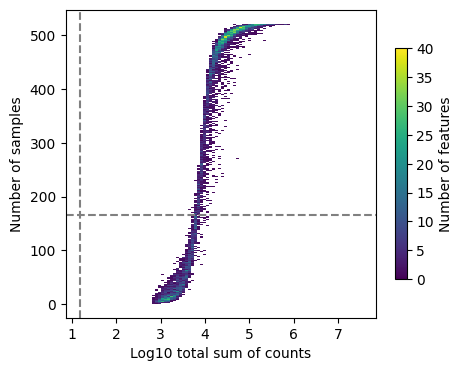

In [338]:
dc.plot_filter_by_expr(pdata, group='age', min_count=10, min_total_count=15)

In [339]:
# # Obtain genes that pass the thresholds
# genes = dc.filter_by_expr(pdata, group='age', min_count=10, min_total_count=15)
# # Filter by these genes
# pdata = pdata[:, genes].copy()
# pdata

In [340]:
d_res = {}

for ct in tqdm(pdata.obs['cell_type'].unique()):
    pdata_subset = pdata[pdata.obs['cell_type'] == ct, :].copy()
    # Obtain genes that pass the thresholds
    # genes = dc.filter_by_expr(pdata_subset, group='age', min_count=10, min_total_count=15)
    # Filter by these genes
    # pdata_subset = pdata_subset[:, genes].copy()
    # Build DESeq2 object
    dds = DeseqDataSet(
        adata=pdata_subset,
        # design_factors='age',
        # ref_level=['age', 'YOUNG'],
        design_factors='age',
        ref_level=['age', 'YOUNG'],
        refit_cooks=True,
        n_cpus=16
    )
    # Compute LFCs
    dds.deseq2()
    # Extract contrast
    stat_res = DeseqStats(dds, contrast=["age", 'OLD', 'YOUNG'], alpha = 0.1, 
                          independent_filter=True, n_cpus=16)
    # stat_res.lfc_shrink(coeff='age_OLD_vs_YOUNG')
    stat_res.summary()
    # Extract results
    d_res[ct] = stat_res.results_df

  0%|                                                                                                                      | 0/29 [00:00<?, ?it/s]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.55 seconds.

Fitting dispersion trend curve...
... done in 2.19 seconds.

Fitting MAP dispersions...
... done in 4.70 seconds.

Fitting LFCs...
... done in 0.51 seconds.

Refitting 2 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.52 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   102.224525       -0.227785  0.142768 -1.595492  0.110602   
0610009O20Rik    30.453512       -0.044355  0.208014 -0.213233  0.831145   
0610010F05Rik    87.654083        0.059817  0.160689  0.372256  0.709702   
0610010K14Rik   118.362900       -0.147045  0.146710 -1.002285  0.316206   
0610012G03Rik   415.893188       -0.227291  0.123293 -1.843507  0.065255   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1386.483276       -0.117424  0.229500 -0.511653  0.608894   
mt-Nd3          126.544609        0.078791  0.512138  0.153846  0.877731   
mt-Nd4         3814.578613       -0.240384  0.355644 -0.675913  0.499096   
mt-Nd5          438.836792       -0.051411  0.247449 -0.207764  0.835413   
mt-Nd6          141.410919       -0.233860  0.282665 -0.827341  0.408044   

                   padj  
0610009B22Rik  0.807874  
0610009O20Rik  0.989277  
0610010F05Rik  0.985383  
0610010K14Rik  0.921155  
0610012G03Rik  0.739864  
...                 ...  
mt-Nd2         0.972674  
mt-Nd3         0.992074  
mt-Nd4         0.958342  
mt-Nd5         0.989676  
mt-Nd6         0.944600  

[14494 rows x 6 columns]

  3%|███▊                                                                                                          | 1/29 [00:13<06:09, 13.21s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.28 seconds.

Fitting dispersion trend curve...
... done in 2.19 seconds.

Fitting MAP dispersions...
... done in 4.24 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.46 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    32.460312       -0.101688  0.207961 -0.488975  0.624859   
0610009O20Rik    13.478054       -0.048512  0.240583 -0.201645  0.840194   
0610010F05Rik    21.089787       -0.235285  0.134492 -1.749436  0.080216   
0610010K14Rik    28.051012       -0.069427  0.184175 -0.376959  0.706204   
0610012G03Rik    90.367645       -0.333673  0.200223 -1.666511  0.095612   
...                    ...             ...       ...       ...       ...   
mt-Nd2          421.596008       -0.164852  0.240351 -0.685883  0.492787   
mt-Nd3           34.380875       -0.107474  0.547889 -0.196161  0.844484   
mt-Nd4         1173.238525       -0.337747  0.369424 -0.914253  0.360584   
mt-Nd5          145.504242       -0.207813  0.311952 -0.666170  0.505302   
mt-Nd6           35.341522       -0.220265  0.285746 -0.770844  0.440799   

                   padj  
0610009B22Rik  0.887384  
0610009O20Rik  0.962050  
0610010F05Rik  0.465025  
0610010K14Rik  0.916444  
0610012G03Rik  0.495400  
...                 ...  
mt-Nd2         0.825391  
mt-Nd3         0.963044  
mt-Nd4         0.750713  
mt-Nd5         0.832489  
mt-Nd6         0.798557  

[14494 rows x 6 columns]

  7%|███████▌                                                                                                      | 2/29 [00:25<05:44, 12.77s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.18 seconds.

Fitting dispersion trend curve...
... done in 2.19 seconds.

Fitting MAP dispersions...
... done in 4.01 seconds.

Fitting LFCs...
... done in 1.06 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    30.365631       -0.354153  0.207163 -1.709538  0.087351   
0610009O20Rik    10.553425        0.065288  0.266250  0.245212  0.806292   
0610010F05Rik    14.989175       -0.297530  0.309796 -0.960405  0.336851   
0610010K14Rik    35.943287       -0.548065  0.193765 -2.828497  0.004677   
0610012G03Rik    91.276695       -0.420686  0.153155 -2.746805  0.006018   
...                    ...             ...       ...       ...       ...   
mt-Nd2          460.568909       -0.094851  0.249948 -0.379484  0.704329   
mt-Nd3           35.022083        0.151724  0.530097  0.286219  0.774710   
mt-Nd4         1277.024170       -0.280204  0.345003 -0.812178  0.416689   
mt-Nd5          143.950943       -0.088637  0.244944 -0.361866  0.717453   
mt-Nd6           36.941483       -0.396376  0.326904 -1.212514  0.225316   

                   padj  
0610009B22Rik  0.687065  
0610009O20Rik  0.982128  
0610010F05Rik  0.882955  
0610010K14Rik  0.302862  
0610012G03Rik  0.331622  
...                 ...  
mt-Nd2         0.972008  
mt-Nd3         0.980669  
mt-Nd4         0.920763  
mt-Nd5         0.972012  
mt-Nd6         0.823418  

[14494 rows x 6 columns]

 10%|███████████▍                                                                                                  | 3/29 [00:38<05:29, 12.68s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.08 seconds.

Fitting dispersion trend curve...
... done in 2.48 seconds.

Fitting MAP dispersions...
... done in 2.29 seconds.

Fitting LFCs...
... done in 0.68 seconds.

Refitting 1 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   1.711369        0.988641  0.662965  1.491241  0.135898   
0610009O20Rik   0.338938        0.416114  1.720282  0.241887  0.808868   
0610010F05Rik   1.413391       -0.761558  0.794279 -0.958804  0.337658   
0610010K14Rik   2.747372       -0.913863  0.540083 -1.692079  0.090631   
0610012G03Rik   6.512804        0.225938  0.377232  0.598937  0.549215   
...                  ...             ...       ...       ...       ...   
mt-Nd2         28.849792       -0.118727  0.266082 -0.446205  0.655449   
mt-Nd3          2.280375        0.317180  0.750893  0.422404  0.672730   
mt-Nd4         70.546555       -0.322393  0.364008 -0.885675  0.375792   
mt-Nd5          7.548429       -0.396090  0.471188 -0.840619  0.400561   
mt-Nd6          2.345532        0.081916  0.626548  0.130742  0.895979   

                  padj  
0610009B22Rik  0.99933  
0610009O20Rik  0.99933  
0610010F05Rik  0.99933  
0610010K14Rik  0.99933  
0610012G03Rik  0.99933  
...                ...  
mt-Nd2         0.99933  
mt-Nd3         0.99933  
mt-Nd4         0.99933  
mt-Nd5         0.99933  
mt-Nd6         0.99933  

[14494 rows x 6 columns]

 14%|███████████████▏                                                                                              | 4/29 [00:48<04:50, 11.63s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.52 seconds.

Fitting dispersion trend curve...
... done in 2.18 seconds.

Fitting MAP dispersions...
... done in 4.54 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Refitting 1 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    61.172623       -0.256910  0.167388 -1.534815  0.124829   
0610009O20Rik    24.352829       -0.382530  0.192338 -1.988839  0.046719   
0610010F05Rik    70.190674        0.076557  0.129450  0.591401  0.554252   
0610010K14Rik    80.235611       -0.237259  0.170828 -1.388876  0.164871   
0610012G03Rik   234.014755       -0.075385  0.121192 -0.622034  0.533920   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1055.417480       -0.041918  0.259380 -0.161608  0.871615   
mt-Nd3           78.501434       -0.087747  0.558487 -0.157115  0.875154   
mt-Nd4         2801.211182       -0.288029  0.374657 -0.768781  0.442024   
mt-Nd5          338.372162       -0.075707  0.324957 -0.232975  0.815781   
mt-Nd6           84.362511       -0.127328  0.260469 -0.488842  0.624954   

                   padj  
0610009B22Rik  0.643127  
0610009O20Rik  0.479810  
0610010F05Rik  0.902528  
0610010K14Rik  0.690763  
0610012G03Rik  0.896895  
...                 ...  
mt-Nd2         0.981394  
mt-Nd3         0.982581  
mt-Nd4         0.866477  
mt-Nd5         0.970159  
mt-Nd6         0.922286  

[14494 rows x 6 columns]

 17%|██████████████████▉                                                                                           | 5/29 [01:02<04:57, 12.41s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.86 seconds.

Fitting dispersion trend curve...
... done in 2.43 seconds.

Fitting MAP dispersions...
... done in 1.87 seconds.

Fitting LFCs...
... done in 0.69 seconds.

Refitting 4 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   0.881884        0.553311  1.221747  0.452885  0.650631   
0610009O20Rik   0.301822        1.006710  2.055096  0.489860  0.624233   
0610010F05Rik   1.209067        1.082643  1.085121  0.997716  0.318417   
0610010K14Rik   0.709345        1.119408  1.210805  0.924515  0.355218   
0610012G03Rik   4.041072        0.106394  0.435010  0.244577  0.806784   
...                  ...             ...       ...       ...       ...   
mt-Nd2         15.187225        0.320348  0.405586  0.789840  0.429621   
mt-Nd3          1.094884        0.605709  1.104950  0.548177  0.583570   
mt-Nd4         34.266186       -0.365885  0.285009 -1.283768  0.199223   
mt-Nd5          3.874295        0.007745  0.550025  0.014081  0.988765   
mt-Nd6          0.738643        0.471531  1.049518  0.449284  0.653227   

                   padj  
0610009B22Rik  0.999637  
0610009O20Rik  0.999637  
0610010F05Rik  0.999637  
0610010K14Rik  0.999637  
0610012G03Rik  0.999637  
...                 ...  
mt-Nd2         0.999637  
mt-Nd3         0.999637  
mt-Nd4         0.999637  
mt-Nd5         0.999637  
mt-Nd6         0.999637  

[14494 rows x 6 columns]

 21%|██████████████████████▊                                                                                       | 6/29 [01:11<04:19, 11.26s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.26 seconds.

Fitting dispersion trend curve...
... done in 2.14 seconds.

Fitting MAP dispersions...
... done in 4.30 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    67.200836       -0.280692  0.110997 -2.528838  0.011444   
0610009O20Rik    21.801912       -0.057805  0.221068 -0.261480  0.793722   
0610010F05Rik    44.738411       -0.101662  0.247594 -0.410599  0.681367   
0610010K14Rik   103.788048       -0.344566  0.167087 -2.062199  0.039189   
0610012G03Rik   267.681274       -0.108108  0.175199 -0.617059  0.537196   
...                    ...             ...       ...       ...       ...   
mt-Nd2          596.679932        0.070088  0.229326  0.305625  0.759890   
mt-Nd3           59.069416        0.025063  0.497393  0.050389  0.959812   
mt-Nd4         1822.156250       -0.084442  0.366764 -0.230236  0.817908   
mt-Nd5          196.704819        0.110450  0.262592  0.420614  0.674037   
mt-Nd6           38.246616       -0.145200  0.316423 -0.458879  0.646321   

                   padj  
0610009B22Rik  0.823810  
0610009O20Rik  0.999932  
0610010F05Rik  0.999932  
0610010K14Rik  0.999932  
0610012G03Rik  0.999932  
...                 ...  
mt-Nd2         0.999932  
mt-Nd3         0.999932  
mt-Nd4         0.999932  
mt-Nd5         0.999932  
mt-Nd6         0.999932  

[14494 rows x 6 columns]

 24%|██████████████████████████▌                                                                                   | 7/29 [01:23<04:16, 11.68s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.85 seconds.

Fitting dispersion trend curve...
... done in 2.33 seconds.

Fitting MAP dispersions...
... done in 3.38 seconds.

Fitting LFCs...
... done in 1.10 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   18.204031       -0.014573  0.278201 -0.052382  0.958224   
0610009O20Rik    3.259156       -0.163351  0.511180 -0.319556  0.749305   
0610010F05Rik   11.504332        0.612969  0.326352  1.878246  0.060348   
0610010K14Rik   13.668774       -0.161496  0.360018 -0.448577  0.653736   
0610012G03Rik   55.929485       -0.287794  0.119533 -2.407656  0.016055   
...                   ...             ...       ...       ...       ...   
mt-Nd2         204.950256       -0.012116  0.230320 -0.052605  0.958047   
mt-Nd3          17.688969        0.023377  0.405076  0.057710  0.953980   
mt-Nd4         572.566772       -0.200883  0.273211 -0.735266  0.462178   
mt-Nd5          62.940411       -0.009767  0.251642 -0.038813  0.969040   
mt-Nd6          19.444765       -0.629605  0.360857 -1.744750  0.081028   

                   padj  
0610009B22Rik  0.998908  
0610009O20Rik       NaN  
0610010F05Rik  0.996692  
0610010K14Rik  0.996692  
0610012G03Rik  0.901376  
...                 ...  
mt-Nd2         0.998908  
mt-Nd3         0.998908  
mt-Nd4         0.996692  
mt-Nd5         0.998908  
mt-Nd6         0.996692  

[14494 rows x 6 columns]

 28%|██████████████████████████████▎                                                                               | 8/29 [01:35<04:06, 11.73s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.84 seconds.

Fitting dispersion trend curve...
... done in 2.28 seconds.

Fitting MAP dispersions...
... done in 3.50 seconds.

Fitting LFCs...
... done in 0.58 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   17.184309       -0.346688  0.280723 -1.234983  0.216837   
0610009O20Rik    3.017842       -0.304390  0.486426 -0.625770  0.531466   
0610010F05Rik   11.188930       -0.040737  0.293629 -0.138736  0.889659   
0610010K14Rik   15.029633       -0.050710  0.287172 -0.176585  0.859834   
0610012G03Rik   49.104866        0.148263  0.151800  0.976699  0.328718   
...                   ...             ...       ...       ...       ...   
mt-Nd2         178.711670       -0.039270  0.249638 -0.157307  0.875003   
mt-Nd3          16.912218       -0.087937  0.593740 -0.148106  0.882259   
mt-Nd4         523.879150       -0.180641  0.243457 -0.741982  0.458098   
mt-Nd5          57.802246       -0.049623  0.216666 -0.229029  0.818846   
mt-Nd6          18.745155        0.017775  0.385800  0.046074  0.963252   

                   padj  
0610009B22Rik  0.999773  
0610009O20Rik  0.999773  
0610010F05Rik  0.999773  
0610010K14Rik  0.999773  
0610012G03Rik  0.999773  
...                 ...  
mt-Nd2         0.999773  
mt-Nd3         0.999773  
mt-Nd4         0.999773  
mt-Nd5         0.999773  
mt-Nd6         0.999773  

[14494 rows x 6 columns]

 31%|██████████████████████████████████▏                                                                           | 9/29 [01:46<03:52, 11.62s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.28 seconds.

Fitting dispersion trend curve...
... done in 2.16 seconds.

Fitting MAP dispersions...
... done in 4.09 seconds.

Fitting LFCs...
... done in 0.58 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.49 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    36.574905       -0.096788  0.178489 -0.542262  0.587638   
0610009O20Rik     7.355407       -0.080330  0.328567 -0.244487  0.806854   
0610010F05Rik    32.069962       -0.089391  0.190006 -0.470466  0.638022   
0610010K14Rik    33.083477       -0.122685  0.187627 -0.653876  0.513192   
0610012G03Rik   130.216934       -0.167185  0.173201 -0.965267  0.334411   
...                    ...             ...       ...       ...       ...   
mt-Nd2          460.316284        0.001095  0.221154  0.004950  0.996050   
mt-Nd3           39.964954       -0.137110  0.578783 -0.236893  0.812740   
mt-Nd4         1284.330322       -0.150876  0.336874 -0.447871  0.654247   
mt-Nd5          144.998489       -0.026599  0.247556 -0.107447  0.914434   
mt-Nd6           38.605507       -0.297175  0.289481 -1.026579  0.304619   

                   padj  
0610009B22Rik  0.971870  
0610009O20Rik  0.988015  
0610010F05Rik  0.975485  
0610010K14Rik  0.956329  
0610012G03Rik  0.915269  
...                 ...  
mt-Nd2         0.999975  
mt-Nd3         0.988015  
mt-Nd4         0.977329  
mt-Nd5         0.996863  
mt-Nd6         0.913243  

[14494 rows x 6 columns]

 34%|█████████████████████████████████████▌                                                                       | 10/29 [01:59<03:44, 11.83s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.53 seconds.

Fitting dispersion trend curve...
... done in 2.19 seconds.

Fitting MAP dispersions...
... done in 4.57 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 2 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   136.344696       -0.077185  0.122746 -0.628819  0.529468   
0610009O20Rik    28.028418        0.284379  0.183037  1.553667  0.120264   
0610010F05Rik    97.466286       -0.073304  0.113323 -0.646857  0.517724   
0610010K14Rik   116.493805       -0.162910  0.191904 -0.848911  0.395931   
0610012G03Rik   422.952179       -0.143053  0.129214 -1.107100  0.268251   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1296.619629       -0.029002  0.230133 -0.126024  0.899713   
mt-Nd3          127.416206        0.200927  0.523524  0.383797  0.701129   
mt-Nd4         3583.588379       -0.169710  0.349064 -0.486187  0.626835   
mt-Nd5          395.497162        0.029500  0.236167  0.124910  0.900595   
mt-Nd6          110.494415       -0.106460  0.285980 -0.372262  0.709698   

                   padj  
0610009B22Rik  0.989412  
0610009O20Rik  0.838651  
0610010F05Rik  0.989412  
0610010K14Rik  0.979081  
0610012G03Rik  0.942093  
...                 ...  
mt-Nd2         0.998590  
mt-Nd3         0.996099  
mt-Nd4         0.991718  
mt-Nd5         0.998590  
mt-Nd6         0.996099  

[14494 rows x 6 columns]

 38%|█████████████████████████████████████████▎                                                                   | 11/29 [02:12<03:42, 12.39s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.46 seconds.

Fitting dispersion trend curve...
... done in 2.19 seconds.

Fitting MAP dispersions...
... done in 3.98 seconds.

Fitting LFCs...
... done in 0.62 seconds.

Refitting 2 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    47.315895        0.163150  0.161723  1.008824  0.313059   
0610009O20Rik     9.391420       -0.285382  0.344735 -0.827829  0.407768   
0610010F05Rik    31.693977        0.077497  0.182389  0.424900  0.670909   
0610010K14Rik    32.609234       -0.193866  0.189827 -1.021275  0.307124   
0610012G03Rik   131.328613       -0.133970  0.144784 -0.925309  0.354805   
...                    ...             ...       ...       ...       ...   
mt-Nd2          417.161011        0.076653  0.212926  0.359995  0.718851   
mt-Nd3           36.693027       -0.037758  0.552748 -0.068310  0.945539   
mt-Nd4         1057.823120       -0.208056  0.264039 -0.787975  0.430711   
mt-Nd5          125.267822        0.027922  0.210312  0.132767  0.894378   
mt-Nd6           26.965364       -0.140659  0.291195 -0.483042  0.629066   

                   padj  
0610009B22Rik  0.999818  
0610009O20Rik  0.999818  
0610010F05Rik  0.999818  
0610010K14Rik  0.999818  
0610012G03Rik  0.999818  
...                 ...  
mt-Nd2         0.999818  
mt-Nd3         0.999818  
mt-Nd4         0.999818  
mt-Nd5         0.999818  
mt-Nd6         0.999818  

[14494 rows x 6 columns]

 41%|█████████████████████████████████████████████                                                                | 12/29 [02:32<04:06, 14.48s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.60 seconds.

Fitting dispersion trend curve...
... done in 2.25 seconds.

Fitting MAP dispersions...
... done in 4.30 seconds.

Fitting LFCs...
... done in 1.09 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    61.382595       -0.506849  0.181106 -2.798630  0.005132   
0610009O20Rik    21.134445       -0.463237  0.221143 -2.094737  0.036194   
0610010F05Rik    61.044250       -0.130363  0.156043 -0.835429  0.403476   
0610010K14Rik    77.172493       -0.241492  0.170921 -1.412886  0.157689   
0610012G03Rik   248.313904       -0.368971  0.127028 -2.904647  0.003677   
...                    ...             ...       ...       ...       ...   
mt-Nd2          857.377869       -0.131725  0.260080 -0.506477  0.612522   
mt-Nd3           72.539764       -0.033083  0.549836 -0.060168  0.952021   
mt-Nd4         2335.769531       -0.330220  0.406348 -0.812655  0.416416   
mt-Nd5          290.677979       -0.060419  0.347493 -0.173871  0.861967   
mt-Nd6           75.105743       -0.286211  0.355154 -0.805879  0.420313   

                   padj  
0610009B22Rik  0.156420  
0610009O20Rik  0.376767  
0610010F05Rik  0.807445  
0610010K14Rik  0.616436  
0610012G03Rik  0.132731  
...                 ...  
mt-Nd2         0.897498  
mt-Nd3         0.990833  
mt-Nd4         0.812071  
mt-Nd5         0.968979  
mt-Nd6         0.813468  

[14494 rows x 6 columns]

 45%|████████████████████████████████████████████████▊                                                            | 13/29 [02:45<03:46, 14.17s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.49 seconds.

Fitting dispersion trend curve...
... done in 2.25 seconds.

Fitting MAP dispersions...
... done in 4.44 seconds.

Fitting LFCs...
... done in 0.54 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    36.974445       -0.310871  0.187565 -1.657404  0.097438   
0610009O20Rik    20.100096       -0.089038  0.216808 -0.410679  0.681308   
0610010F05Rik    56.262302        0.120534  0.123090  0.979228  0.327467   
0610010K14Rik    54.363010       -0.442087  0.165512 -2.671027  0.007562   
0610012G03Rik   152.585876       -0.059926  0.117905 -0.508255  0.611275   
...                    ...             ...       ...       ...       ...   
mt-Nd2          715.648193       -0.074007  0.273680 -0.270413  0.786842   
mt-Nd3           52.216835       -0.149286  0.568876 -0.262423  0.792995   
mt-Nd4         1967.991333       -0.332234  0.416305 -0.798054  0.424839   
mt-Nd5          249.218018       -0.076766  0.322533 -0.238010  0.811874   
mt-Nd6           56.888157       -0.001637  0.331286 -0.004941  0.996058   

                   padj  
0610009B22Rik  0.588962  
0610009O20Rik  0.949926  
0610010F05Rik  0.814346  
0610010K14Rik  0.242552  
0610012G03Rik  0.925880  
...                 ...  
mt-Nd2         0.965699  
mt-Nd3         0.965699  
mt-Nd4         0.863168  
mt-Nd5         0.971996  
mt-Nd6         0.999382  

[14494 rows x 6 columns]

 48%|████████████████████████████████████████████████████▌                                                        | 14/29 [02:58<03:26, 13.78s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.13 seconds.

Fitting dispersion trend curve...
... done in 2.37 seconds.

Fitting MAP dispersions...
... done in 3.74 seconds.

Fitting LFCs...
... done in 0.67 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.46 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    9.028181       -0.904418  0.347309 -2.604072  0.009212   
0610009O20Rik    3.733125       -1.231328  0.417861 -2.946738  0.003211   
0610010F05Rik   11.616488        0.011727  0.289716  0.040476  0.967714   
0610010K14Rik    9.934223       -0.242363  0.271335 -0.893224  0.371737   
0610012G03Rik   34.875847       -0.037983  0.132641 -0.286358  0.774604   
...                   ...             ...       ...       ...       ...   
mt-Nd2         158.481903       -0.049112  0.241822 -0.203093  0.839062   
mt-Nd3          10.165817        0.033527  0.673266  0.049798  0.960284   
mt-Nd4         426.436096       -0.224562  0.346931 -0.647281  0.517450   
mt-Nd5          46.789200       -0.020943  0.285497 -0.073358  0.941521   
mt-Nd6          12.702037       -0.060620  0.422128 -0.143607  0.885811   

                   padj  
0610009B22Rik       NaN  
0610009O20Rik       NaN  
0610010F05Rik       NaN  
0610010K14Rik       NaN  
0610012G03Rik  0.969225  
...                 ...  
mt-Nd2         0.979543  
mt-Nd3              NaN  
mt-Nd4         0.935587  
mt-Nd5         0.998030  
mt-Nd6              NaN  

[14494 rows x 6 columns]

 52%|████████████████████████████████████████████████████████▍                                                    | 15/29 [03:10<03:05, 13.26s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.68 seconds.

Fitting dispersion trend curve...
... done in 2.42 seconds.

Fitting MAP dispersions...
... done in 5.16 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Refitting 2 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   126.263824       -0.173027  0.196097 -0.882351  0.377587   
0610009O20Rik    36.709694        0.013270  0.212541  0.062437  0.950215   
0610010F05Rik   131.799622       -0.166321  0.125367 -1.326666  0.184619   
0610010K14Rik   150.664383       -0.292055  0.123865 -2.357849  0.018381   
0610012G03Rik   485.002930       -0.141676  0.119374 -1.186823  0.235298   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1804.724365       -0.097972  0.254235 -0.385357  0.699973   
mt-Nd3          158.548508       -0.058277  0.567687 -0.102657  0.918235   
mt-Nd4         4949.068848       -0.268611  0.372931 -0.720269  0.471359   
mt-Nd5          571.887817       -0.018102  0.311943 -0.058031  0.953724   
mt-Nd6          167.062393       -0.266735  0.240299 -1.110015  0.266992   

                   padj  
0610009B22Rik  0.894229  
0610009O20Rik  0.994511  
0610010F05Rik  0.789412  
0610010K14Rik  0.431979  
0610012G03Rik  0.827123  
...                 ...  
mt-Nd2         0.969772  
mt-Nd3         0.994428  
mt-Nd4         0.921293  
mt-Nd5         0.994511  
mt-Nd6         0.846362  

[14494 rows x 6 columns]

 55%|████████████████████████████████████████████████████████████▏                                                | 16/29 [03:25<02:57, 13.67s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.58 seconds.

Fitting dispersion trend curve...
... done in 2.27 seconds.

Fitting MAP dispersions...
... done in 4.58 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Refitting 1 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    81.896111       -0.049756  0.151148 -0.329185  0.742016   
0610009O20Rik    28.212339        0.212643  0.204698  1.038816  0.298890   
0610010F05Rik    88.416664       -0.001572  0.154325 -0.010189  0.991870   
0610010K14Rik   105.011246       -0.338929  0.137843 -2.458811  0.013940   
0610012G03Rik   310.436768       -0.200890  0.132673 -1.514167  0.129983   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1147.040771       -0.002304  0.254524 -0.009052  0.992777   
mt-Nd3           97.732430        0.066451  0.526632  0.126181  0.899588   
mt-Nd4         3037.876221       -0.310748  0.371292 -0.836936  0.402629   
mt-Nd5          360.818359       -0.075595  0.290090 -0.260592  0.794407   
mt-Nd6           95.013756       -0.120259  0.253459 -0.474472  0.635163   

                   padj  
0610009B22Rik  0.963673  
0610009O20Rik  0.840062  
0610010F05Rik  0.999116  
0610010K14Rik  0.382882  
0610012G03Rik  0.720131  
...                 ...  
mt-Nd2         0.999251  
mt-Nd3         0.986357  
mt-Nd4         0.877020  
mt-Nd5         0.972596  
mt-Nd6         0.946794  

[14494 rows x 6 columns]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17/29 [03:38<02:42, 13.55s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.75 seconds.

Fitting dispersion trend curve...
... done in 2.16 seconds.

Fitting MAP dispersions...
... done in 4.96 seconds.

Fitting LFCs...
... done in 1.13 seconds.

Refitting 1 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    93.214851       -0.140663  0.146524 -0.960002  0.337054   
0610009O20Rik    21.618227        0.202145  0.149291  1.354029  0.175727   
0610010F05Rik    86.238464       -0.047721  0.118065 -0.404197  0.686068   
0610010K14Rik    84.627502       -0.206706  0.118634 -1.742373  0.081443   
0610012G03Rik   238.169220       -0.156134  0.106828 -1.461536  0.143868   
...                    ...             ...       ...       ...       ...   
mt-Nd2         1090.661377       -0.073077  0.241290 -0.302858  0.761998   
mt-Nd3           81.562050       -0.029698  0.484522 -0.061294  0.951125   
mt-Nd4         2946.604980       -0.236232  0.308134 -0.766653  0.443288   
mt-Nd5          342.280090       -0.064830  0.215617 -0.300672  0.763665   
mt-Nd6           92.984070       -0.119856  0.286620 -0.418171  0.675822   

                   padj  
0610009B22Rik  0.974035  
0610009O20Rik  0.919979  
0610010F05Rik  0.998933  
0610010K14Rik  0.841366  
0610012G03Rik  0.895269  
...                 ...  
mt-Nd2         0.998933  
mt-Nd3         0.999618  
mt-Nd4         0.979871  
mt-Nd5         0.998933  
mt-Nd6         0.998933  

[14494 rows x 6 columns]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18/29 [03:52<02:32, 13.82s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.22 seconds.

Fitting dispersion trend curve...
... done in 2.56 seconds.

Fitting MAP dispersions...
... done in 4.17 seconds.

Fitting LFCs...
... done in 0.57 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    44.532448       -0.216638  0.171039 -1.266598  0.205299   
0610009O20Rik    10.470914        0.079771  0.204708  0.389684  0.696770   
0610010F05Rik    31.764112        0.279969  0.182545  1.533702  0.125103   
0610010K14Rik    43.476509       -0.134279  0.202038 -0.664622  0.506292   
0610012G03Rik   139.574509       -0.112366  0.165930 -0.677190  0.498285   
...                    ...             ...       ...       ...       ...   
mt-Nd2          498.147339       -0.144176  0.231670 -0.622333  0.533723   
mt-Nd3           48.764324       -0.041529  0.549730 -0.075544  0.939782   
mt-Nd4         1384.967529       -0.245029  0.366068 -0.669354  0.503270   
mt-Nd5          156.837997       -0.058382  0.251233 -0.232384  0.816240   
mt-Nd6           44.720531       -0.154190  0.282888 -0.545059  0.585713   

                   padj  
0610009B22Rik  0.909565  
0610009O20Rik  0.981775  
0610010F05Rik  0.872170  
0610010K14Rik  0.960948  
0610012G03Rik  0.960948  
...                 ...  
mt-Nd2         0.963486  
mt-Nd3         0.995154  
mt-Nd4         0.960948  
mt-Nd5         0.992950  
mt-Nd6         0.970821  

[14494 rows x 6 columns]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 19/29 [04:05<02:14, 13.48s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.22 seconds.

Fitting dispersion trend curve...
... done in 2.25 seconds.

Fitting MAP dispersions...
... done in 3.92 seconds.

Fitting LFCs...
... done in 0.60 seconds.

Refitting 1 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    44.551376       -0.033757  0.195966 -0.172259  0.863234   
0610009O20Rik    10.698610        0.241536  0.321995  0.750122  0.453181   
0610010F05Rik    39.527424       -0.201929  0.139666 -1.445805  0.148232   
0610010K14Rik    36.953835       -0.092453  0.167562 -0.551752  0.581118   
0610012G03Rik   122.407928       -0.170685  0.150971 -1.130579  0.258232   
...                    ...             ...       ...       ...       ...   
mt-Nd2          616.539429       -0.042958  0.247330 -0.173687  0.862112   
mt-Nd3           50.909889       -0.275914  0.497544 -0.554552  0.579201   
mt-Nd4         1683.641235       -0.153551  0.229385 -0.669401  0.503239   
mt-Nd5          192.195084        0.015936  0.152672  0.104379  0.916869   
mt-Nd6           43.281582       -0.036570  0.372925 -0.098062  0.921883   

                   padj  
0610009B22Rik  0.999963  
0610009O20Rik  0.999963  
0610010F05Rik  0.999963  
0610010K14Rik  0.999963  
0610012G03Rik  0.999963  
...                 ...  
mt-Nd2         0.999963  
mt-Nd3         0.999963  
mt-Nd4         0.999963  
mt-Nd5         0.999963  
mt-Nd6         0.999963  

[14494 rows x 6 columns]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20/29 [04:17<01:58, 13.18s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.37 seconds.

Fitting dispersion trend curve...
... done in 2.29 seconds.

Fitting MAP dispersions...
... done in 4.92 seconds.

Fitting LFCs...
... done in 1.15 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.48 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    45.774651       -0.569402  0.203223 -2.801858  0.005081   
0610009O20Rik    12.120968        0.118450  0.288112  0.411124  0.680982   
0610010F05Rik    37.150780       -0.083241  0.190699 -0.436506  0.662469   
0610010K14Rik    39.604107       -0.187612  0.169502 -1.106843  0.268362   
0610012G03Rik   154.069382       -0.139471  0.125322 -1.112907  0.265748   
...                    ...             ...       ...       ...       ...   
mt-Nd2          587.505920       -0.046509  0.214051 -0.217281  0.827989   
mt-Nd3           52.827812       -0.129795  0.541301 -0.239784  0.810498   
mt-Nd4         1585.660156       -0.188945  0.343137 -0.550639  0.581881   
mt-Nd5          176.131195       -0.065852  0.292799 -0.224907  0.822052   
mt-Nd6           50.930172       -0.025541  0.290904 -0.087800  0.930035   

                   padj  
0610009B22Rik  0.342777  
0610009O20Rik       NaN  
0610010F05Rik  0.964920  
0610010K14Rik  0.909266  
0610012G03Rik  0.909166  
...                 ...  
mt-Nd2         0.979605  
mt-Nd3         0.976187  
mt-Nd4         0.960510  
mt-Nd5         0.978897  
mt-Nd6         0.989800  

[14494 rows x 6 columns]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21/29 [04:31<01:47, 13.38s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.19 seconds.

Fitting dispersion trend curve...
... done in 2.20 seconds.

Fitting MAP dispersions...
... done in 4.10 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    43.122185       -0.068924  0.133769 -0.515248  0.606380   
0610009O20Rik     9.592106        0.330574  0.233555  1.415403  0.156950   
0610010F05Rik    38.188721       -0.025182  0.166256 -0.151465  0.879609   
0610010K14Rik    40.678173       -0.144201  0.219031 -0.658359  0.510308   
0610012G03Rik   137.838974       -0.180334  0.146202 -1.233458  0.217405   
...                    ...             ...       ...       ...       ...   
mt-Nd2          525.336182       -0.027978  0.234873 -0.119122  0.905179   
mt-Nd3           49.569782       -0.046353  0.552885 -0.083838  0.933185   
mt-Nd4         1466.997559       -0.237337  0.365227 -0.649834  0.515799   
mt-Nd5          164.395264       -0.012263  0.276036 -0.044427  0.964564   
mt-Nd6           49.703072       -0.351340  0.292232 -1.202266  0.229261   

                   padj  
0610009B22Rik  0.991853  
0610009O20Rik  0.926910  
0610010F05Rik  0.999253  
0610010K14Rik  0.989116  
0610012G03Rik  0.957339  
...                 ...  
mt-Nd2         0.999253  
mt-Nd3         0.999253  
mt-Nd4         0.989116  
mt-Nd5         0.999253  
mt-Nd6         0.961238  

[14494 rows x 6 columns]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22/29 [04:44<01:31, 13.04s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.34 seconds.

Fitting dispersion trend curve...
... done in 2.62 seconds.

Fitting MAP dispersions...
... done in 2.56 seconds.

Fitting LFCs...
... done in 0.67 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.99 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    2.741356       -0.308850  0.576053 -0.536149  0.591855   
0610009O20Rik    0.825700       -1.570469  1.060788 -1.480474  0.138747   
0610010F05Rik    1.872342        0.000854  0.791295  0.001079  0.999139   
0610010K14Rik    4.939135        0.548044  0.559066  0.980285  0.326945   
0610012G03Rik    9.555387        0.110113  0.366993  0.300040  0.764146   
...                   ...             ...       ...       ...       ...   
mt-Nd2          53.606361       -0.054854  0.268465 -0.204325  0.838100   
mt-Nd3           4.090676        0.080002  0.606512  0.131905  0.895060   
mt-Nd4         136.994034       -0.244256  0.319559 -0.764352  0.444658   
mt-Nd5          15.706674        0.108148  0.305164  0.354392  0.723045   
mt-Nd6           3.647928        0.269289  0.468767  0.574463  0.565654   

                   padj  
0610009B22Rik  0.999252  
0610009O20Rik  0.999252  
0610010F05Rik  0.999937  
0610010K14Rik  0.999252  
0610012G03Rik  0.999252  
...                 ...  
mt-Nd2         0.999252  
mt-Nd3         0.999252  
mt-Nd4         0.999252  
mt-Nd5         0.999252  
mt-Nd6         0.999252  

[14494 rows x 6 columns]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23/29 [04:54<01:14, 12.38s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.98 seconds.

Fitting dispersion trend curve...
... done in 2.51 seconds.

Fitting MAP dispersions...
... done in 3.61 seconds.

Fitting LFCs...
... done in 0.63 seconds.

Refitting 4 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   10.032642        0.053341  0.279725  0.190690  0.848769   
0610009O20Rik    6.017192        0.418389  0.378136  1.106450  0.268532   
0610010F05Rik    6.091547       -0.305750  0.490997 -0.622713  0.533473   
0610010K14Rik   19.865374       -0.139052  0.387273 -0.359054  0.719555   
0610012G03Rik   34.078922       -0.087983  0.180339 -0.487874  0.625639   
...                   ...             ...       ...       ...       ...   
mt-Nd2         189.691833       -0.147385  0.256965 -0.573562  0.566264   
mt-Nd3          14.267826        0.492788  0.584175  0.843562  0.398914   
mt-Nd4         592.976807       -0.157364  0.302246 -0.520649  0.602611   
mt-Nd5          59.227165        0.154177  0.227524  0.677631  0.498006   
mt-Nd6          17.871872       -0.177421  0.367183 -0.483194  0.628958   

                   padj  
0610009B22Rik  0.994534  
0610009O20Rik  0.994534  
0610010F05Rik  0.994534  
0610010K14Rik  0.994534  
0610012G03Rik  0.994534  
...                 ...  
mt-Nd2         0.994534  
mt-Nd3         0.994534  
mt-Nd4         0.994534  
mt-Nd5         0.994534  
mt-Nd6         0.994534  

[14494 rows x 6 columns]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 24/29 [05:06<01:01, 12.25s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.53 seconds.

Fitting dispersion trend curve...
... done in 2.31 seconds.

Fitting MAP dispersions...
... done in 3.25 seconds.

Fitting LFCs...
... done in 0.69 seconds.

Refitting 3 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    5.341395        0.619333  0.472342  1.311196  0.189791   
0610009O20Rik    1.758738       -0.052391  0.678076 -0.077265  0.938413   
0610010F05Rik    3.637655        0.396047  0.520287  0.761208  0.446533   
0610010K14Rik    6.895077       -0.324421  0.307753 -1.054159  0.291810   
0610012G03Rik   18.300285       -0.210167  0.238079 -0.882763  0.377364   
...                   ...             ...       ...       ...       ...   
mt-Nd2          86.192299       -0.078160  0.223741 -0.349334  0.726839   
mt-Nd3           6.630189        0.433058  0.638802  0.677922  0.497821   
mt-Nd4         252.454514       -0.320988  0.320816 -1.000536  0.317051   
mt-Nd5          24.503689        0.340230  0.355313  0.957550  0.338290   
mt-Nd6           7.417718        0.049983  0.605099  0.082603  0.934167   

                   padj  
0610009B22Rik  0.999941  
0610009O20Rik  0.999941  
0610010F05Rik  0.999941  
0610010K14Rik  0.999941  
0610012G03Rik  0.999941  
...                 ...  
mt-Nd2         0.999941  
mt-Nd3         0.999941  
mt-Nd4         0.999941  
mt-Nd5         0.999941  
mt-Nd6         0.999941  

[14494 rows x 6 columns]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 25/29 [05:26<00:57, 14.49s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.85 seconds.

Fitting dispersion trend curve...
... done in 2.57 seconds.

Fitting MAP dispersions...
... done in 4.26 seconds.

Fitting LFCs...
... done in 0.57 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    47.698109        0.006673  0.163650  0.040774  0.967476   
0610009O20Rik    20.951305       -0.304780  0.210623 -1.447042  0.147885   
0610010F05Rik    29.399759       -0.033852  0.154017 -0.219796  0.826030   
0610010K14Rik    59.177532       -0.045514  0.157975 -0.288108  0.773264   
0610012G03Rik   127.863701        0.029456  0.144094  0.204419  0.838026   
...                    ...             ...       ...       ...       ...   
mt-Nd2          830.467651       -0.148674  0.242096 -0.614114  0.539140   
mt-Nd3           75.074745       -0.245794  0.530401 -0.463413  0.643069   
mt-Nd4         2290.209961       -0.266730  0.308903 -0.863476  0.387876   
mt-Nd5          247.282654       -0.027109  0.233560 -0.116069  0.907598   
mt-Nd6           68.760315       -0.365591  0.287052 -1.273606  0.202803   

                   padj  
0610009B22Rik  0.995887  
0610009O20Rik  0.682322  
0610010F05Rik  0.979198  
0610010K14Rik  0.966520  
0610012G03Rik  0.981134  
...                 ...  
mt-Nd2         0.916055  
mt-Nd3         0.937550  
mt-Nd4         0.855266  
mt-Nd5         0.990020  
mt-Nd6         0.746185  

[14494 rows x 6 columns]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 26/29 [05:39<00:42, 14.16s/it]Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.55 seconds.

Fitting dispersion trend curve...
... done in 2.63 seconds.

Fitting MAP dispersions...
... done in 3.17 seconds.

Fitting LFCs...
... done in 0.64 seconds.

Refitting 1 outliers.

Fitting size factors...
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/pydeseq2/dds.py:830: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seco

Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    5.206425       -0.532105  0.456311 -1.166103  0.243573   
0610009O20Rik    3.122216        0.063525  0.530316  0.119787  0.904652   
0610010F05Rik    4.084318        0.235168  0.566466  0.415149  0.678033   
0610010K14Rik    5.467958        0.384610  0.391464  0.982493  0.325857   
0610012G03Rik   16.887487       -0.057639  0.283580 -0.203254  0.838936   
...                   ...             ...       ...       ...       ...   
mt-Nd2          85.661987       -0.007271  0.234108 -0.031060  0.975222   
mt-Nd3           7.919224        0.168211  0.706438  0.238112  0.811794   
mt-Nd4         228.383850       -0.092658  0.359596 -0.257672  0.796660   
mt-Nd5          26.824627       -0.005954  0.287342 -0.020720  0.983469   
mt-Nd6           7.197892       -0.014513  0.353778 -0.041023  0.967277   

                   padj  
0610009B22Rik       NaN  
0610009O20Rik       NaN  
0610010F05Rik       NaN  
0610010K14Rik       NaN  
0610012G03Rik  0.981385  
...                 ...  
mt-Nd2         0.997611  
mt-Nd3         0.974867  
mt-Nd4         0.972935  
mt-Nd5         0.997611  
mt-Nd6         0.997489  

[14494 rows x 6 columns]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 27/29 [05:51<00:26, 13.38s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.15 seconds.

Fitting dispersion trend curve...
... done in 2.18 seconds.

Fitting MAP dispersions...
... done in 3.75 seconds.

Fitting LFCs...
... done in 1.13 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.51 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   11.185183        0.230229  0.332523  0.692371  0.488704   
0610009O20Rik    6.196230        0.362486  0.458311  0.790918  0.428992   
0610010F05Rik   22.834614       -0.150771  0.228825 -0.658891  0.509965   
0610010K14Rik   13.116367       -0.415412  0.240257 -1.729029  0.083804   
0610012G03Rik   37.207340       -0.114094  0.163850 -0.696333  0.486220   
...                   ...             ...       ...       ...       ...   
mt-Nd2         195.212463       -0.071587  0.191932 -0.372980  0.709163   
mt-Nd3          12.254781       -0.291826  0.615997 -0.473746  0.635681   
mt-Nd4         554.460632       -0.266850  0.337639 -0.790343  0.429328   
mt-Nd5          58.219620        0.091719  0.245876  0.373029  0.709127   
mt-Nd6          14.454357       -0.508725  0.408530 -1.245257  0.213037   

                   padj  
0610009B22Rik       NaN  
0610009O20Rik       NaN  
0610010F05Rik  0.838629  
0610010K14Rik  0.410291  
0610012G03Rik  0.820548  
...                 ...  
mt-Nd2         0.913225  
mt-Nd3         0.884289  
mt-Nd4         0.784241  
mt-Nd5         0.913225  
mt-Nd6         0.602730  

[14494 rows x 6 columns]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 28/29 [06:03<00:13, 13.08s/it]Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.46 seconds.

Fitting dispersion trend curve...
... done in 2.37 seconds.

Fitting MAP dispersions...
... done in 4.42 seconds.

Fitting LFCs...
... done in 0.57 seconds.

Refitting 2 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: age OLD vs YOUNG


... done in 0.45 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    83.065033       -0.049203  0.166611 -0.295315  0.767753   
0610009O20Rik    21.675507       -0.221861  0.150816 -1.471073  0.141271   
0610010F05Rik    55.740189       -0.156198  0.157200 -0.993626  0.320405   
0610010K14Rik    72.132324       -0.180522  0.166380 -1.084999  0.277922   
0610012G03Rik   256.933197       -0.104914  0.128728 -0.815004  0.415070   
...                    ...             ...       ...       ...       ...   
mt-Nd2          936.037231       -0.071290  0.267496 -0.266507  0.789849   
mt-Nd3           96.300179       -0.002717  0.531502 -0.005111  0.995922   
mt-Nd4         2562.625000       -0.188136  0.361213 -0.520844  0.602475   
mt-Nd5          291.522339       -0.048411  0.254271 -0.190391  0.849002   
mt-Nd6           89.536674       -0.326882  0.270419 -1.208795  0.226742   

                   padj  
0610009B22Rik  0.998669  
0610009O20Rik  0.947498  
0610010F05Rik  0.998669  
0610010K14Rik  0.998191  
0610012G03Rik  0.998669  
...                 ...  
mt-Nd2         0.998669  
mt-Nd3         0.999695  
mt-Nd4         0.998669  
mt-Nd5         0.998669  
mt-Nd6         0.994374  

[14494 rows x 6 columns]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [06:16<00:00, 13.00s/it]


In [352]:
adata.obs.loc[adata.obs['cell_type'].isin(['DOPA SN', 'DOPA VTA'])].groupby(['age', 'cell_type']).size()

age    cell_type    
OLD    AMYGDALA            0
       ASTRO 1             0
       ASTRO 2             0
       CORTEX ERYTH        0
       CORTEX Tshz2+       0
       Cartpt+             0
       DG GRANULE          0
       DOPA SN          1497
       DOPA VTA         1811
       DORSAL SUBIC        0
       EX CA1              0
       EX CA3              0
       EX L1               0
       EX L2/3             0
       EX L4               0
       EX L5               0
       EX L6               0
       EX MB               0
       IN Adarb2+          0
       IN MB               0
       IN Pvalb+           0
       IN Sst+             0
       MB ERYTH            0
       MENINGES            0
       MICROGLIA           0
       OLIGO               0
       OPC                 0
       THALAMUS            0
       VENTRAL SUBIC       0
YOUNG  AMYGDALA            0
       ASTRO 1             0
       ASTRO 2             0
       CORTEX ERYTH        0
       CORTEX Tshz2+  

In [341]:
for k,v in d_res.items():
    print(k)
    print(v.loc[v['padj'] < 0.1, :].shape)
    # d_res[k] = v.loc[v['padj'] < 0.1, :].copy()
    d_res[k] = v.copy()

AMYGDALA
(33, 6)
ASTRO 1
(209, 6)
ASTRO 2
(53, 6)
CORTEX ERYTH
(0, 6)
CORTEX Tshz2+
(147, 6)
Cartpt+
(0, 6)
DG GRANULE
(14, 6)
DOPA SN
(10, 6)
DOPA VTA
(2, 6)
DORSAL SUBIC
(27, 6)
EX CA1
(25, 6)
EX CA3
(1, 6)
EX L1
(272, 6)
EX L2/3
(156, 6)
EX L4
(14, 6)
EX L5
(97, 6)
EX L6
(101, 6)
EX MB
(17, 6)
IN Adarb2+
(24, 6)
IN MB
(0, 6)
IN Pvalb+
(29, 6)
IN Sst+
(0, 6)
MB ERYTH
(2, 6)
MENINGES
(10, 6)
MICROGLIA
(3, 6)
OLIGO
(238, 6)
OPC
(53, 6)
THALAMUS
(276, 6)
VENTRAL SUBIC
(3, 6)


In [342]:
df = pd.concat(d_res)
df.index.set_names(['cell_type', 'gene'], inplace=True)
df.to_csv('input/05_annotation/DE_pseudobulk_age.csv')

# Sox6 / Otx2

In [ ]:
GOI = list(adata_DA[:, 'Sox6'].X.A.flatten() > 0)
adata_DA.obs['GOI'] = ['Positive' if x == True else 'Negative' for x in GOI]
adata_DA.obs.groupby(['sample_name', 'cell_type', 'GOI']).size().reset_index().to_csv('input/05_annotation/sox6_positivity.csv')

GOI = list(adata_DA[:, 'Otx2'].X.A.flatten() > 0)
adata_DA.obs['GOI'] = ['Positive' if x == True else 'Negative' for x in GOI]
adata_DA.obs.groupby(['sample_name', 'cell_type', 'GOI']).size().reset_index().to_csv('input/05_annotation/otx2_positivity.csv')

# GOI = list(adata_DA[:, 'Casr'].X.A.flatten() > 0)
# adata_DA.obs['GOI'] = ['Positive' if x == True else 'Negative' for x in GOI]
# adata_DA.obs.groupby(['sample_name', 'cell_type', 'GOI']).size().reset_index().to_csv('input/05_annotation/casr_positivity.csv')

# UMAP for supplementary

In [ ]:
adata_umap = adata.copy()
sc.pp.normalize_total(adata_umap, target_sum=1e4)
sc.pp.log1p(adata_umap)
sc.pp.highly_variable_genes(adata_umap, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_umap = adata_umap[:, adata_umap.var.highly_variable]
sc.pp.scale(adata_umap, max_value=10)



In [ ]:
sc.tl.pca(adata_umap)
sc.pp.neighbors(adata_umap, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_umap)

# DOPA closer analysis

In [54]:
adata.obs.groupby('cell_type')['n_genes_by_counts'].median().max()

878.0

In [363]:
np.median(adata.obs['n_genes_by_counts'])

626.0

In [59]:
adata.X = adata.layers['counts'].copy()

adata_DA = adata[adata.obs['cell_type'].isin(['DOPA SN', 'DOPA VTA']), :].copy()
# adata_DA = adata_DA[adata_DA.obs['batch'] == 'batch1', :].copy()

sc.pp.normalize_total(adata_DA, target_sum=1e4)
sc.pp.log1p(adata_DA)
sc.tl.rank_genes_groups(adata_DA, groupby = 'cell_type', reference = 'DOPA VTA', groups = ['DOPA SN'], method = 'wilcoxon', key_added='SN_VTA')

df = sc.get.rank_genes_groups_df(adata_DA, key='SN_VTA', group = 'DOPA SN')
# df = df.loc[df['pvals_adj'] < 0.01]
df

names     scores  logfoldchanges         pvals     pvals_adj
0        Cplx1  18.097618        1.288142  3.327458e-73  4.822817e-69
1        Rab3c  14.405070        1.178234  4.808259e-47  3.484545e-43
2         Ldhb  11.283764        0.719828  1.578449e-29  7.626013e-26
3      Aldh1a1  10.760547        1.044479  5.285560e-27  1.532178e-23
4        Nrip3   9.481814        1.148709  2.499002e-21  5.174362e-18
...        ...        ...             ...           ...           ...
14489    Rps19  -7.461596       -0.482990  8.548100e-14  6.883120e-11
14490       Th  -7.718819       -0.517956  1.174123e-14  1.134516e-11
14491     Fth1  -8.328579       -0.264225  8.181824e-17  9.882280e-14
14492      Cck -10.265656       -0.755464  1.006356e-24  2.431022e-21
14493    Calb1 -11.089146       -1.431324  1.416335e-28  5.132090e-25

[14494 rows x 5 columns]

In [61]:
df.loc[df['pvals_adj'] < 0.05, :]

names     scores  logfoldchanges         pvals     pvals_adj
0        Cplx1  18.097618        1.288142  3.327458e-73  4.822817e-69
1        Rab3c  14.405070        1.178234  4.808259e-47  3.484545e-43
2         Ldhb  11.283764        0.719828  1.578449e-29  7.626013e-26
3      Aldh1a1  10.760547        1.044479  5.285560e-27  1.532178e-23
4        Nrip3   9.481814        1.148709  2.499002e-21  5.174362e-18
...        ...        ...             ...           ...           ...
14489    Rps19  -7.461596       -0.482990  8.548100e-14  6.883120e-11
14490       Th  -7.718819       -0.517956  1.174123e-14  1.134516e-11
14491     Fth1  -8.328579       -0.264225  8.181824e-17  9.882280e-14
14492      Cck -10.265656       -0.755464  1.006356e-24  2.431022e-21
14493    Calb1 -11.089146       -1.431324  1.416335e-28  5.132090e-25

[220 rows x 5 columns]

In [176]:
df.to_csv('input/05_annotation/markers/sn_vta_markers.csv', index=False)

In [361]:
adata.X = adata.layers['counts'].copy()
adata_DA = adata[adata.obs['cell_type'].isin(['DOPA SN', 'DOPA VTA']), :].copy()

genes = ['Calb1', 'Ahi1', 'Cplx1', 'Rab3c']
genes = ['Calb1', 'Cplx1', 'Aldh1a1', 'Rab3c']

adata_DA_spatial_100 = adata_DA[:, adata_DA.var_names.isin(genes)].copy()
pd.DataFrame(adata_DA_spatial_100.X.A, columns=adata_DA_spatial_100.var_names, index = adata_DA_spatial_100.obs_names).to_csv('input/05_annotation/markers/da_spatial_counts.csv')
adata_DA_spatial_100.obs.to_csv('input/05_annotation/markers/da_spatial_meta.csv')

In [23]:
df[:20]

names     scores  logfoldchanges         pvals     pvals_adj
0     Cplx1  18.097618        1.288142  3.327458e-73  4.822817e-69
1     Rab3c  14.405070        1.178234  4.808259e-47  3.484545e-43
2      Ldhb  11.283764        0.719828  1.578449e-29  7.626013e-26
3   Aldh1a1  10.760547        1.044479  5.285560e-27  1.532178e-23
4     Nrip3   9.481814        1.148709  2.499002e-21  5.174362e-18
5    Slc6a3   9.224692        0.752667  2.843757e-20  5.152176e-17
6   Chchd10   9.137482        0.552528  6.392349e-20  1.029452e-16
7      Sncg   8.946393        0.820582  3.672863e-19  5.323448e-16
8     Rab3a   8.443455        0.532640  3.080945e-17  4.059565e-14
9     Ndrg4   7.805683        0.615211  5.918038e-15  6.598157e-12
10    Stmn3   7.776703        0.401906  7.443902e-15  7.706565e-12
11      Mif   7.672117        0.506212  1.691806e-14  1.532565e-11
12     Mdh1   7.490950        0.454337  6.837705e-14  5.829747e-11
13    Tenm2   7.359489        0.781493  1.846148e-13  1.408320e-10
14    Prdx5   7.338033        0.519024  2.167563e-13  1.544687e-10
15     Gad1   7.333747        1.449182  2.238059e-13  1.544687e-10
16     Pcp4   7.280292        0.497464  3.330987e-13  2.194515e-10
17     Lmo3   7.257275        1.523260  3.949674e-13  2.488981e-10
18   Atp1b1   7.211703        0.426316  5.525623e-13  3.337016e-10
19     Sncb   6.988317        0.531405  2.782026e-12  1.612908e-09

In [26]:
df[-30:]

names     scores  logfoldchanges         pvals     pvals_adj
14464    Mobp  -4.560772       -0.372927  5.096589e-06  7.102881e-04
14465   Rpl41  -4.563688       -0.134194  5.026267e-06  7.072885e-04
14466  Nap1l5  -4.658844       -0.281742  3.179899e-06  4.751490e-04
14467  Rpl13a  -4.685793       -0.206170  2.788780e-06  4.254798e-04
14468   Calb2  -4.729190       -0.523445  2.254167e-06  3.513107e-04
14469    Cdk8  -4.786039       -0.145555  1.701052e-06  2.709346e-04
14470   Rps21  -4.864378       -0.292612  1.148174e-06  1.891094e-04
14471  Necab1  -4.952590       -1.487010  7.323205e-07  1.263602e-04
14472   Erbb4  -5.006727       -0.685308  5.536349e-07  9.785835e-05
14473   Fxyd6  -5.090517       -0.907234  3.570890e-07  6.551453e-05
14474   Rplp1  -5.171275       -0.173045  2.325023e-07  4.493185e-05
14475    Rps8  -5.188439       -0.240850  2.120642e-07  4.210492e-05
14476   Rpl17  -5.209569       -0.243323  1.892800e-07  3.919178e-05
14477    Rpl9  -5.289039       -0.271176  1.229607e-07  2.700291e-05
14478   Ddah1  -5.338072       -0.748682  9.394033e-08  2.094725e-05
14479     Bc1  -5.352612       -0.470571  8.669338e-08  1.994498e-05
14480    Scg2  -5.419593       -0.498390  5.973491e-08  1.518944e-05
14481  Resp18  -5.448811       -0.438859  5.070773e-08  1.336287e-05
14482   Rps24  -5.523170       -0.291431  3.329362e-08  9.104863e-06
14483   Rps12  -5.725066       -0.432670  1.033937e-08  3.371072e-06
14484   Rps27  -5.741733       -0.330983  9.371280e-09  3.233984e-06
14485     Mbp  -6.334921       -0.375966  2.374626e-10  9.833667e-08
14486    Ahi1  -6.449524       -0.740907  1.122022e-10  5.245995e-08
14487  Eef1a1  -6.502515       -0.349544  7.898801e-11  3.816174e-08
14488    Ly6h  -6.819885       -0.479924  9.111334e-12  4.716417e-09
14489   Rps19  -7.461596       -0.482990  8.548100e-14  6.883120e-11
14490      Th  -7.718819       -0.517956  1.174123e-14  1.134516e-11
14491    Fth1  -8.328579       -0.264225  8.181824e-17  9.882280e-14
14492     Cck -10.265656       -0.755464  1.006356e-24  2.431022e-21
14493   Calb1 -11.089146       -1.431324  1.416335e-28  5.132090e-25

In [34]:
[x for x in adata.var_names.to_list() if 'Sox' in x]

['Sox1',
 'Sox10',
 'Sox11',
 'Sox12',
 'Sox13',
 'Sox2',
 'Sox21',
 'Sox4',
 'Sox5',
 'Sox5os4',
 'Sox6',
 'Sox8',
 'Sox9']

In [60]:
adata_DA
GOI = list(adata_DA[:, 'Sox6'].X.A.flatten() > 0)
adata_DA.obs['GOI'] = ['Positive' if x == True else 'Negative' for x in GOI]
adata_DA.obs.groupby(['cell_type', 'GOI']).size()

cell_type  GOI     
SN         Negative    2819
           Positive     169
VTA        Negative    3274
           Positive     116
dtype: int64

In [ ]:
for k,v in d_adata_DA.items():
    GOI = list(v[:, 'Sox6'].X.A.flatten() > 0)
    v.obs['GOI'] = ['Positive' if x == True else 'Negative' for x in GOI]

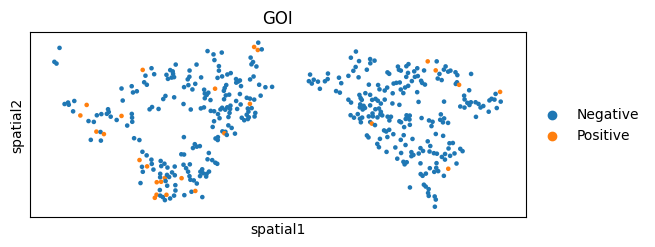

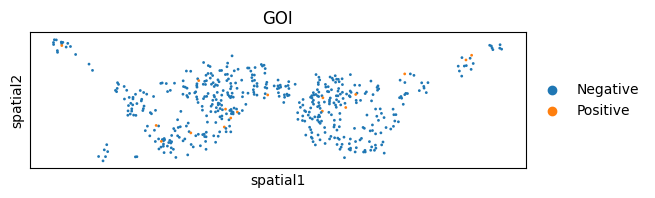

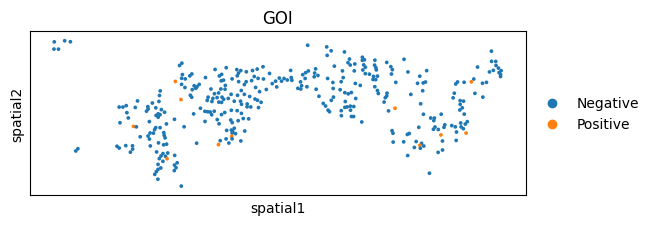

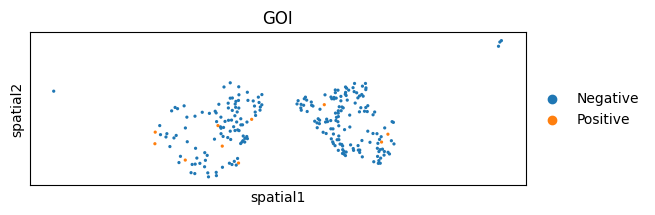

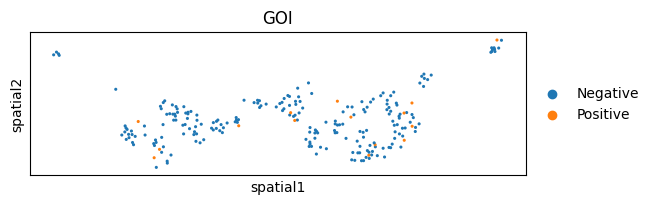

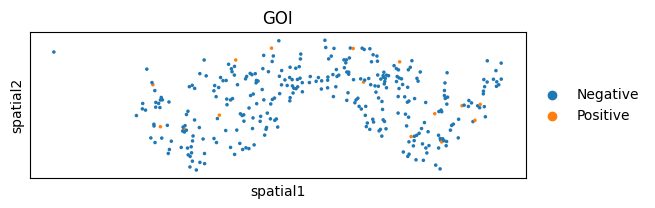

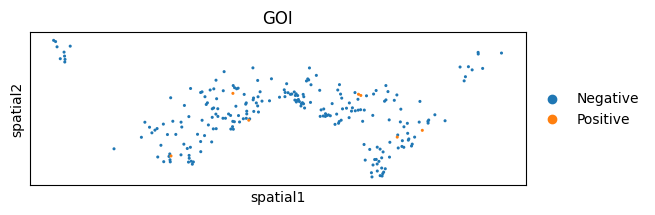

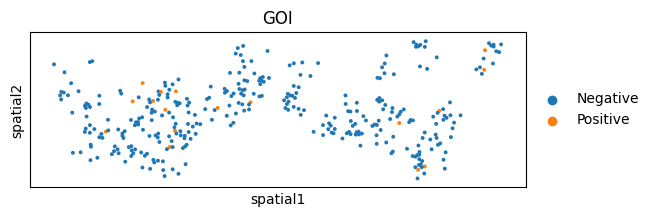

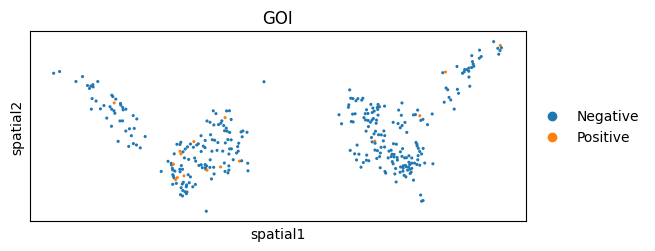

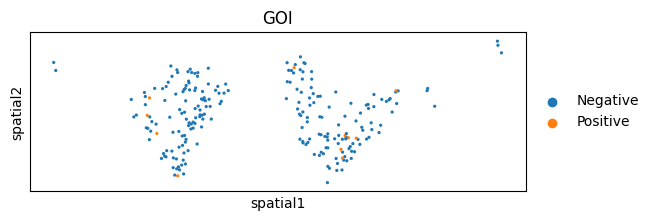

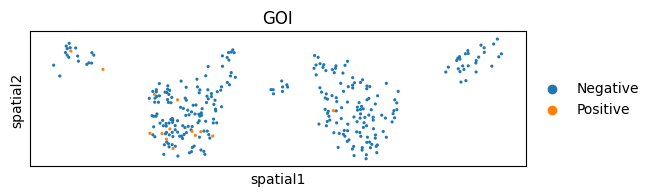

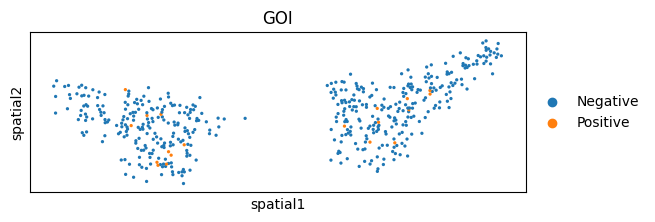

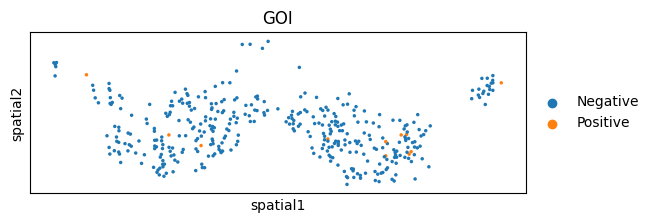

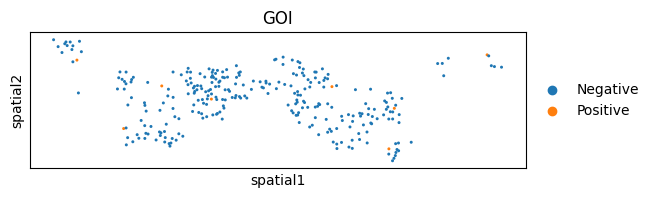

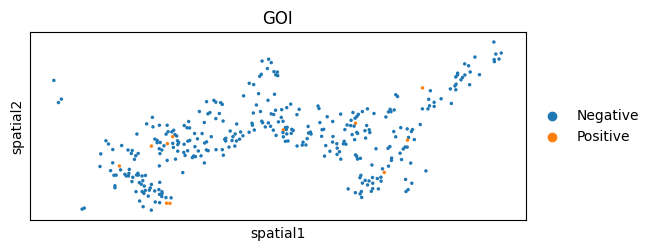

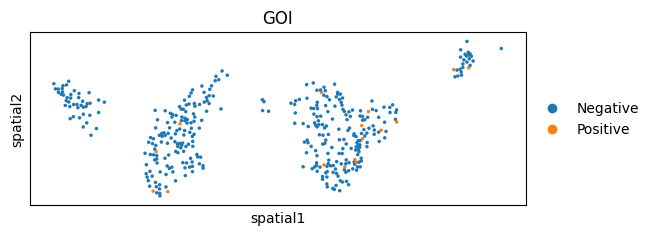

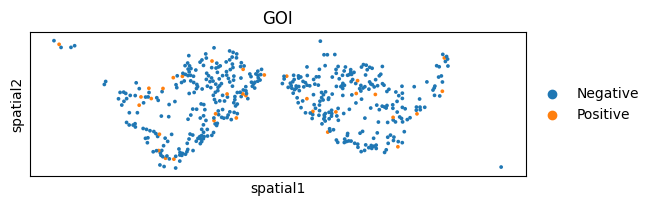

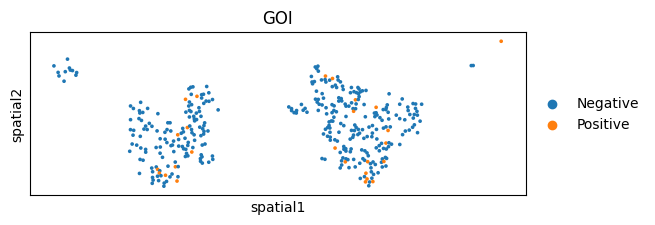

In [49]:
for k,v in d_adata_DA.items():
    GOI = list(v[:, 'Sox6'].X.A.flatten() > 0)
    v.obs['GOI'] = ['Positive' if x == True else 'Negative' for x in GOI]
    sc.pl.spatial(v, color = 'GOI', spot_size = 50)

In [160]:
import decoupler as dc

In [162]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [177]:
pdata

AnnData object with n_obs × n_vars = 36 × 14494
    obs: 'outlier', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n', 'keep', 'cell_type', 'SN-VTA', 'psbulk_n_cells', 'psbulk_counts'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'psbulk_props', 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [179]:
adata_DA = adata[adata.obs['cell_type'].isin(['SN', 'VTA']), :].copy()
# adata_DA = adata_DA[adata_DA.obs['batch'] == 'batch1', :].copy()

# sc.pp.normalize_total(adata_DA, target_sum=1e4)
# sc.pp.log1p(adata_DA)

pdata = dc.get_pseudobulk(
    adata_DA,
    sample_col='sample_name',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)

# Build DESeq2 object
dds = DeseqDataSet(
    adata=pdata,
    design_factors='SN_VTA',
    ref_level=['SN_VTA', 'VTA'],
    refit_cooks=True,
    n_cpus=16,
)

dds.deseq2()

stat_res = DeseqStats(dds, contrast=["SN-VTA", 'SN', 'VTA'], alpha=0.1, n_cpus=16)

stat_res.summary()

# sc.tl.rank_genes_groups(adata_DA, groupby = 'age', reference = 'YOUNG', groups = ['OLD'], method = 'wilcoxon', key_added='age')

# df = sc.get.rank_genes_groups_df(adata_DA, key='age', group = 'OLD')
# df = df.loc[df['pvals_adj'] < 0.01]
# df

/tmp/ipykernel_2933247/1978587406.py:18: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.73 seconds.

Fitting dispersion trend curve...
... done in 2.18 seconds.

Fitting MAP dispersions...
... done in 3.59 seconds.

Fitting LFCs...
... done in 0.54 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: SN-VTA SN vs VTA


... done in 0.47 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik   17.523130       -0.002150  0.201742 -0.010656  0.991498   
0610009O20Rik    3.004921       -0.263517  0.306586 -0.859520  0.390054   
0610010F05Rik   11.041644        0.147570  0.216881  0.680421  0.496238   
0610010K14Rik   14.532991       -0.033152  0.203056 -0.163265  0.870310   
0610012G03Rik   50.211067       -0.113330  0.105479 -1.074437  0.282627   
...                   ...             ...       ...       ...       ...   
mt-Nd2         186.668793       -0.016425  0.168679 -0.097375  0.922428   
mt-Nd3          16.821022       -0.066206  0.351153 -0.188539  0.850454   
mt-Nd4         533.187683        0.016918  0.186516  0.090706  0.927726   
mt-Nd5          58.550949        0.013160  0.156949  0.083852  0.933174   
mt-Nd6          18.475672        0.006922  0.252972  0.027363  0.978170   

                   padj  
0610009B22Rik  0.999594  
0610009O20Rik  0.999594  
0610010F05Rik  0.999594  
0610010K14Rik  0.999594  
0610012G03Rik  0.999594  
...                 ...  
mt-Nd2         0.999594  
mt-Nd3         0.999594  
mt-Nd4         0.999594  
mt-Nd5         0.999594  
mt-Nd6         0.999594  

[14494 rows x 6 columns]

In [180]:
df = stat_res.results_df
df.loc[df['padj'] < 0.1]

Empty DataFrame
Columns: [baseMean, log2FoldChange, lfcSE, stat, pvalue, padj]
Index: []

In [186]:
adata_DA = adata[adata.obs['cell_type'].isin(['SN', 'VTA']), :].copy()
# adata_DA = adata_DA[adata_DA.obs['batch'] == 'batch1', :].copy()

sc.pp.normalize_total(adata_DA, target_sum=1e4)
sc.pp.log1p(adata_DA)
# sc.tl.rank_genes_groups(adata_DA, groupby = 'age', reference = 'YOUNG', groups = ['OLD'], method = 'wilcoxon', key_added='age')
sc.tl.rank_genes_groups(adata_DA, groupby = 'SN_VTA', reference = 'VTA', groups = ['SN'], method = 'wilcoxon', key_added='SN_VTA')

df = sc.get.rank_genes_groups_df(adata_DA, key='SN_VTA', group = 'SN')
# df = df.loc[df['pvals_adj'] < 0.01]
df

names    scores  logfoldchanges         pvals  pvals_adj
0      Sept11  5.148073        0.543874  2.631764e-07   0.003814
1       Tenm2  2.962954        0.313616  3.047024e-03   0.999945
2       Ghitm  2.659256        0.251936  7.831351e-03   0.999945
3       Drap1  2.090370        0.237561  3.658454e-02   0.999945
4         Ddc  2.048513        0.134945  4.050977e-02   0.999945
...       ...       ...             ...           ...        ...
14489   Rps20 -2.932178       -0.220331  3.365936e-03   0.999945
14490    Apoe -2.999594       -0.161577  2.703392e-03   0.999945
14491   Rpl35 -3.005467       -0.232079  2.651736e-03   0.999945
14492  Tmsb4x -3.320461       -0.152385  8.986901e-04   0.999945
14493   Rps27 -3.358351       -0.208277  7.840912e-04   0.999945

[14494 rows x 5 columns]

# Export per slice DA adata for SpatialDE2

In [58]:
for sn in adata_DA.obs['sample_name'].unique():
    t = adata_DA[adata_DA.obs['sample_name'] == sn, :].copy()
    t.write("input/06_post_annotation_analyses/adata_DA_per_sn/"+sn+"_DA.h5")

# Export per slice each cell type adata for SpatialDE2

In [74]:
for sn in adata.obs['sample_name'].unique():
    print(sn)
    t = adata[adata.obs['sample_name'] == sn, :].copy()
    for ct in t.obs['cell_type'].unique():
        ct_name = ct.replace(' ', '_').replace('/', '.')
        t_ct = t[t.obs['cell_type'] == ct, :].copy()
        t_ct.write("input/06_post_annotation_analyses/adata_per_sn_per_ct/"+sn+"_"+ct_name+".h5")

OLD_OVX_1
OLD_OVX_2
OLD_OVX_3
OLD_OVX_4
OLD_OVX_5
OLD_WT_1
OLD_WT_2
OLD_WT_3
OLD_WT_4
OLD_WT_5
YOUNG_OVX_1
YOUNG_OVX_2
YOUNG_OVX_3
YOUNG_OVX_4
YOUNG_WT_1
YOUNG_WT_2
YOUNG_WT_3
YOUNG_WT_4


/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


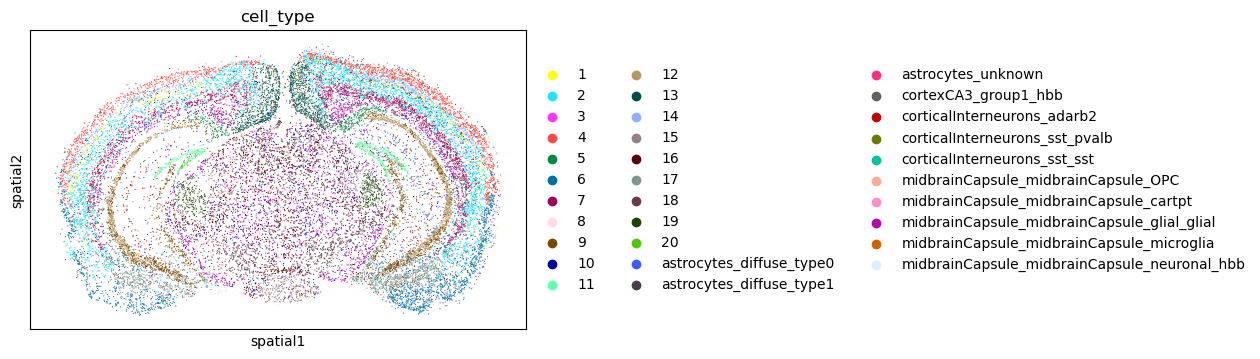

In [47]:
adata_temp = adata
adata_temp = adata_temp[adata_temp.obs['sample_name'] == 'YOUNG_OVX_2', :]
sc.pl.spatial(adata_temp, spot_size=50, color = 'cell_type')

/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


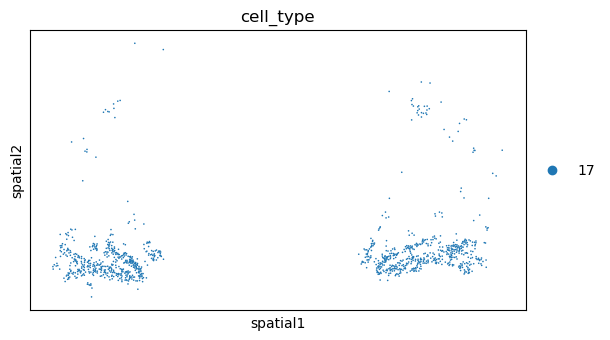

In [94]:
sc.pl.spatial(adata_neu[(adata_neu.obs['sample_name'] == 'YOUNG_WT_2') & (adata_neu.obs['cell_type'] == '17'), :], spot_size = 50, color = 'cell_type')

/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


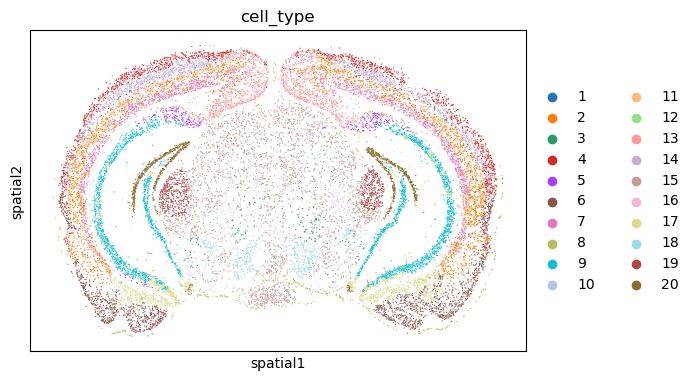

In [90]:
sc.pl.spatial(adata_neu[adata_neu.obs['sample_name'] == 'YOUNG_WT_2', :], spot_size = 50, color = 'cell_type')

/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: T

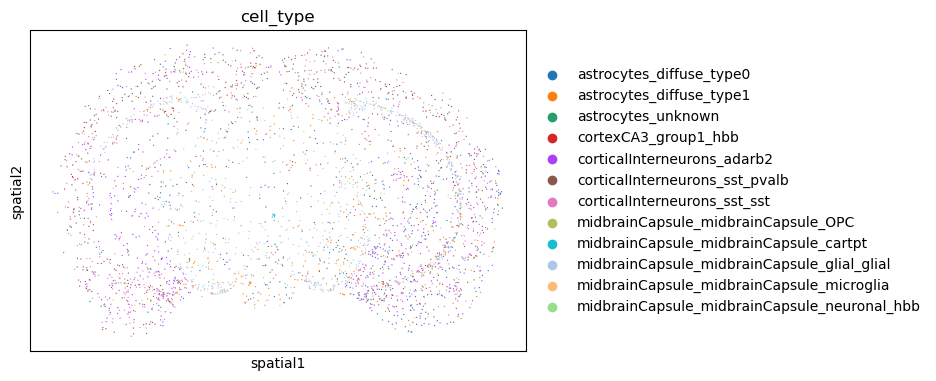

In [93]:
sc.pl.spatial(adata_nongst[adata_nongst.obs['sample_name'] == 'YOUNG_WT_2', :], spot_size = 50, color = 'cell_type')

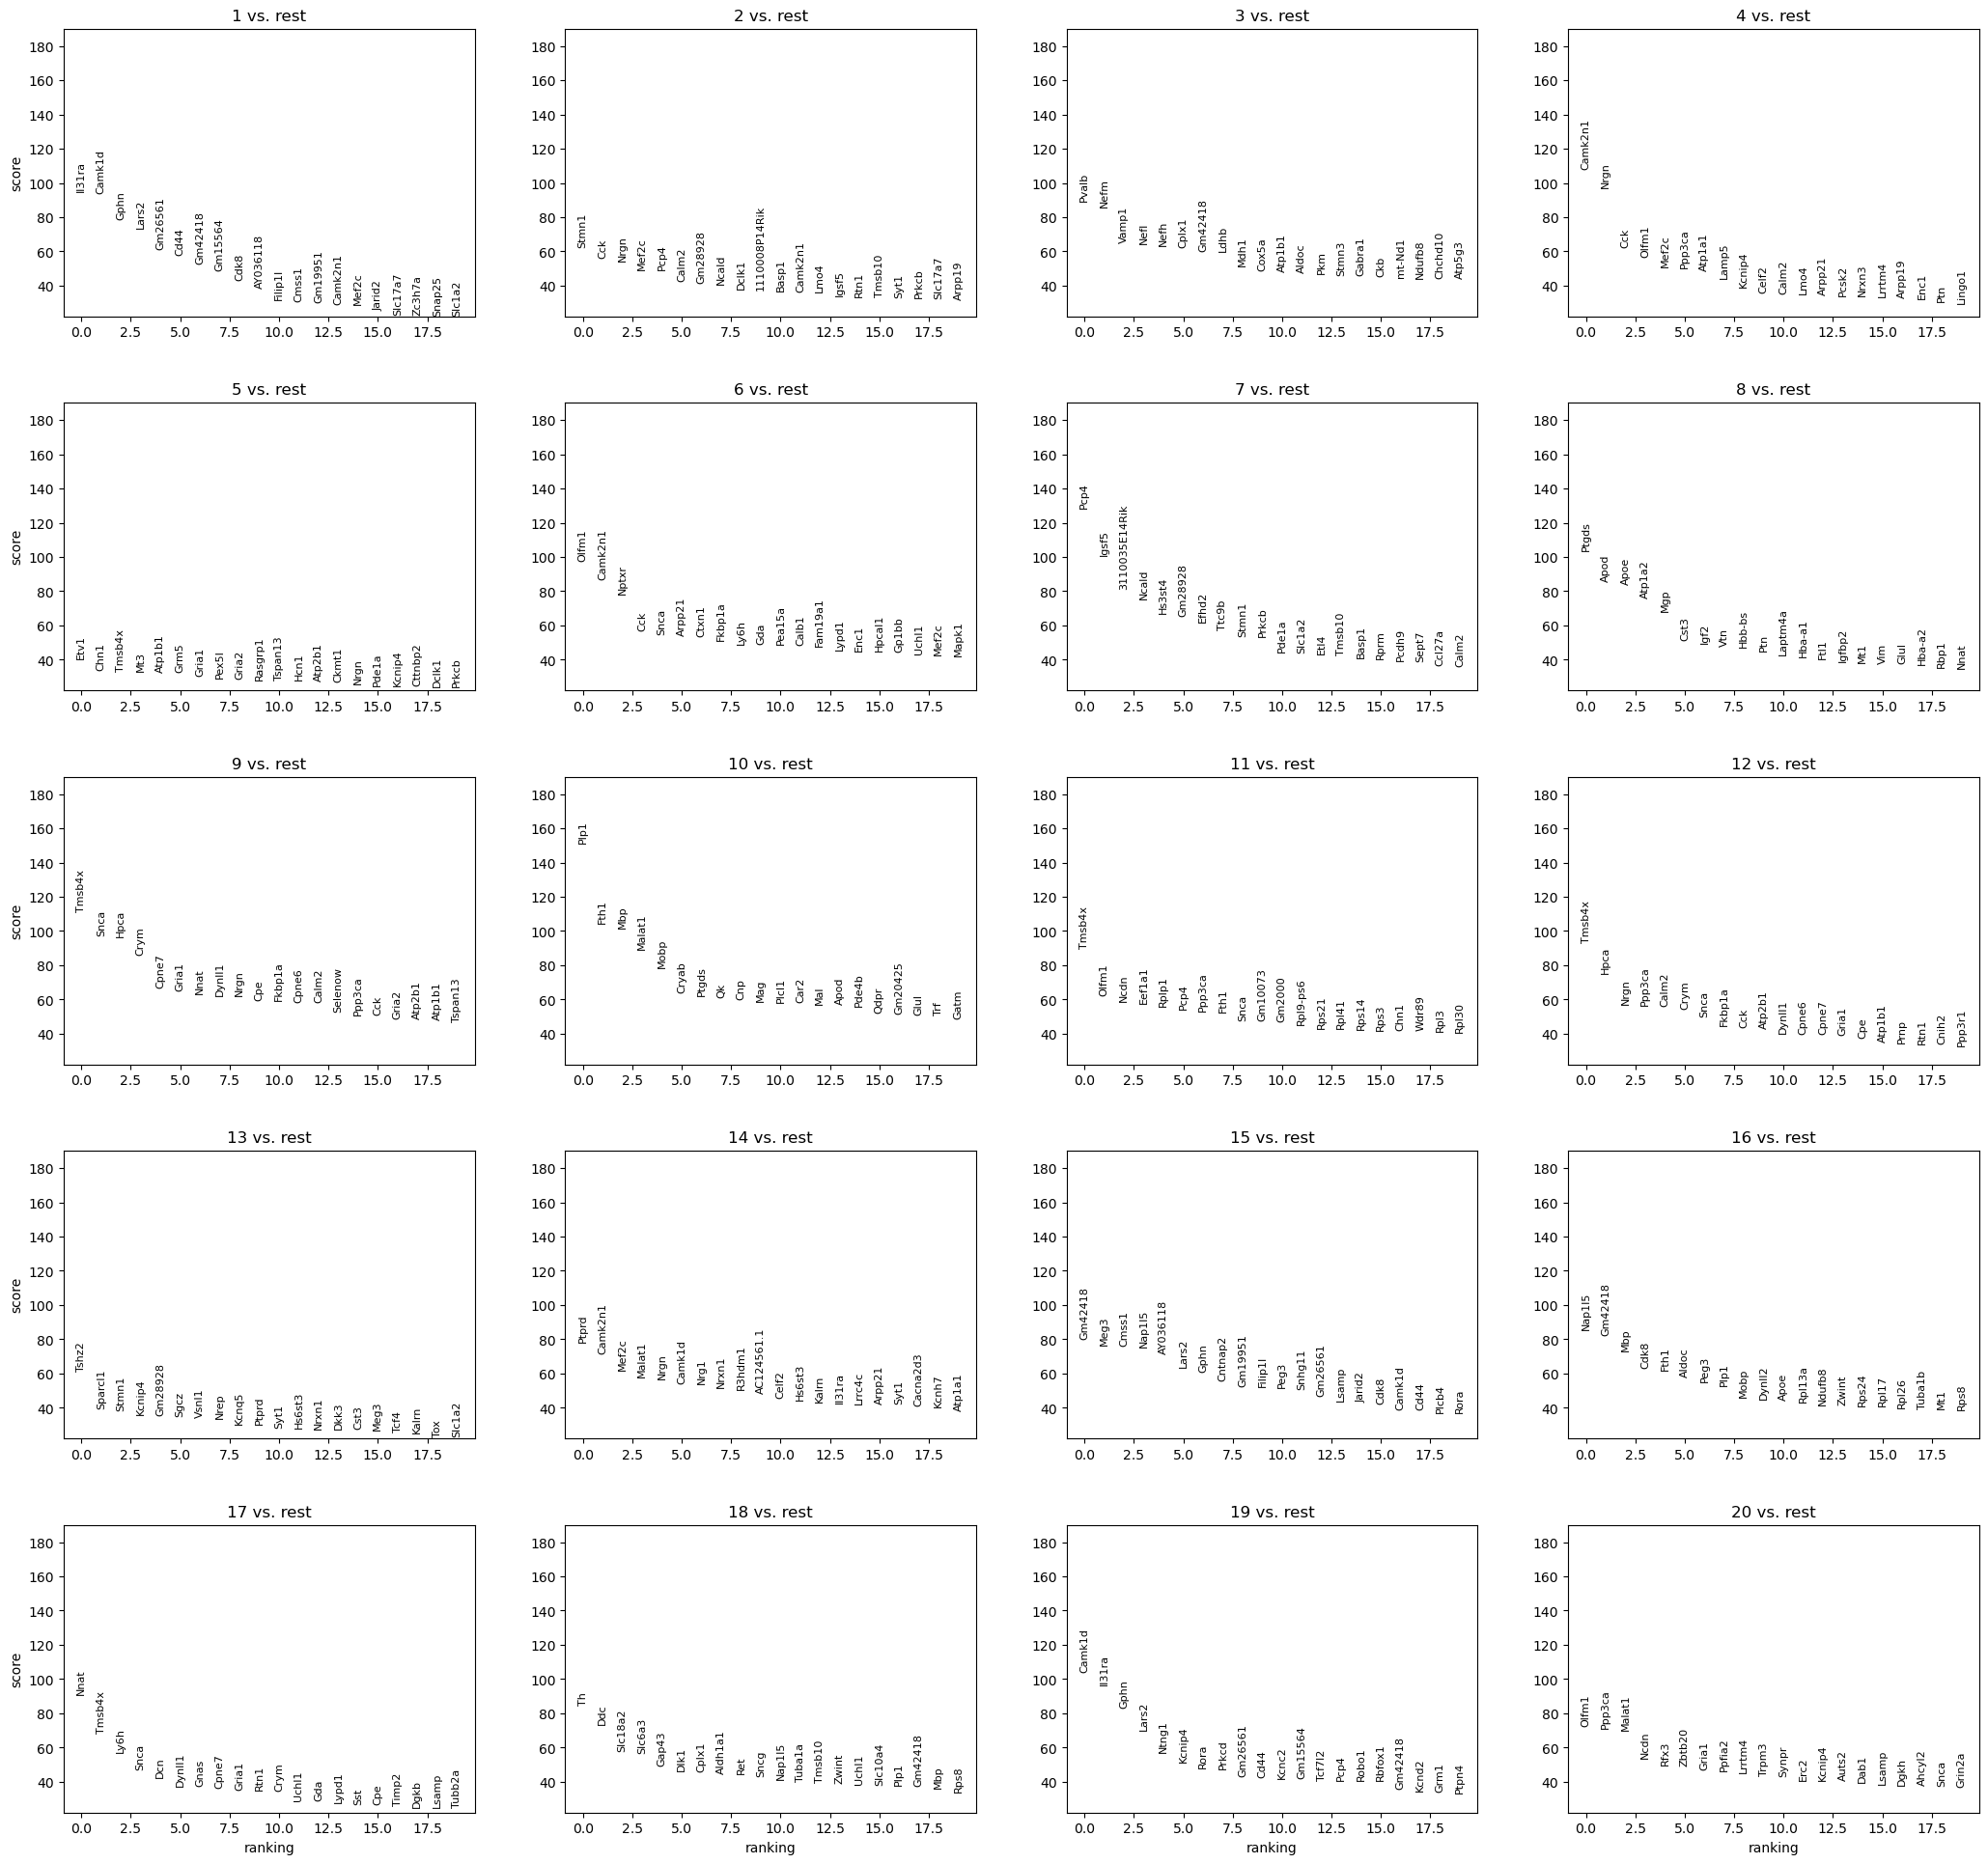

In [70]:
sc.pl.rank_genes_groups(adata_neu)

In [95]:
adata.obs.groupby('cell_type').size()

/tmp/ipykernel_1304214/326900788.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('cell_type').size()


cell_type
1                                                4051
2                                               32049
3                                                7238
4                                               20143
5                                                7085
6                                               24809
7                                               22004
8                                                4962
9                                               24281
10                                              10735
11                                               6593
12                                               8821
13                                              20185
14                                              18164
15                                              32201
16                                              23223
17                                              17274
18                                               6378
19                

/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/peter/mambaforge/envs/05_annotation/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


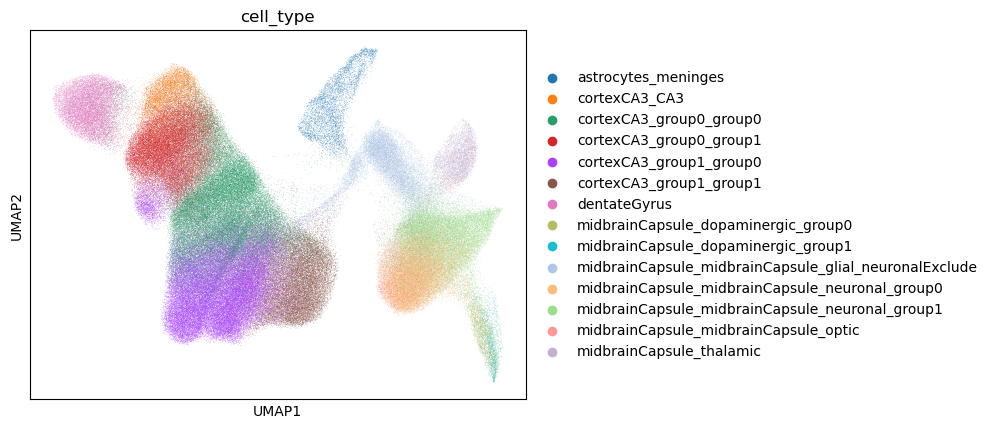

In [99]:
sc.pl.umap(adata_gst, color = 'cell_type')

In [66]:
pd.set_option('display.max_rows', 50)

df = sc.get.rank_genes_groups_df(adata, group='1')
df = df.loc[df['pvals_adj'] < 0.0001].sort_values('logfoldchanges', ascending=False)[:50]
df

names     scores  logfoldchanges          pvals      pvals_adj
0           Il31ra  95.270241        3.091927   0.000000e+00   0.000000e+00
1           Camk1d  94.791023        3.078508   0.000000e+00   0.000000e+00
39          Plcxd2  17.930405        2.582942   6.828077e-72   2.199248e-69
478           Coch   5.004638        2.472061   5.596709e-07   1.314728e-05
165         Plxnd1   9.231306        2.468602   2.673512e-20   1.966999e-18
290          Pamr1   6.837428        2.375270   8.062746e-12   3.184236e-10
337          Dkkl1   6.316376        2.346942   2.677673e-10   9.174988e-09
344  A830036E02Rik   6.278211        2.249955   3.424920e-10   1.154437e-08
2             Gphn  79.841492        2.142620   0.000000e+00   0.000000e+00
7          Gm15564  50.067932        2.100359   0.000000e+00   0.000000e+00
352           Pkib   6.187891        2.036168   6.097445e-10   2.008554e-08
5             Cd44  59.065121        2.030107   0.000000e+00   0.000000e+00
124           Reln  10.798857        2.007231   3.485146e-27   3.532427e-25
14           Mef2c  30.605837        1.983525  1.023535e-205  9.271946e-203
534            Boc   4.659855        1.929050   3.164319e-06   6.666226e-05
49            Egr1  16.306122        1.845527   8.928379e-60   2.310856e-57
3            Lars2  75.278023        1.841602   0.000000e+00   0.000000e+00
135           Rorb  10.078683        1.769813   6.863975e-24   6.179282e-22
19          Pgm2l1  24.196426        1.696872  2.426048e-129  1.674435e-126
208          Gfra2   8.392649        1.693709   4.753107e-17   2.755661e-15
4          Gm26561  62.890987        1.667478   0.000000e+00   0.000000e+00
98          Tmem56  11.744275        1.664237   7.556770e-32   9.867372e-30
489        Klhdc8a   4.931846        1.646853   8.145603e-07   1.876985e-05
17         Slc17a7  25.443672        1.630127  8.294949e-143  6.327736e-140
479          Kcnh5   5.000213        1.609949   5.726717e-07   1.343091e-05
193          Hmgcr   8.664176        1.606019   4.547906e-18   2.853565e-16
443        Zdhhc22   5.281273        1.589620   1.282894e-07   3.291021e-06
29            Nrn1  19.464598        1.533962   2.192060e-84   9.928660e-82
58         Fam19a2  15.011310        1.525340   6.191352e-51   1.359658e-48
30   1700020I14Rik  19.459433        1.504338   2.424563e-84   1.064898e-81
127         Necab1  10.571204        1.473248   4.052583e-26   4.023160e-24
204         Pdzrn3   8.411853        1.471449   4.035839e-17   2.377864e-15
10         Camk2n1  32.719830        1.461432  8.159006e-235  9.854720e-232
22           Nptxr  22.414932        1.450350  2.814705e-111  1.699847e-108
65           Stx1a  14.223230        1.450153   6.574611e-46   1.305376e-43
227          Kcnf1   8.073060        1.442972   6.855813e-16   3.666722e-14
306          Nuak1   6.670787        1.432939   2.544345e-11   9.603577e-10
500            Wls   4.864794        1.430259   1.145763e-06   2.590747e-05
446        Nectin1   5.241701        1.417127   1.591030e-07   4.017489e-06
209          Satb1   8.374511        1.380220   5.545360e-17   3.202169e-15
101         Fam81a  11.553871        1.376195   7.056835e-31   8.894066e-29
415         Phlda1   5.557571        1.346662   2.735547e-08   7.509284e-07
385        Rasl11b   5.803993        1.342797   6.475399e-09   1.911496e-07
96           Cdkl5  11.866274        1.340958   1.771848e-32   2.356070e-30
72           Camk4  13.547711        1.326728   8.173946e-42   1.444795e-39
276         Thsd7a   7.047031        1.313240   1.827751e-12   7.700997e-11
25             Ptn  20.952997        1.305598   1.761862e-97   9.457935e-95
48         Rasgrp1  16.352493        1.304503   4.175384e-60   1.100328e-57
200          Cpne4   8.503071        1.297398   1.846402e-17   1.115073e-15
537         Dbpht2   4.618621        1.292523   3.862992e-06   8.102780e-05